In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import gym

In [2]:
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display


def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    plt.figure(figsize=(frames[0].shape[1]/72.0, frames[0].shape[0]/72.0),
               dpi=72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames),
                                   interval=50)

    anim.save('movie_cartpole.mp4')  # save a video
    display(display_animation(anim, default_mode='loop'))

### Creating a random agent

In [3]:
env = gym.make('Pong-v0')
env.reset()

env.render()
env.step(env.action_space.sample())

env.close()

In [4]:
frames = []
env = gym.make('CartPole-v0')
observation = env.reset()

for step in range(0, 200):
    frames.append(env.render(mode='rgb_array'))  # this needs display!!!
    action = np.random.choice(2)
    observation, reward, done, info = env.step(action)
    
    if done:
        break


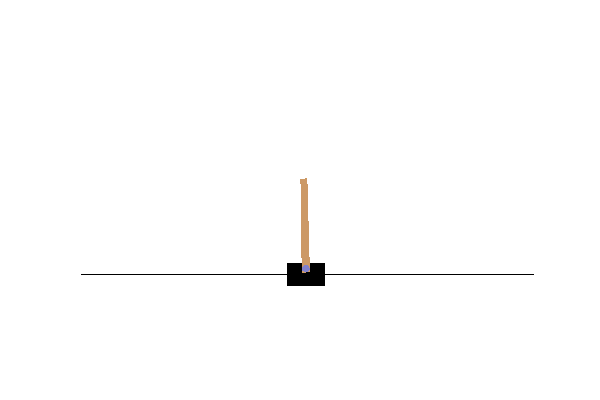
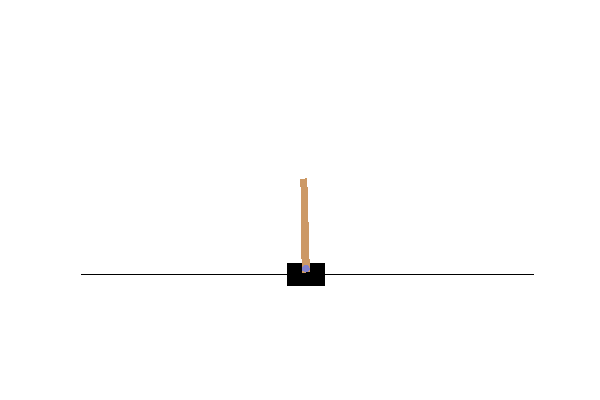
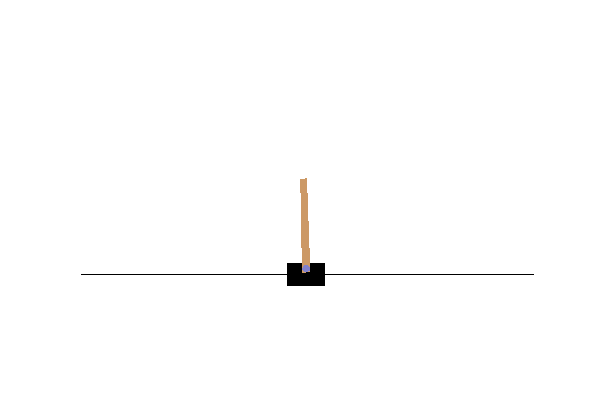
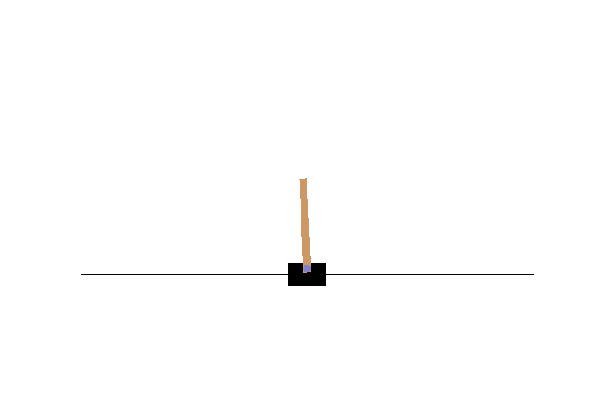
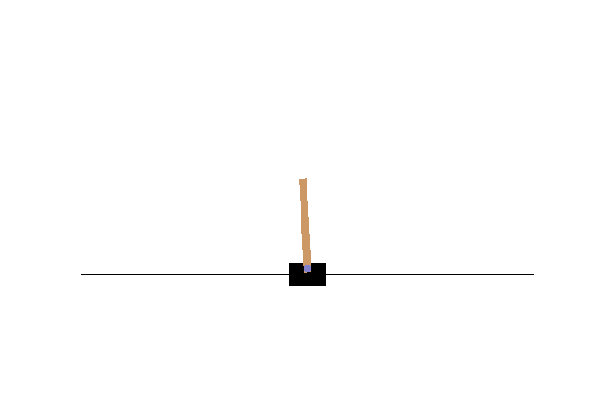
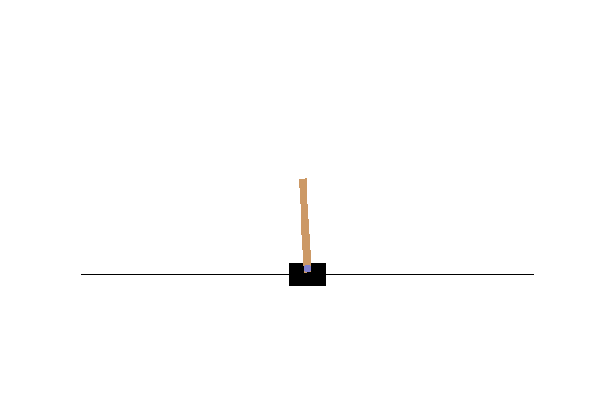
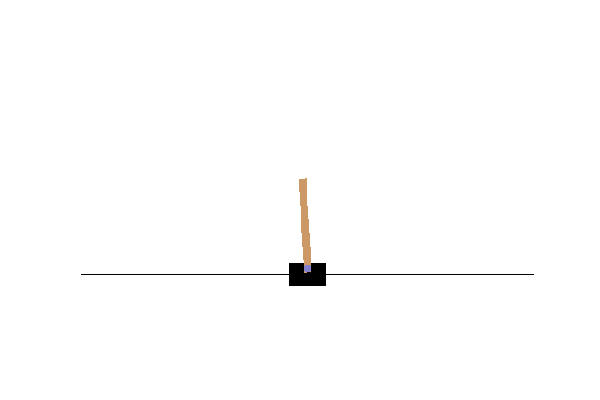
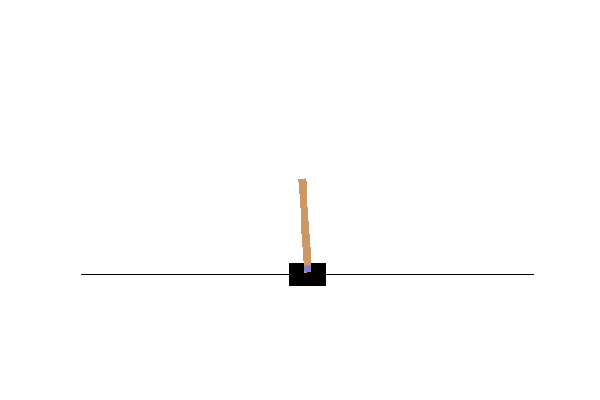
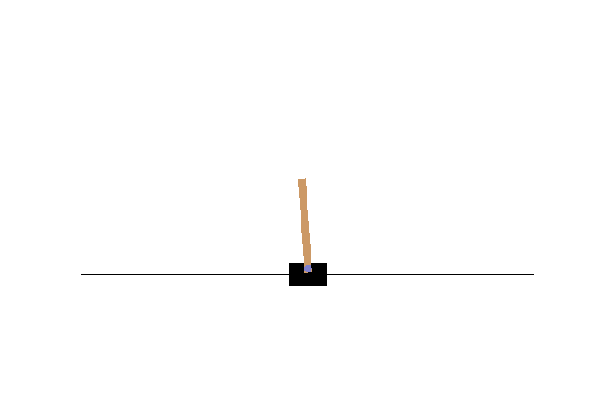
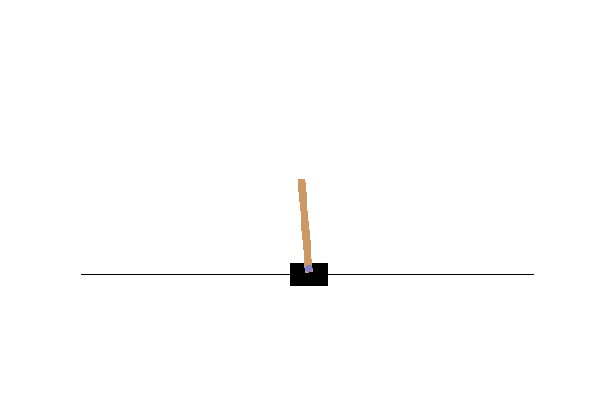
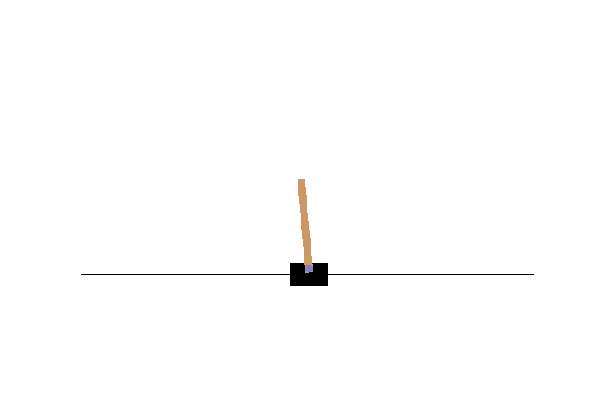
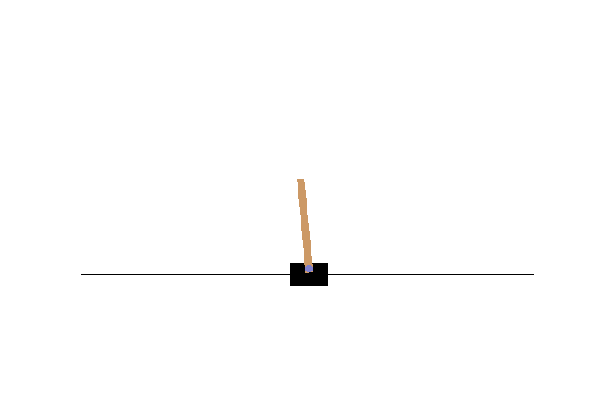
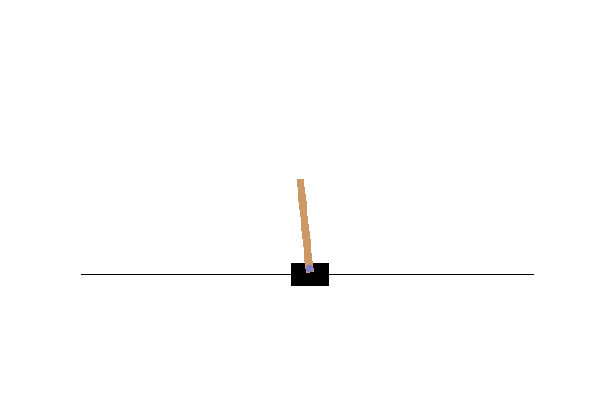
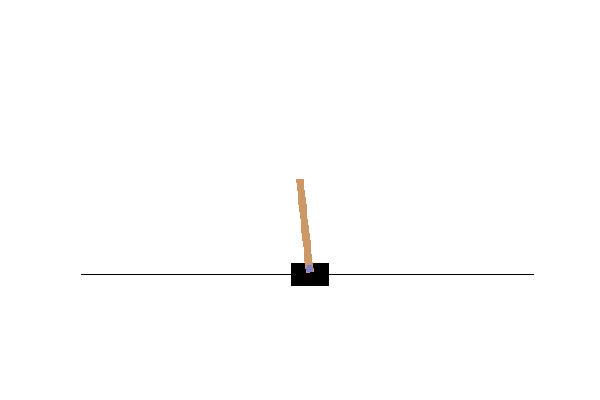
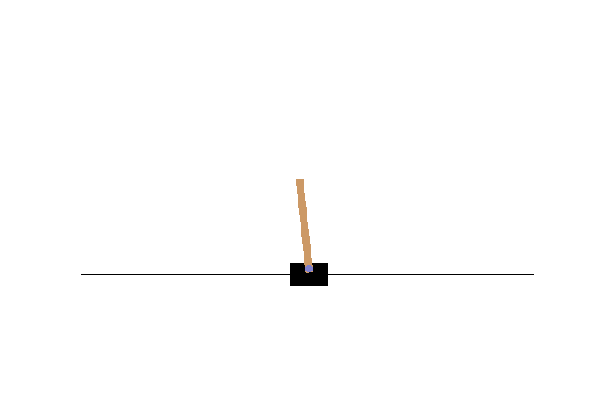
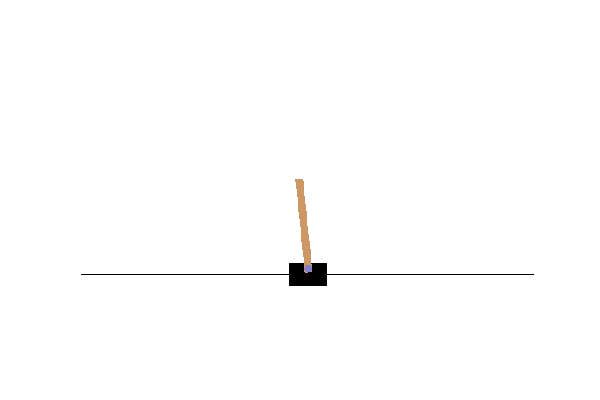
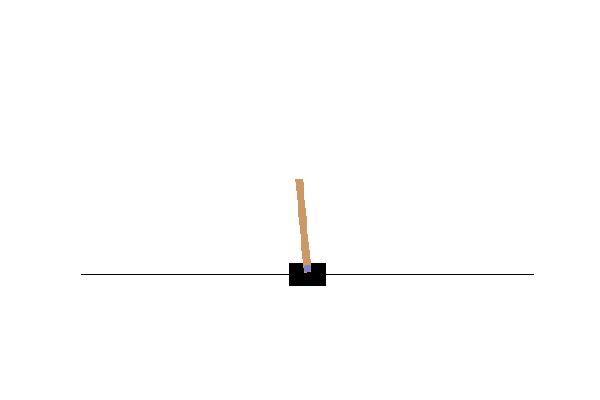
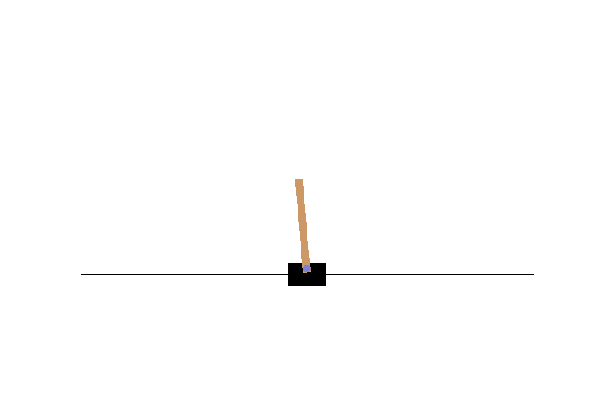
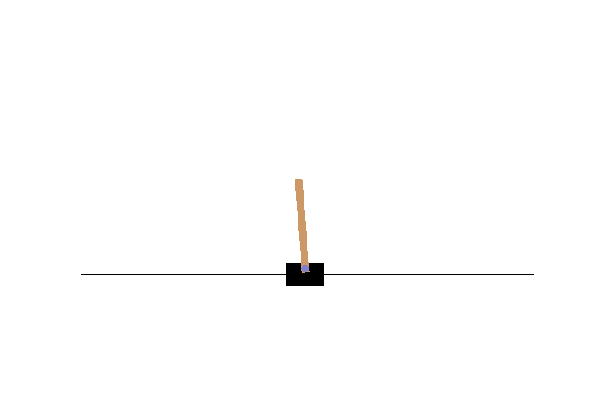
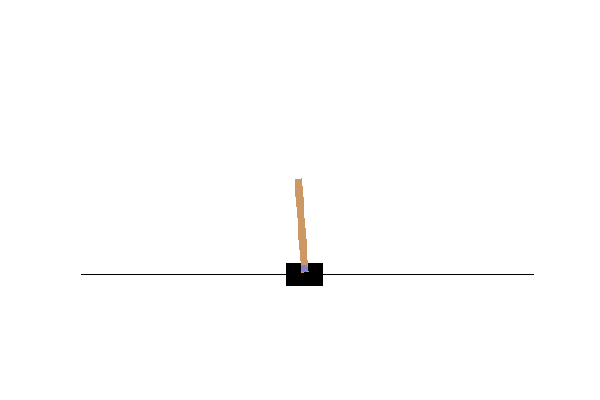
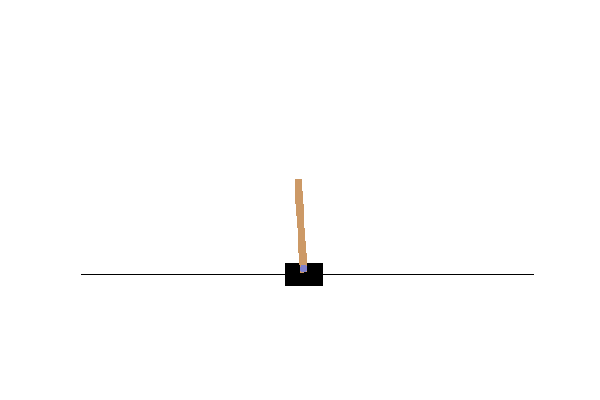
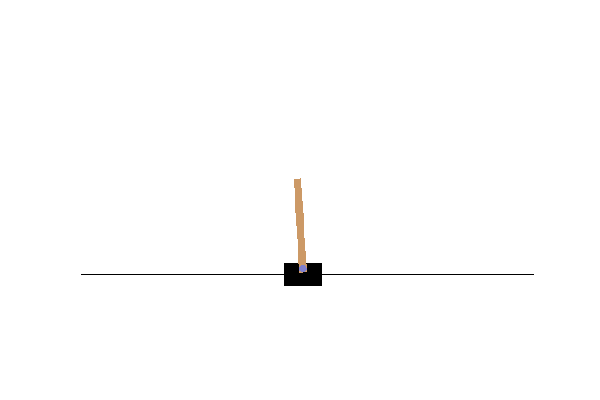
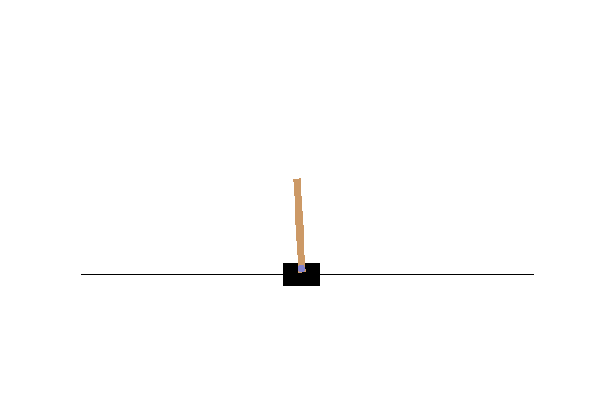
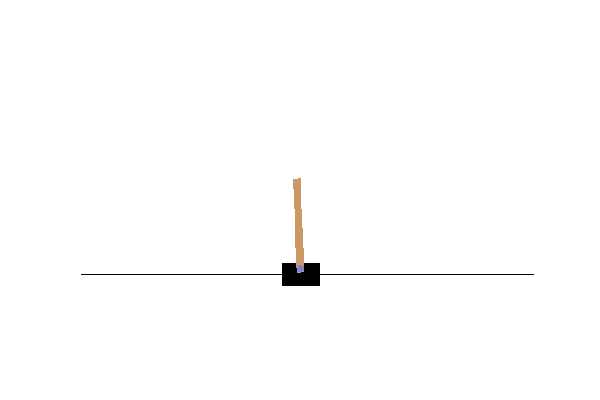
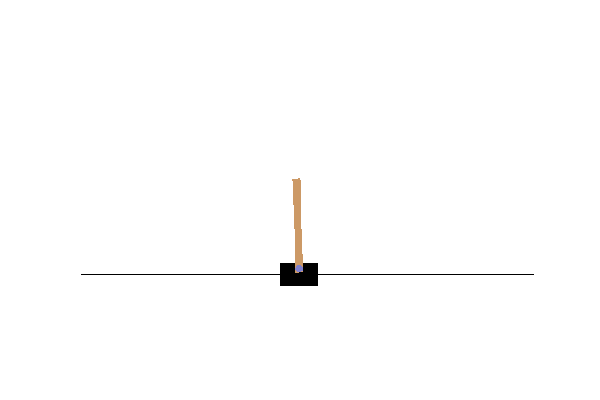
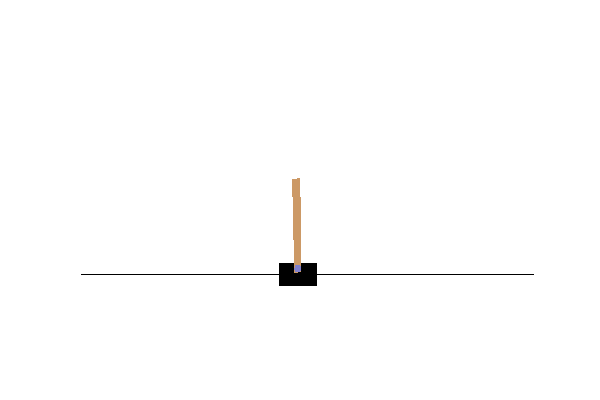
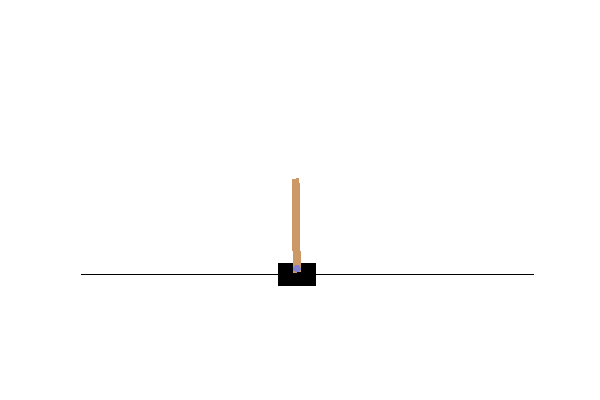
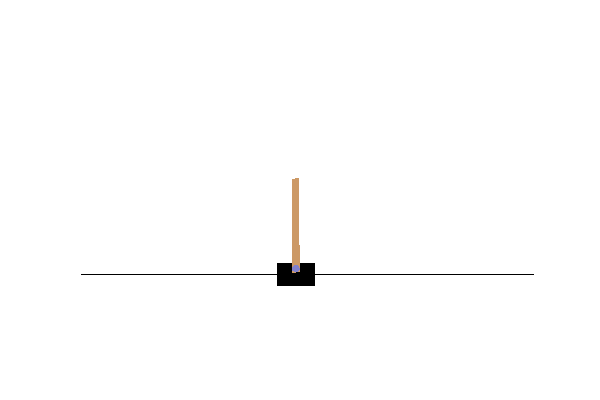
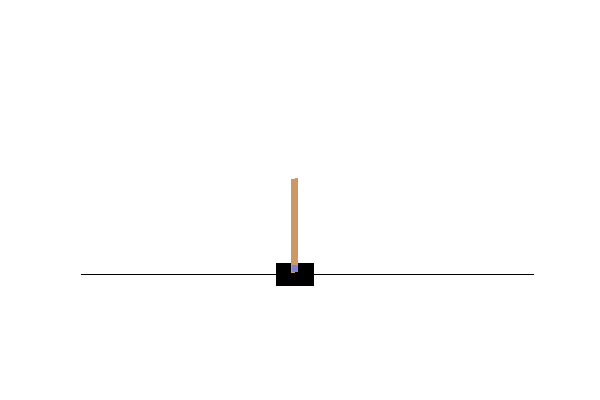
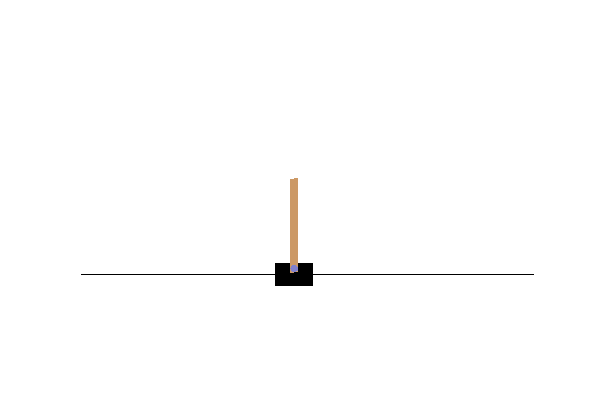
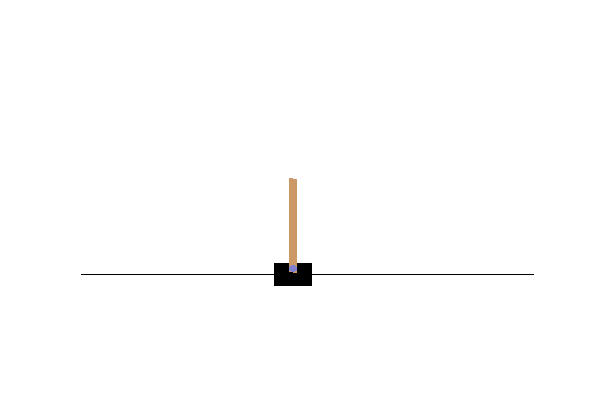
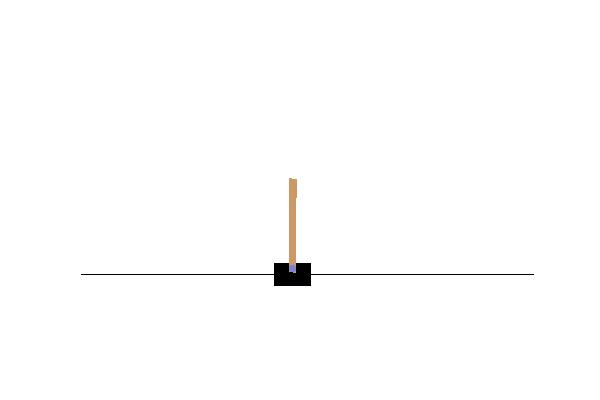
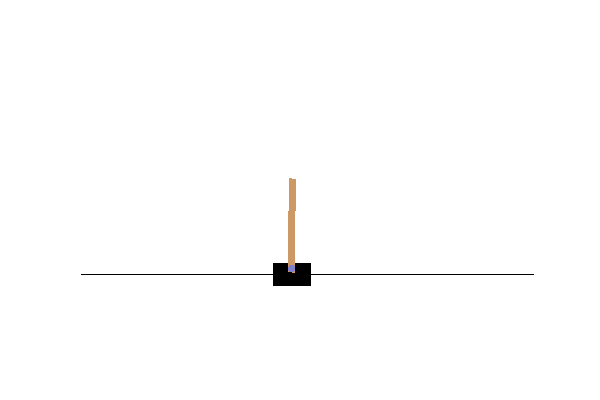
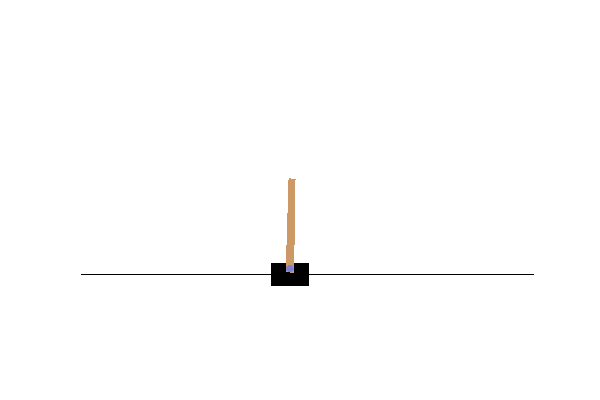
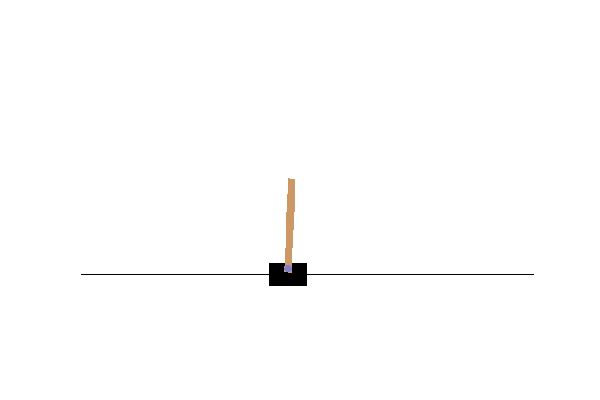
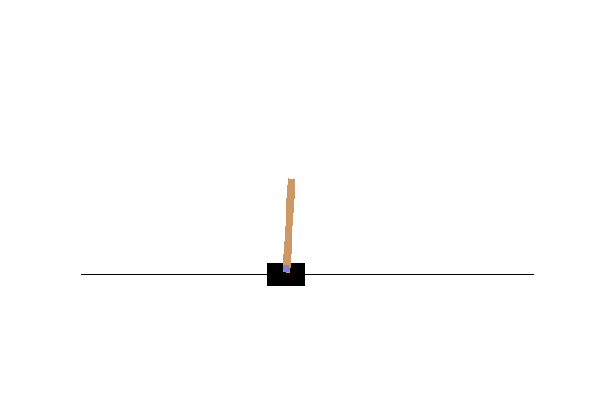
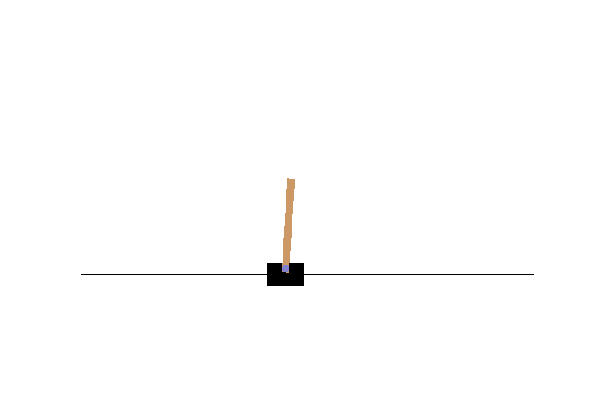
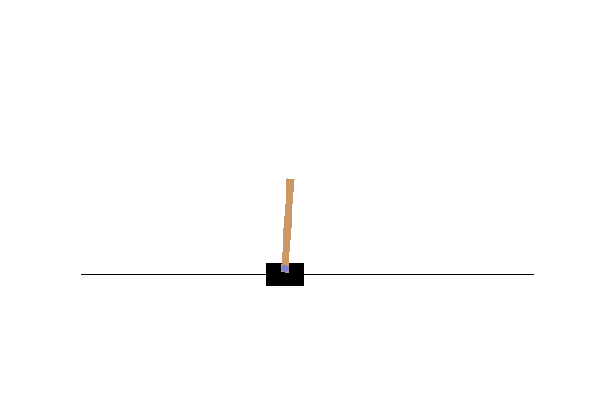
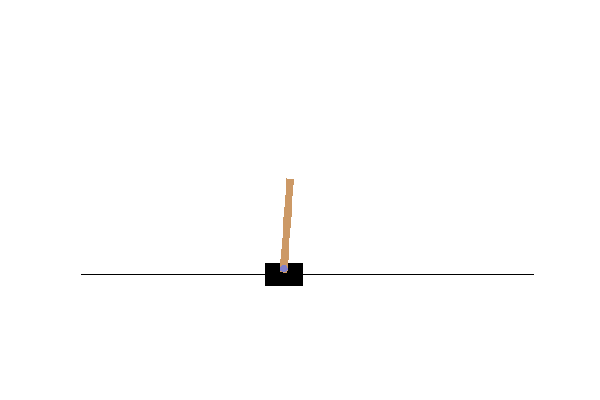
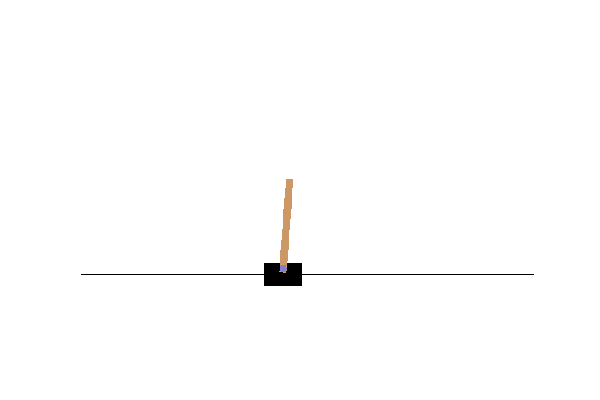
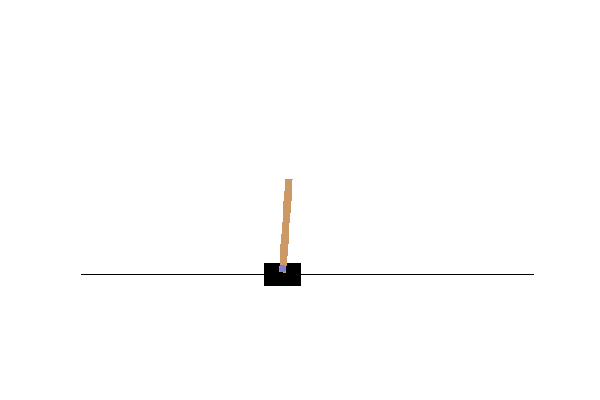
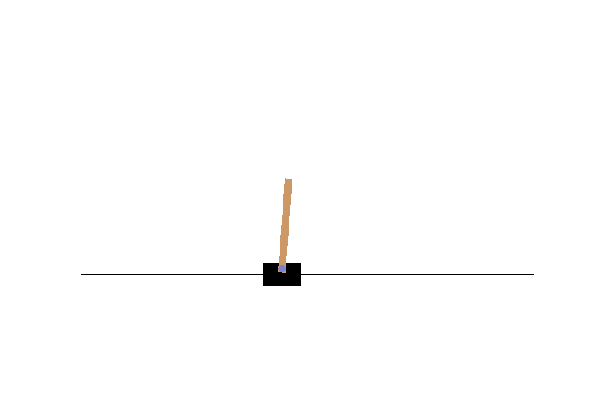
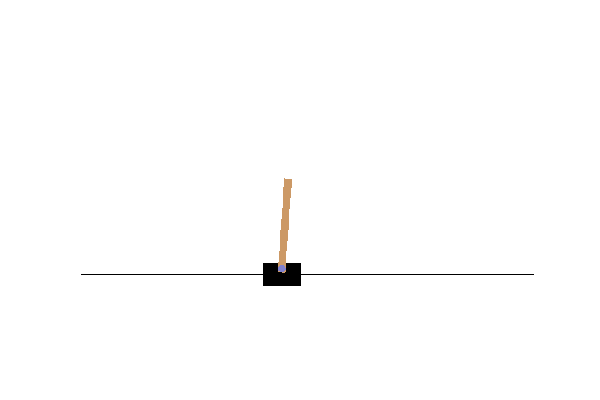
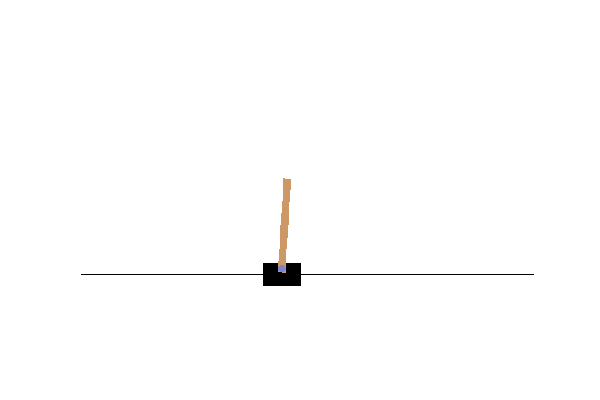
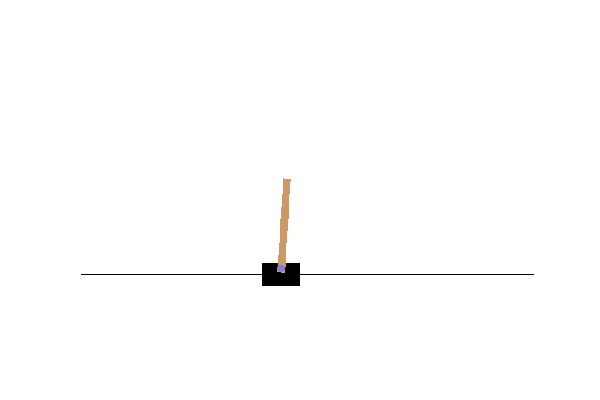
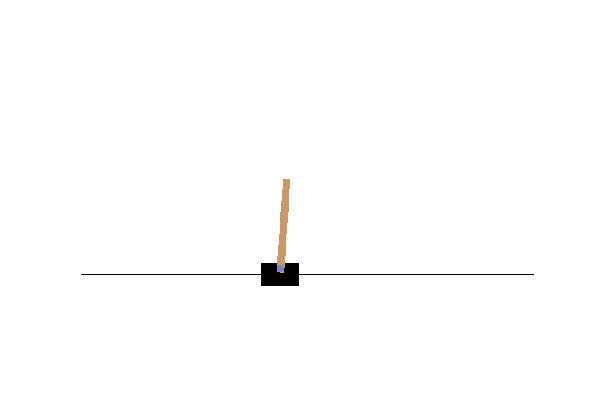
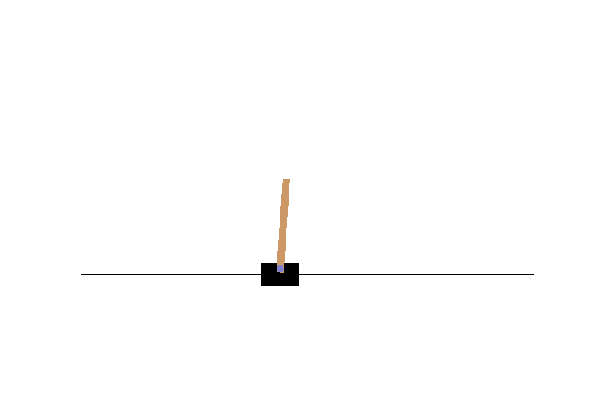
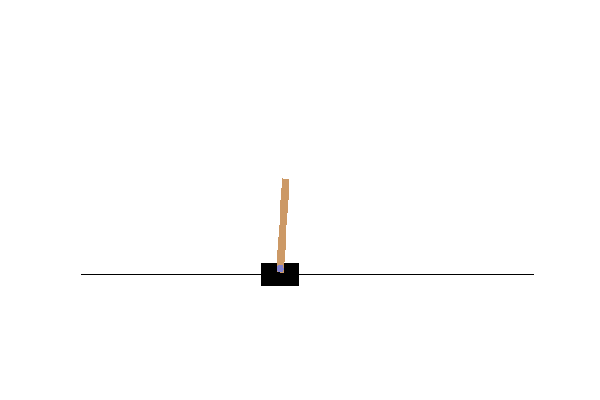
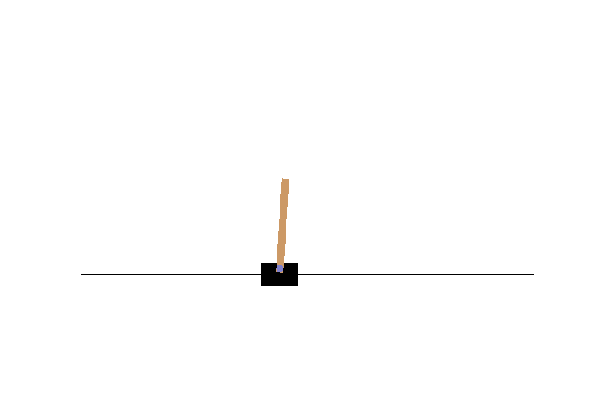
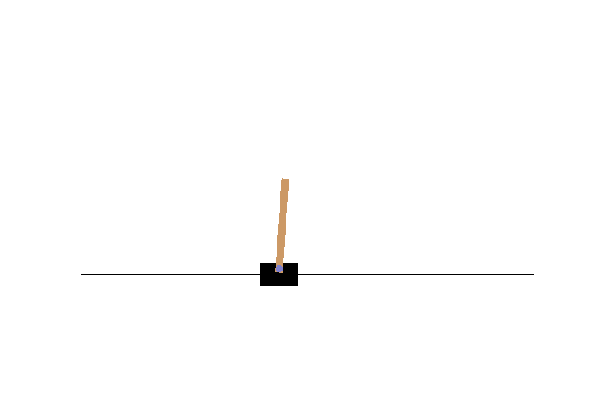
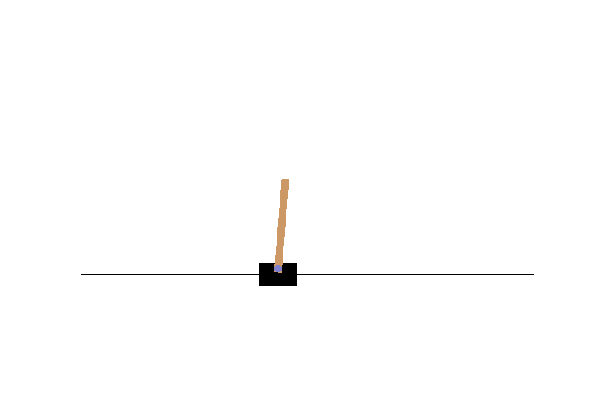
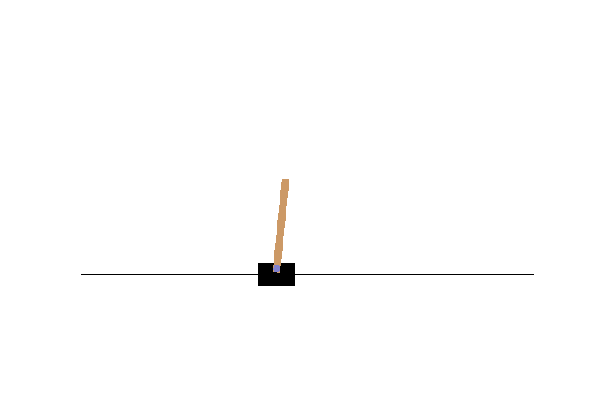
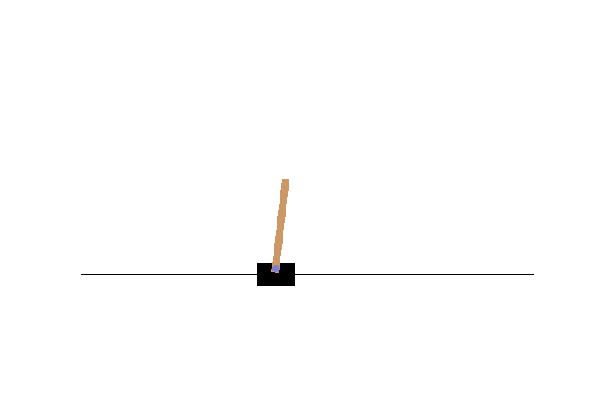
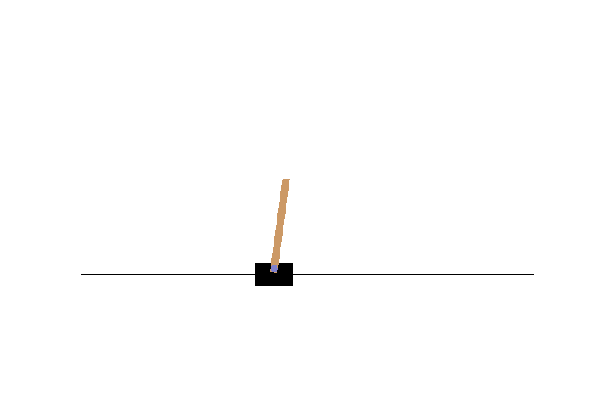
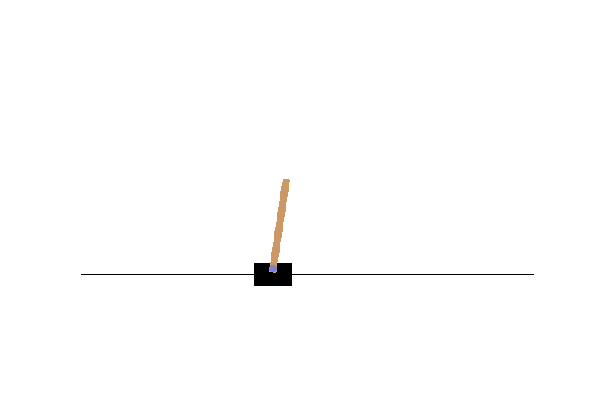
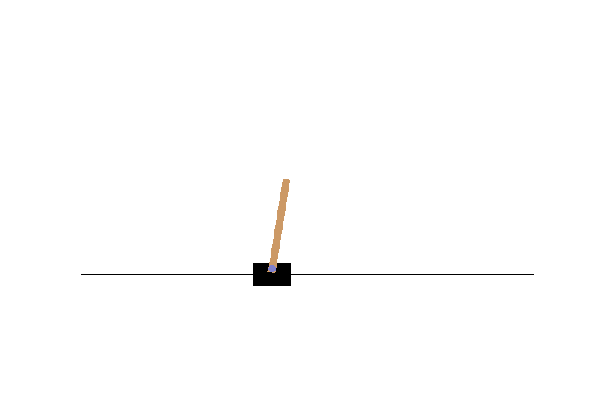
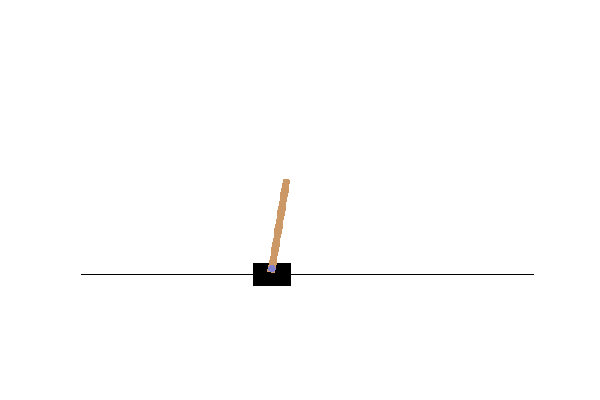
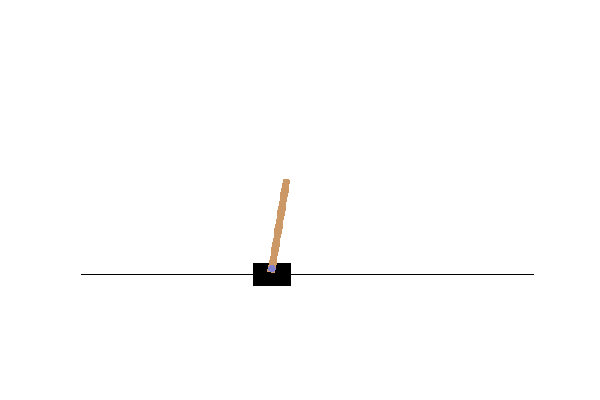
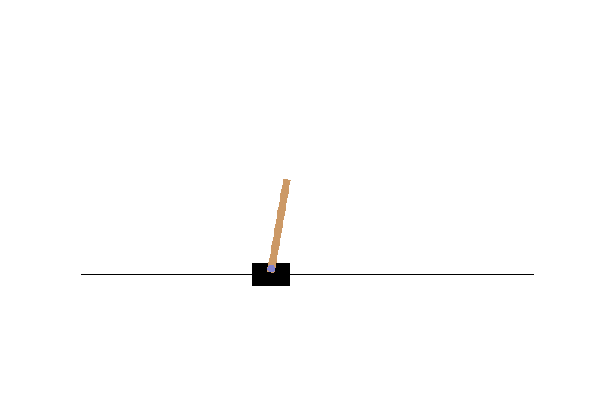
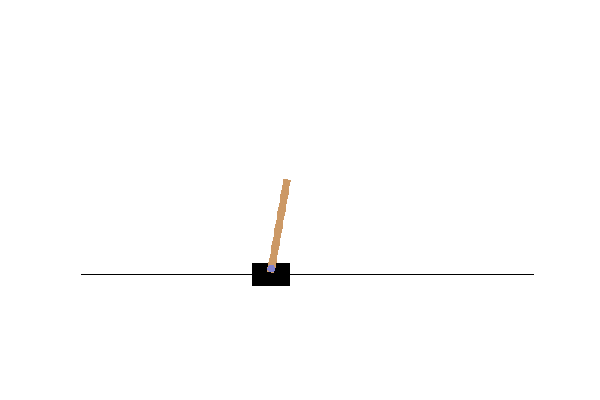
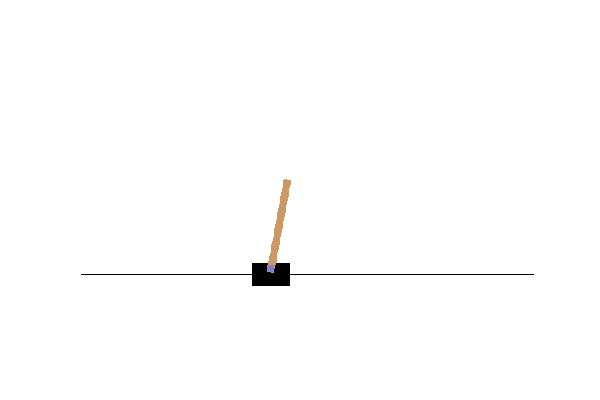
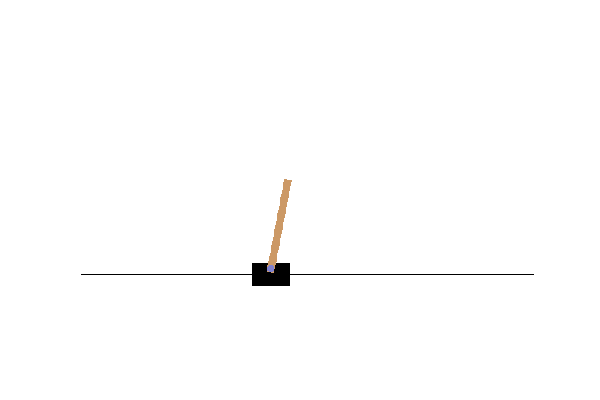
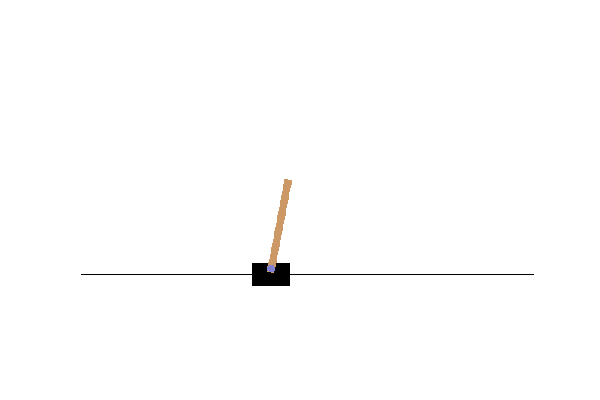
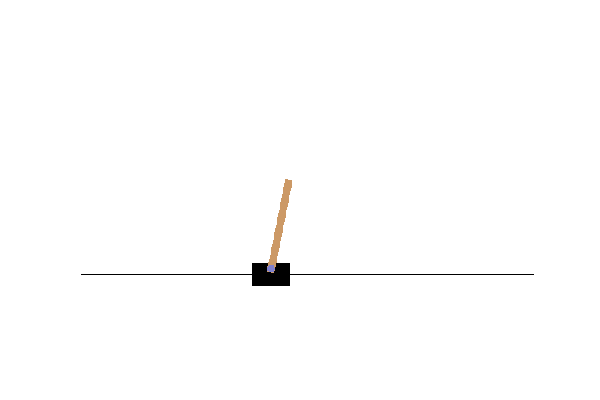
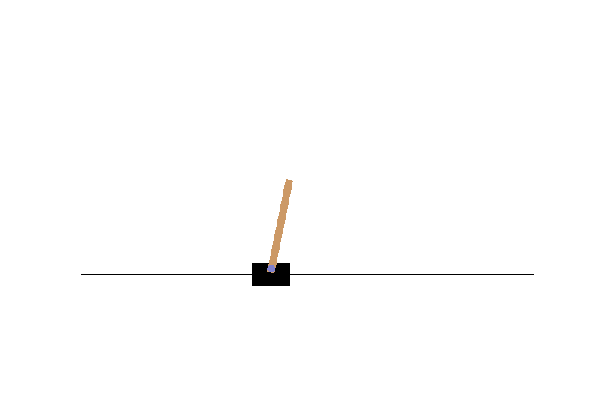
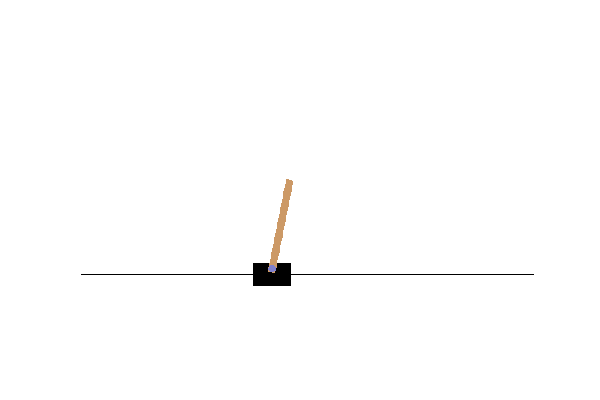
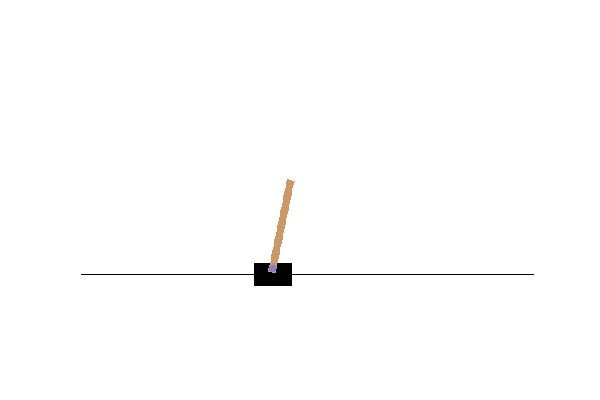
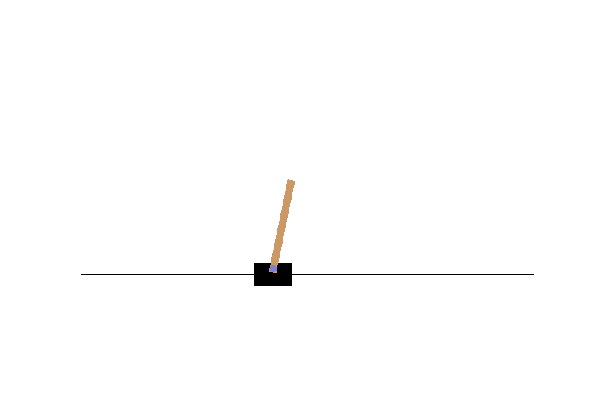
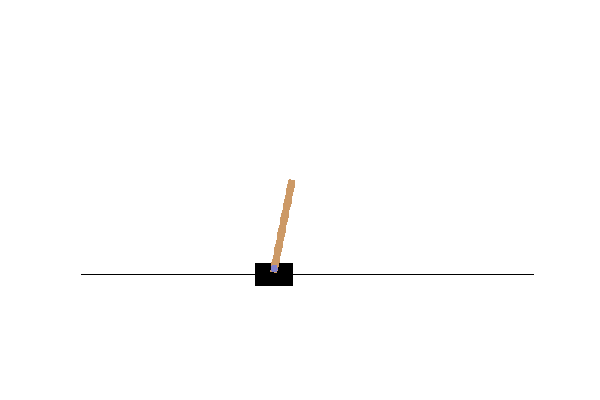
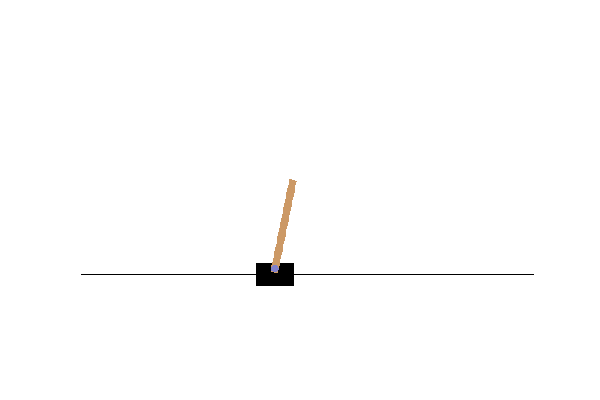

In [5]:
display_frames_as_gif(frames)

### Preparing for Q-Learning:

The maze only had 9 states and 4 actions.
However, cartpole is *almost* continuous.

- Loc: (-2.4 ~ 2.4)
- Vel: (-inf ~ inf)
- Deg: (-41.8 ~ 41.8)
- Rot: (-inf ~ inf)

Therefore there is the need to digitize the values so that we won't have a huge Q-table to keep track of.

In [9]:
ENV = 'CartPole-v0'
NUM_DIGITIZE = 6

In [10]:
def bins(clip_min, clip_max, num):
    return np.linspace(clip_min, clip_max, num + 1)[1:-1]

def digitize_state(observation):
    '''Digitize the observation'''
    cart_pos, cart_v, pole_angle, pole_v = observation
    digitized = [
        np.digitize(cart_pos, bins=bins(-2.4, 2.4, NUM_DIGITIZE)),
        np.digitize(cart_v, bins=bins(-3.0, 3.0, NUM_DIGITIZE)),
        np.digitize(pole_angle, bins=bins(-0.5, 0.5, NUM_DIGITIZE)),
        np.digitize(pole_v, bins=bins(-2.0, 2.0, NUM_DIGITIZE))]
    return sum([x * (NUM_DIGITIZE**i) for i, x in enumerate(digitized)])

In [11]:
env = gym.make(ENV)
observation = env.reset()
digitize_state(observation)

735

### Q-Learning

In [16]:
# Variables:
ENV = 'CartPole-v0'
NUM_DIGITIZED = 6
GAMMA = 0.99
ETA = 0.5
MAX_STEPS = 200
NUM_EPISODES = 1000

In [17]:
class Agent:
    '''Cartpole agent class'''

    def __init__(self, num_states, num_actions):
        self.brain = Brain(num_states, num_actions)  # initialize the brain

    def update_Q_function(self, observation, action, reward, observation_next):
        '''Q iteration'''
        self.brain.update_Q_table(
            observation, action, reward, observation_next)

    def get_action(self, observation, step):
        '''Decide action'''
        action = self.brain.decide_action(observation, step)
        return action

In [19]:
class Brain:
    '''The brain for the agent (Q-learning)'''

    def __init__(self, num_states, num_actions):
        self.num_actions = num_actions

        # Initialize the Q-table based on digitized states
        self.q_table = np.random.uniform(low=0, high=1, size=(
            NUM_DIGITIZED**num_states, num_actions))


    def bins(self, clip_min, clip_max, num):
        '''put limit on the observations'''
        return np.linspace(clip_min, clip_max, num + 1)[1:-1]

    def digitize_state(self, observation):
        '''Digitize the observations'''
        cart_pos, cart_v, pole_angle, pole_v = observation
        digitized = [
            np.digitize(cart_pos, bins=self.bins(-2.4, 2.4, NUM_DIGITIZED)),
            np.digitize(cart_v, bins=self.bins(-3.0, 3.0, NUM_DIGITIZED)),
            np.digitize(pole_angle, bins=self.bins(-0.5, 0.5, NUM_DIGITIZED)),
            np.digitize(pole_v, bins=self.bins(-2.0, 2.0, NUM_DIGITIZED))
        ]
        return sum([x * (NUM_DIGITIZED**i) for i, x in enumerate(digitized)])

    def update_Q_table(self, observation, action, reward, observation_next):
        '''Update Q-table using Q-learning'''
        state = self.digitize_state(observation)
        state_next = self.digitize_state(observation_next)
        Max_Q_next = max(self.q_table[state_next][:])  # get action the maximizes Q-value
        
        # update Q-table
        self.q_table[state, action] = self.q_table[state, action] + \
            ETA * (reward + GAMMA * Max_Q_next - self.q_table[state, action])

    def decide_action(self, observation, episode):
        '''ε-greedy method to decide the action (update ε gradually)'''
        state = self.digitize_state(observation)
        epsilon = 0.5 * (1 / (episode + 1))

        if epsilon <= np.random.uniform(0, 1):
            action = np.argmax(self.q_table[state][:])
        else:
            action = np.random.choice(self.num_actions)
        return action

In [22]:
class Environment:
    '''Cartpole environment class'''

    def __init__(self):
        self.env = gym.make(ENV)
        num_states = self.env.observation_space.shape[0]
        num_actions = self.env.action_space.n
        
        self.agent = Agent(num_states, num_actions)  # initialize agent

    def run(self):
        complete_episodes = 0
        is_episode_final = False
        
        ## frames for saving to video
        frames = []

        for episode in range(NUM_EPISODES):
            observation = self.env.reset()

            for step in range(MAX_STEPS):

                if is_episode_final is True:
                    frames.append(self.env.render(mode='rgb_array'))

                # Get action
                action = self.agent.get_action(observation, episode)

                # Get s_{t+1}, r_{t+1} based on a_t
                observation_next, _, done, _ = self.env.step(
                    action)

                # Give reward
                if done:
                    if step < 195:  # if the agent goes 200 steps without losing balance
                        reward = -1
                        complete_episodes = 0  # reset record
                    else:
                        reward = 1
                        complete_episodes += 1  # Update record
                else:
                    reward = 0

                # Update Q-Value
                self.agent.update_Q_function(
                    observation, action, reward, observation_next)

                # Update observation
                observation = observation_next

                if done:
                    print('{0} Episode: Finished after {1} time steps'.format(
                        episode, step + 1))
                    break

            if is_episode_final is True:
                display_frames_as_gif(frames)
                break

            if complete_episodes >= 10:  # can go 10 times without skrewing up?
                print('10 times without failing!!!')
                is_episode_final = True

0 Episode: Finished after 14 time steps
1 Episode: Finished after 34 time steps
2 Episode: Finished after 22 time steps
3 Episode: Finished after 104 time steps
4 Episode: Finished after 25 time steps
5 Episode: Finished after 31 time steps
6 Episode: Finished after 42 time steps
7 Episode: Finished after 16 time steps
8 Episode: Finished after 40 time steps
9 Episode: Finished after 37 time steps
10 Episode: Finished after 45 time steps
11 Episode: Finished after 16 time steps
12 Episode: Finished after 18 time steps
13 Episode: Finished after 15 time steps
14 Episode: Finished after 90 time steps
15 Episode: Finished after 18 time steps
16 Episode: Finished after 23 time steps
17 Episode: Finished after 25 time steps
18 Episode: Finished after 13 time steps
19 Episode: Finished after 70 time steps
20 Episode: Finished after 33 time steps
21 Episode: Finished after 20 time steps
22 Episode: Finished after 99 time steps
23 Episode: Finished after 19 time steps
24 Episode: Finished afte

199 Episode: Finished after 200 time steps
200 Episode: Finished after 200 time steps
201 Episode: Finished after 197 time steps
202 Episode: Finished after 180 time steps
203 Episode: Finished after 191 time steps
204 Episode: Finished after 146 time steps
205 Episode: Finished after 200 time steps
206 Episode: Finished after 200 time steps
207 Episode: Finished after 200 time steps
208 Episode: Finished after 170 time steps
209 Episode: Finished after 154 time steps
210 Episode: Finished after 200 time steps
211 Episode: Finished after 200 time steps
212 Episode: Finished after 200 time steps
213 Episode: Finished after 200 time steps
214 Episode: Finished after 200 time steps
215 Episode: Finished after 158 time steps
216 Episode: Finished after 200 time steps
217 Episode: Finished after 200 time steps
218 Episode: Finished after 200 time steps
219 Episode: Finished after 200 time steps
220 Episode: Finished after 200 time steps
221 Episode: Finished after 200 time steps
222 Episode


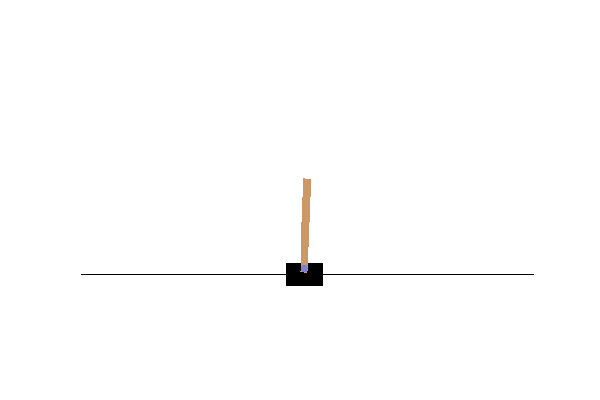
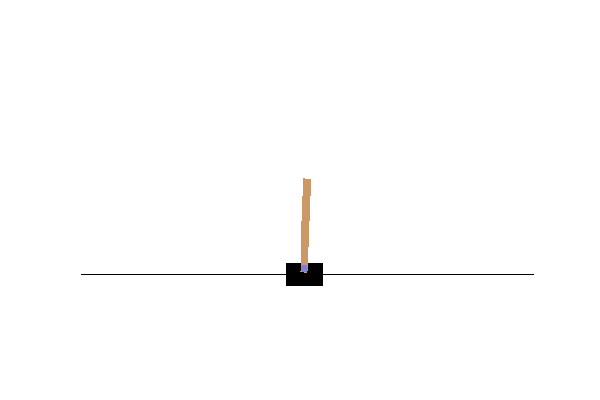
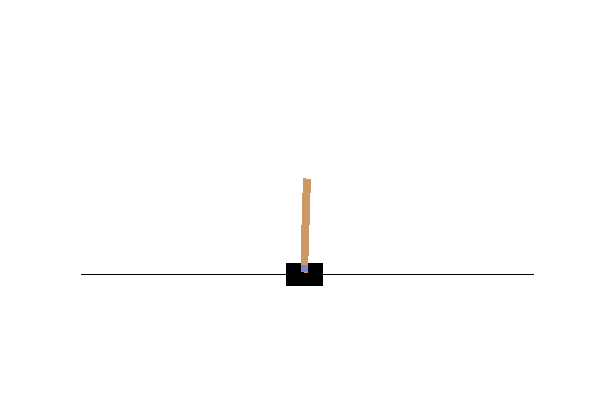
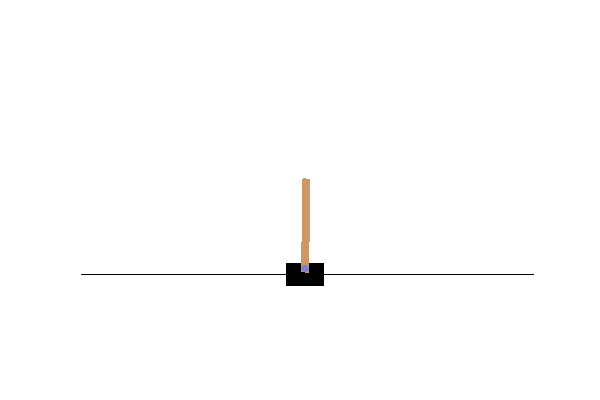
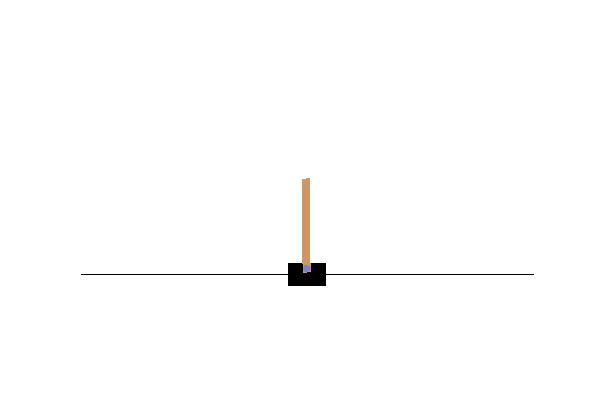
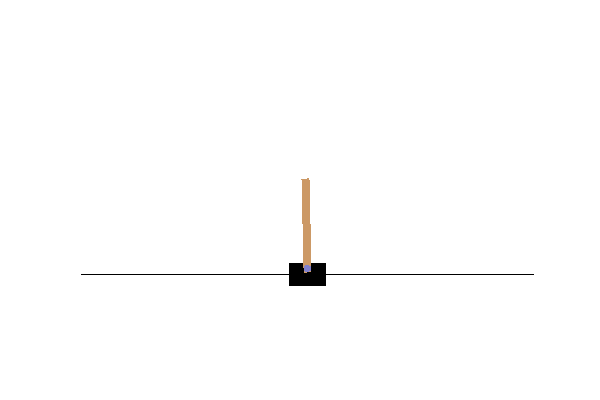
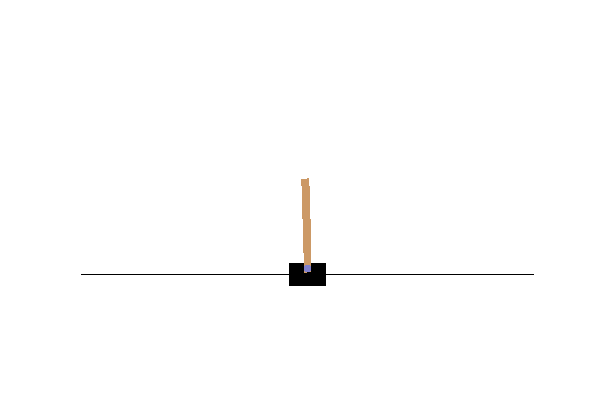
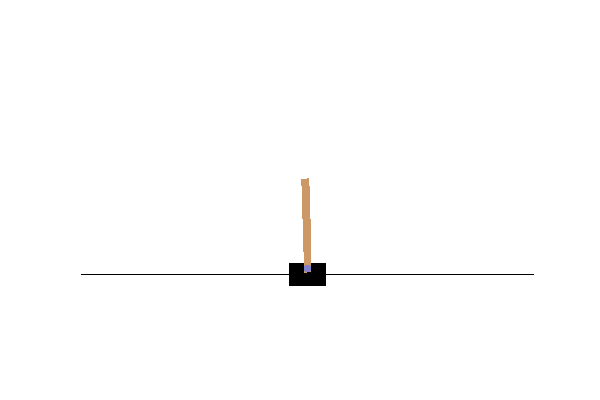
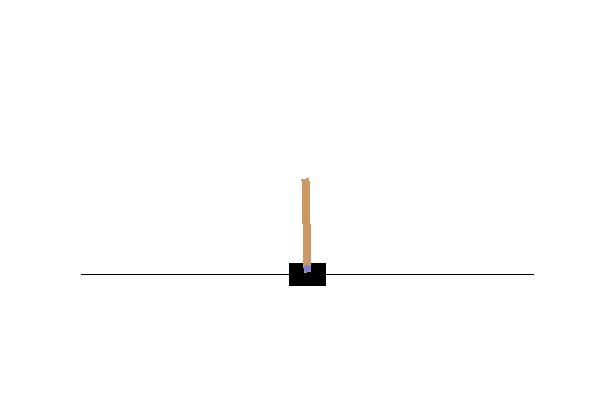
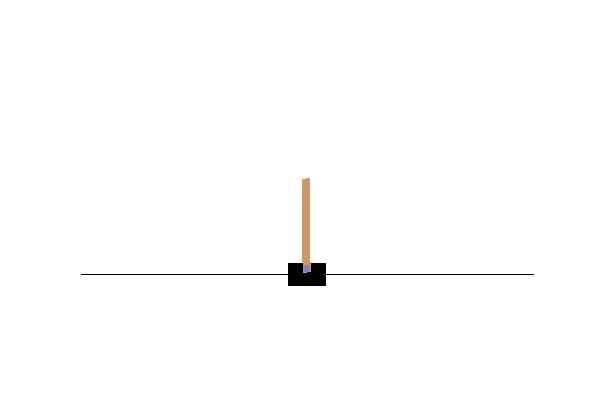
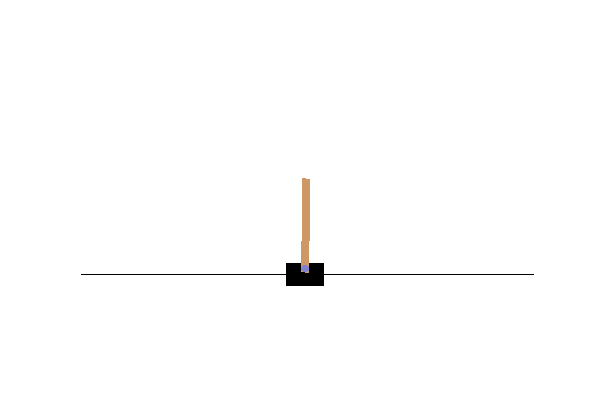
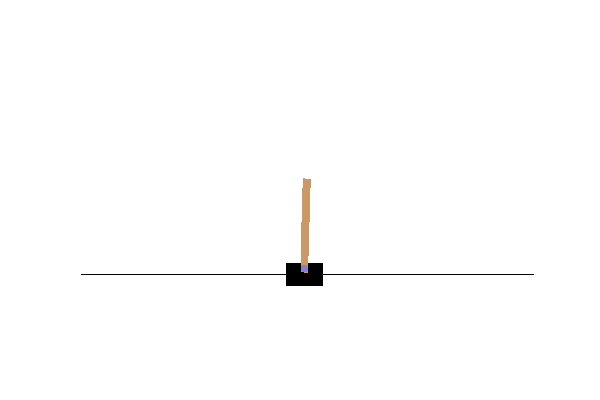
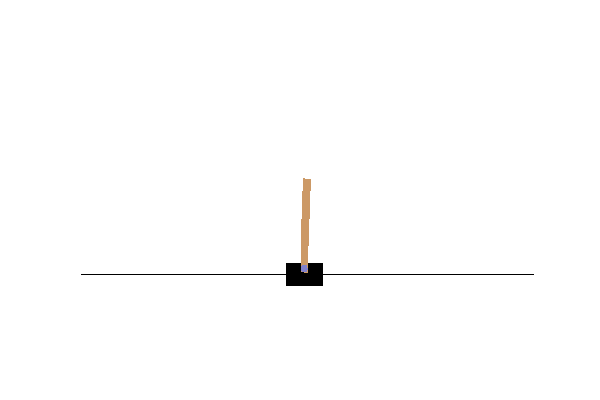
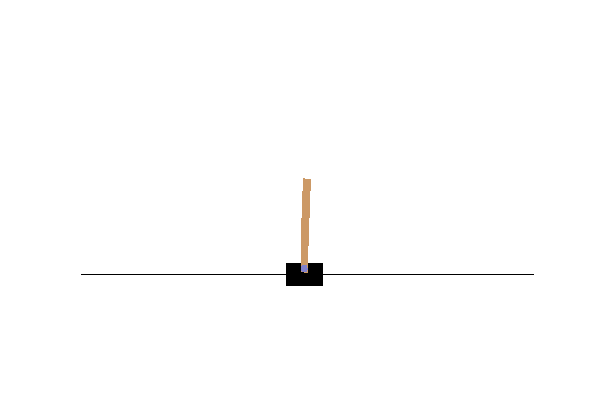
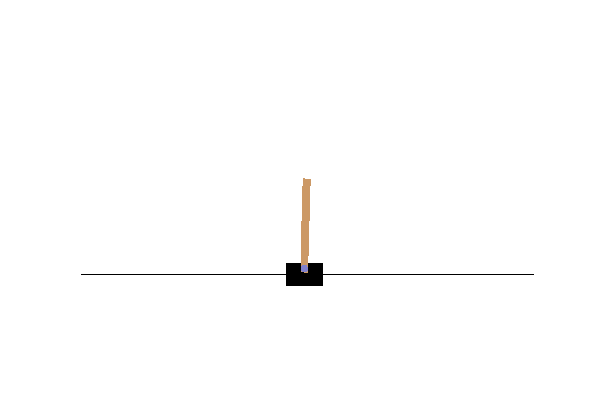
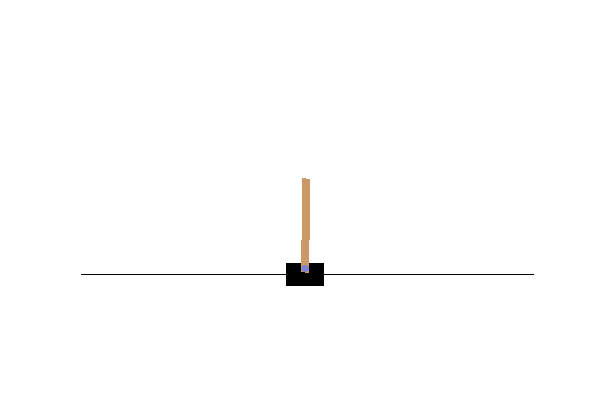
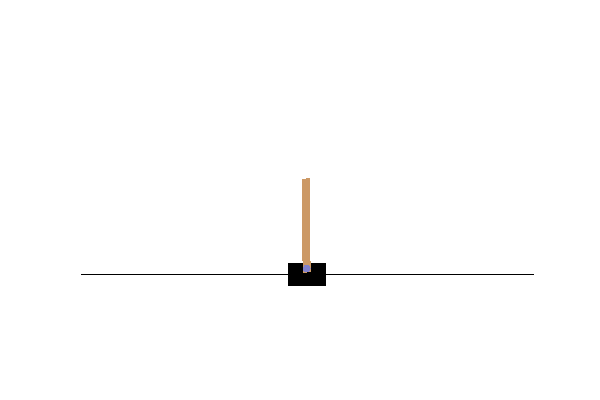
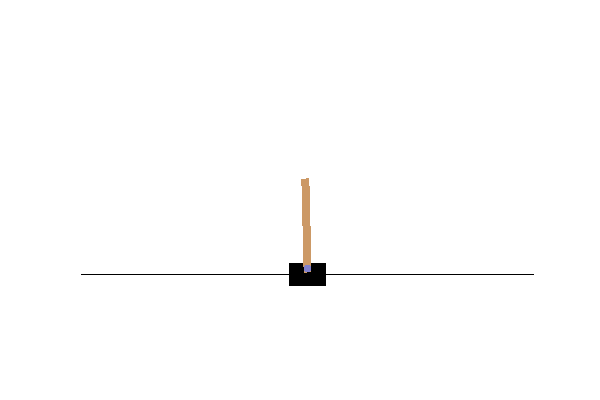
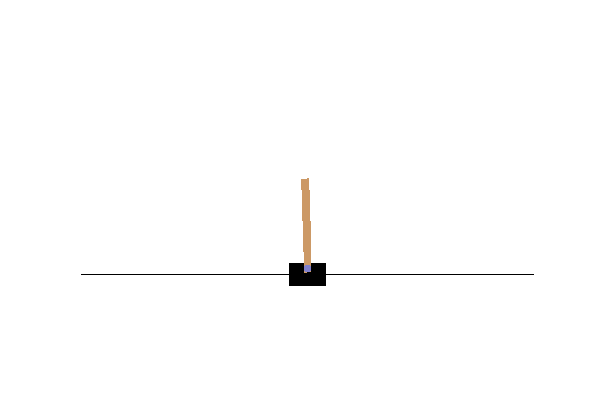
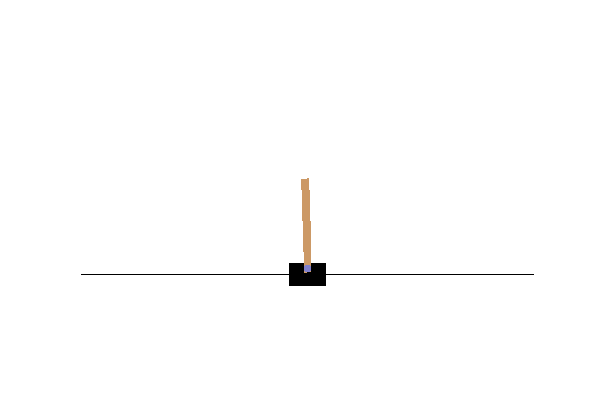
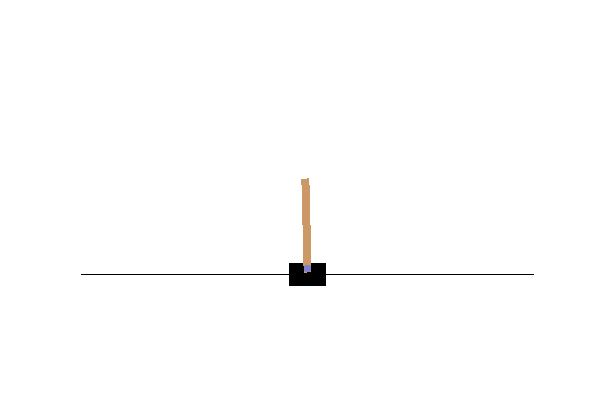
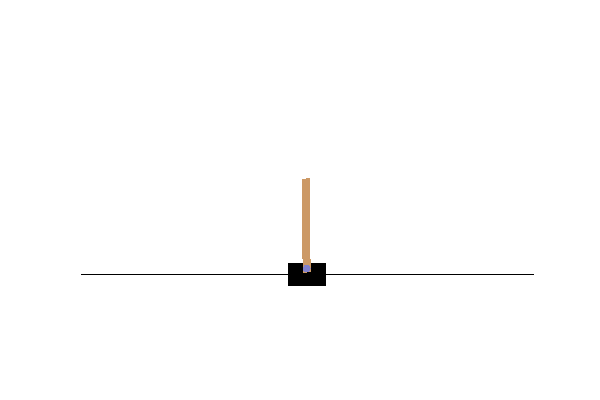
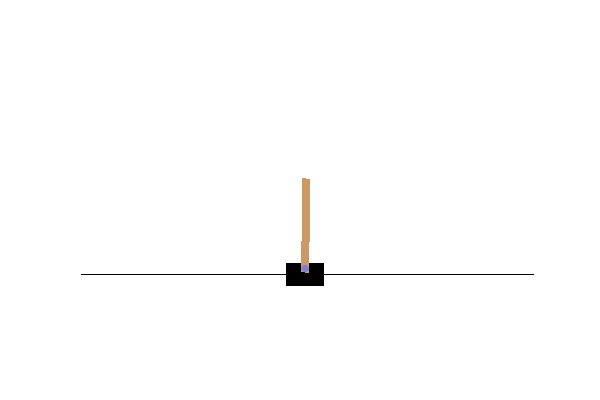
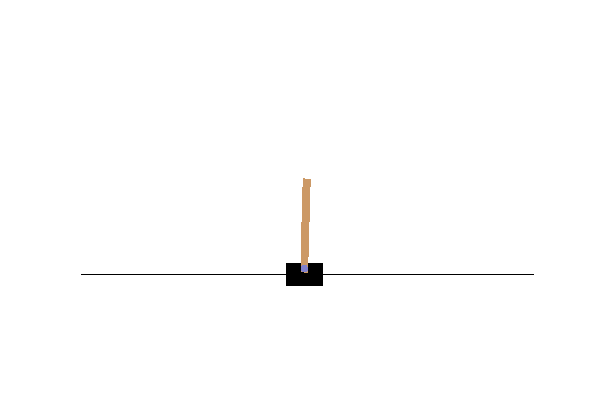
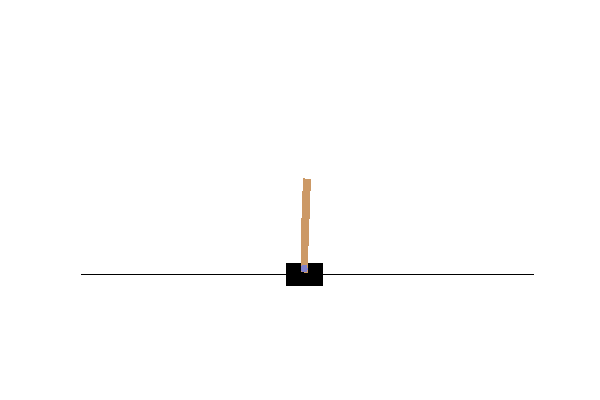
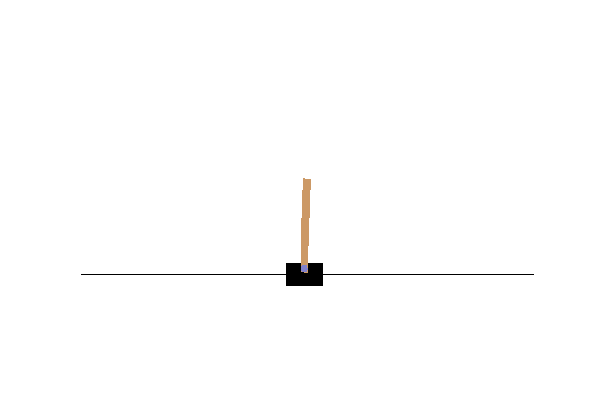
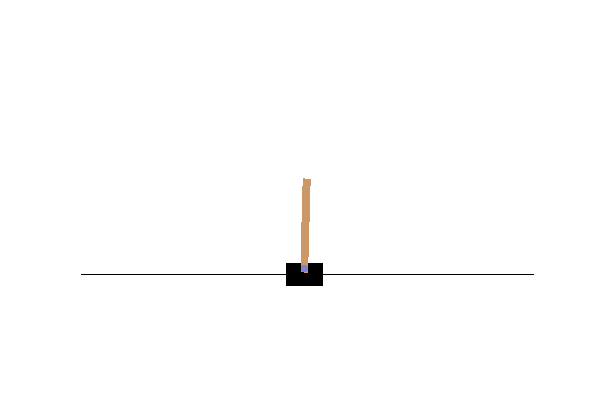
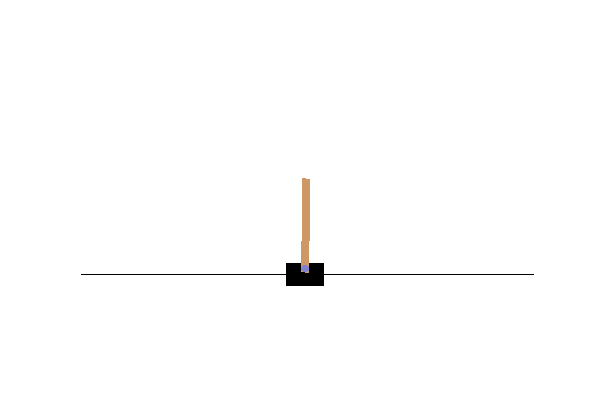
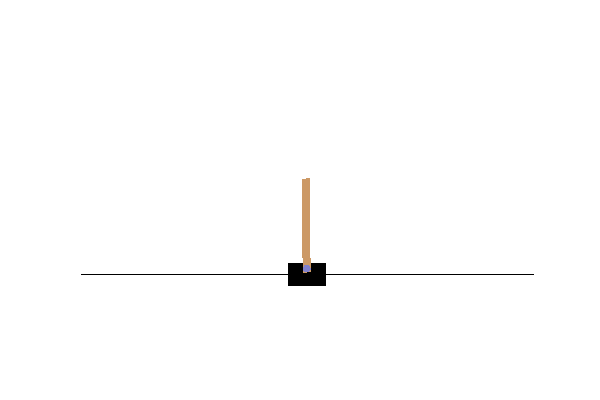
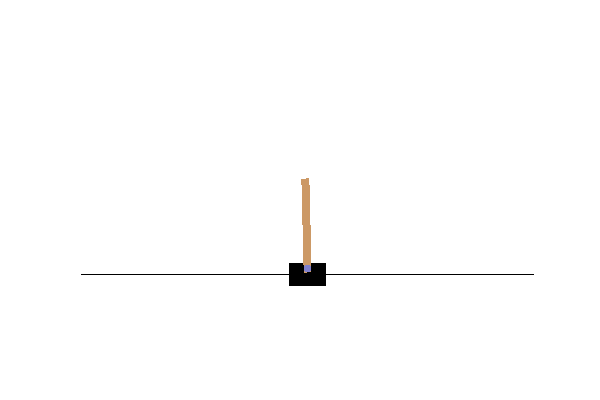
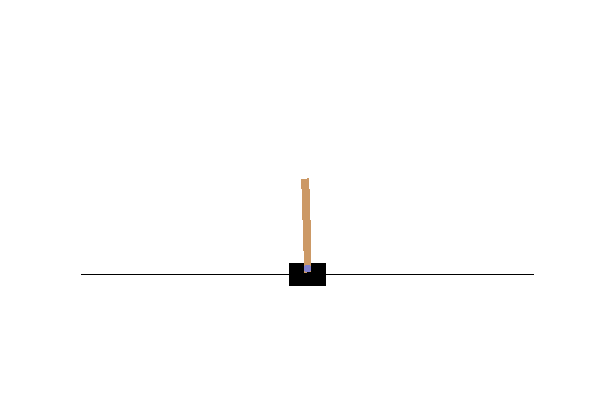
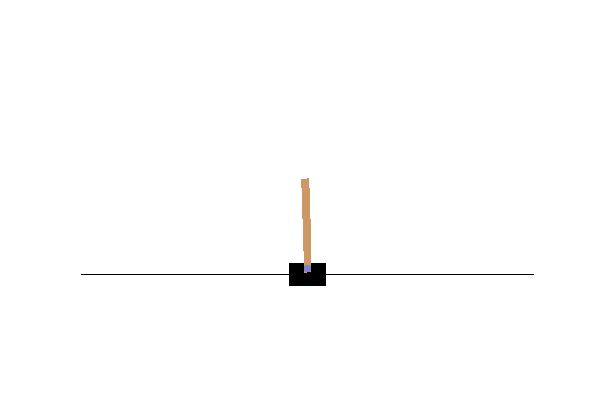
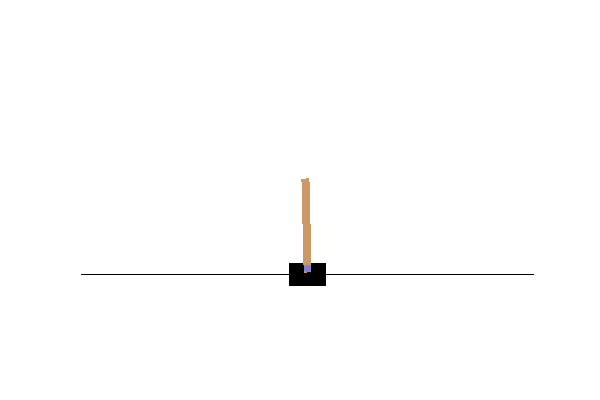
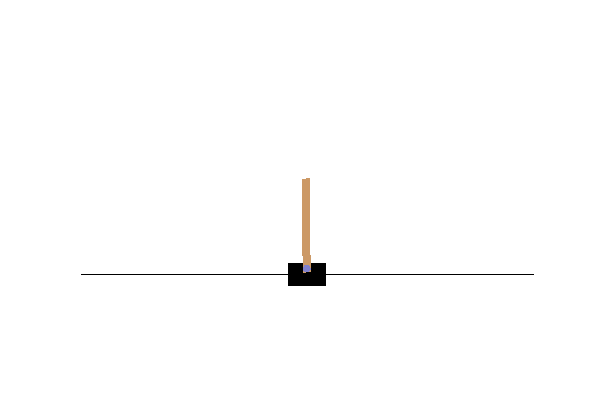
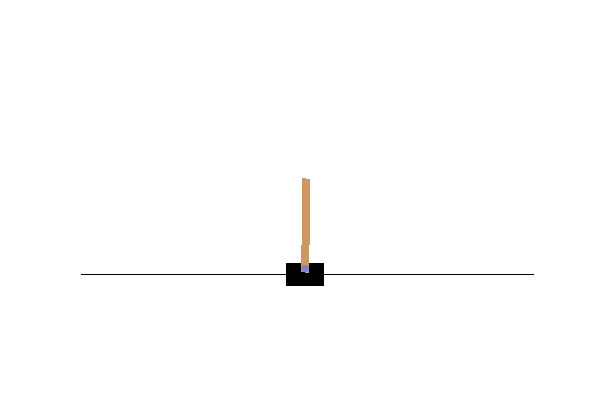
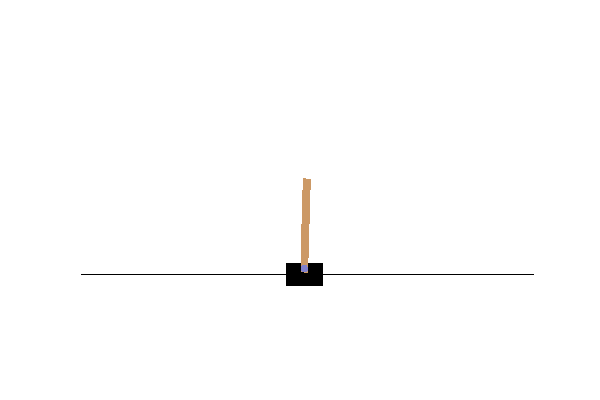
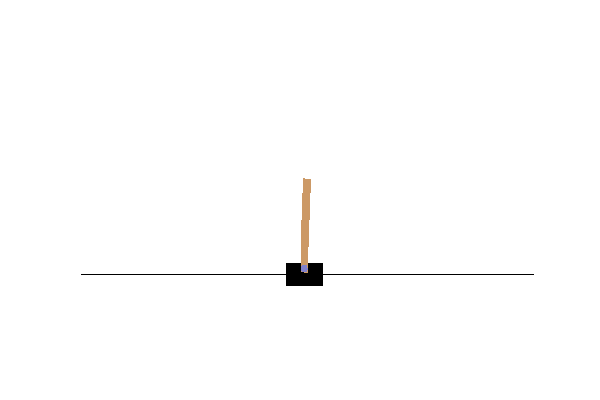
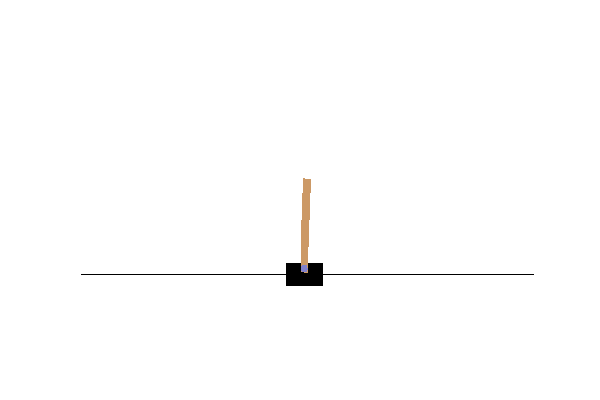
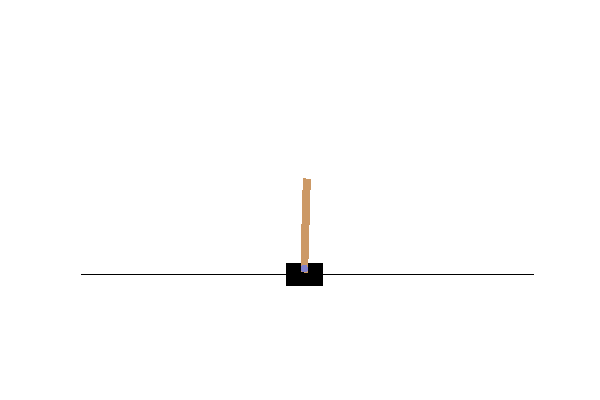
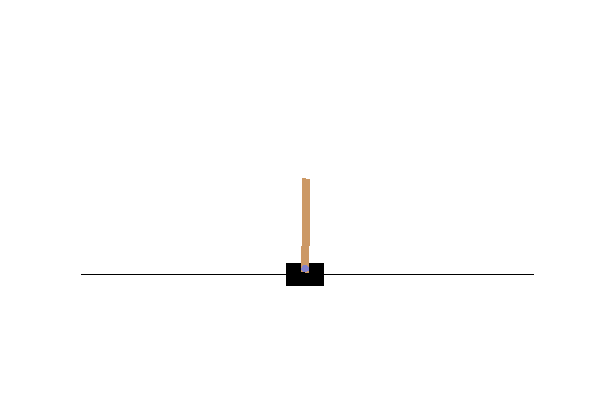
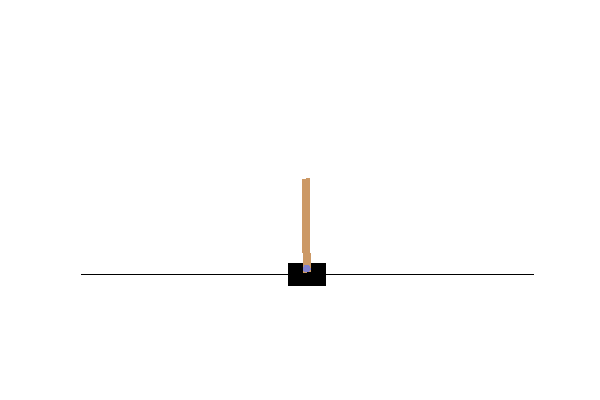
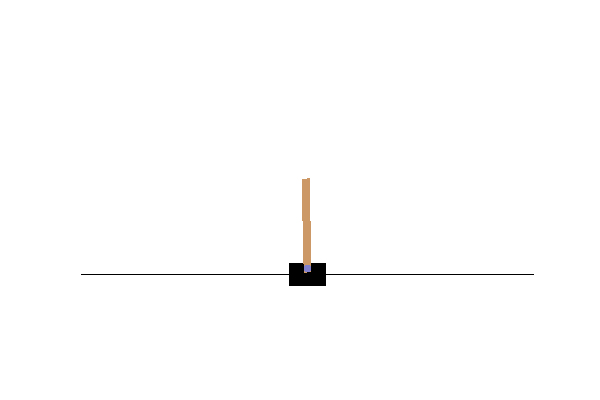
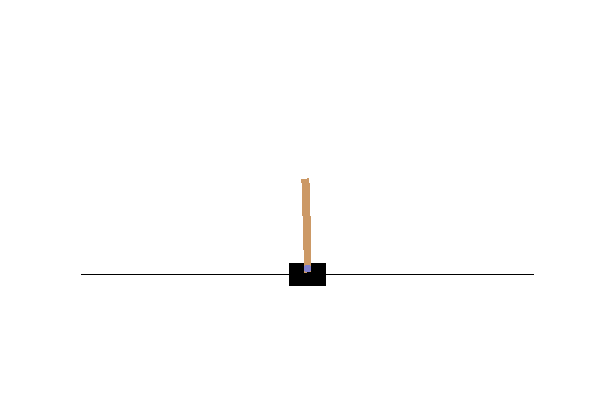
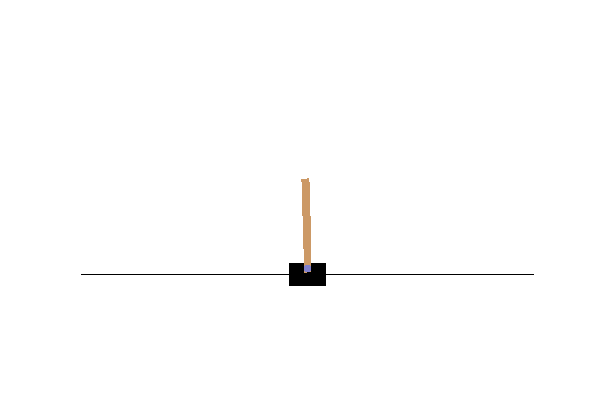
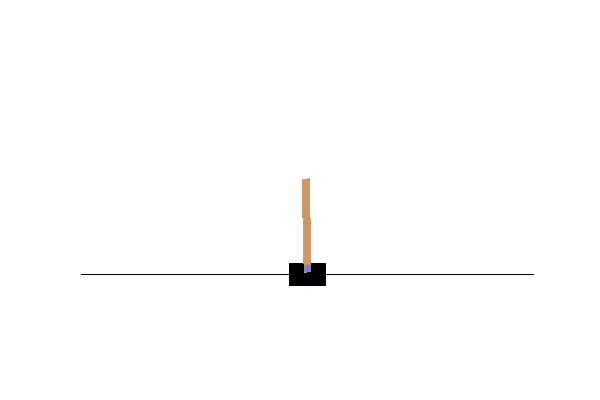
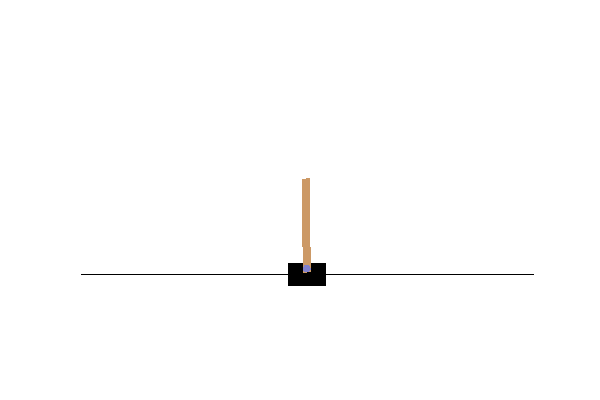
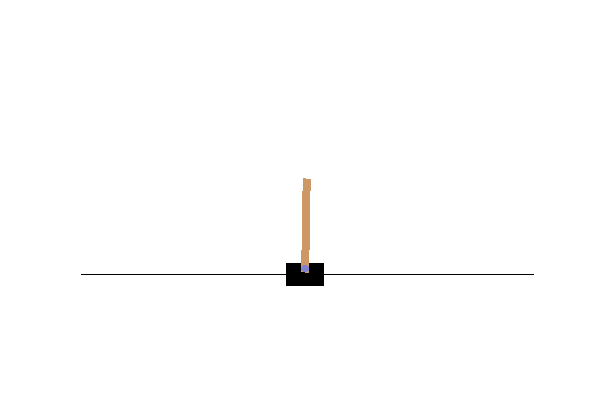
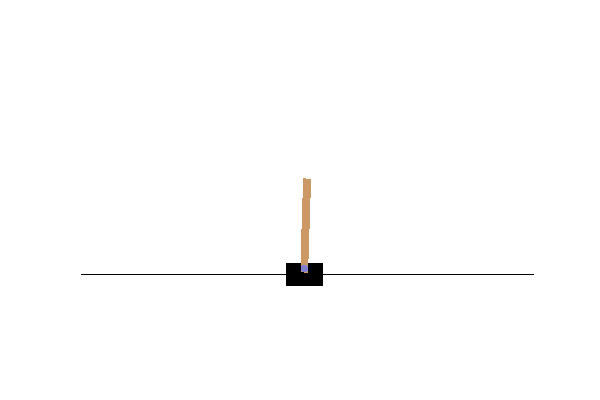
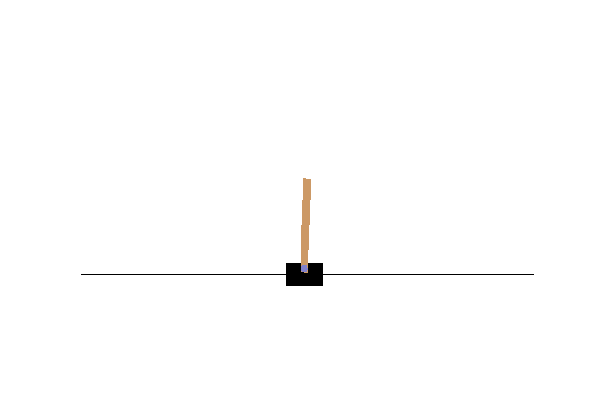
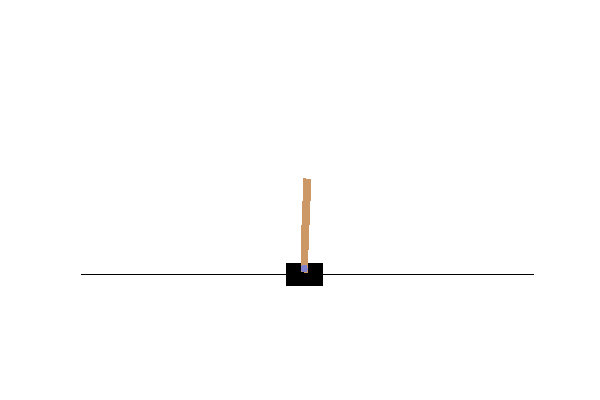
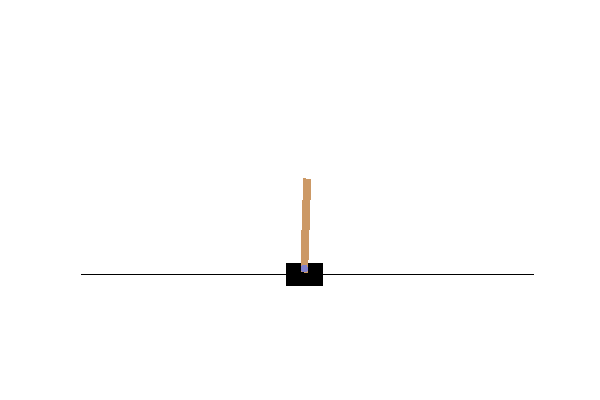
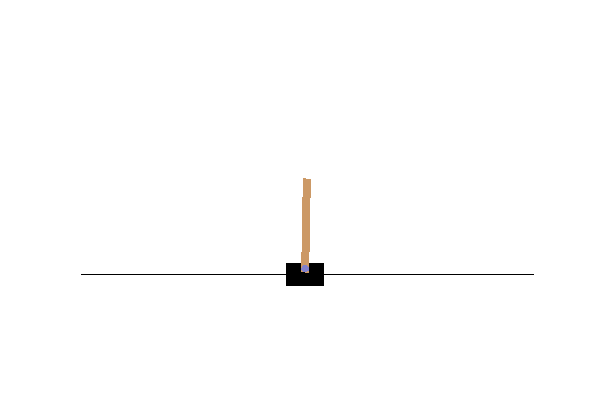
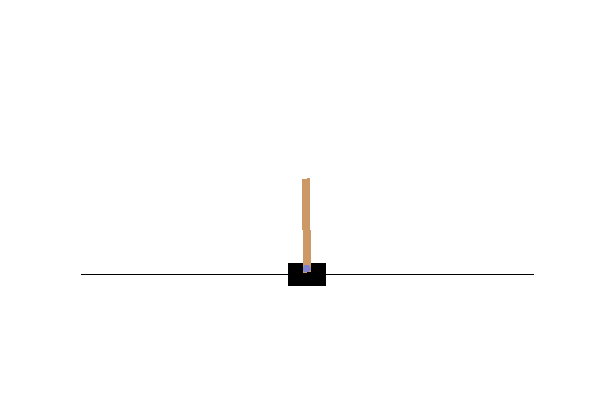
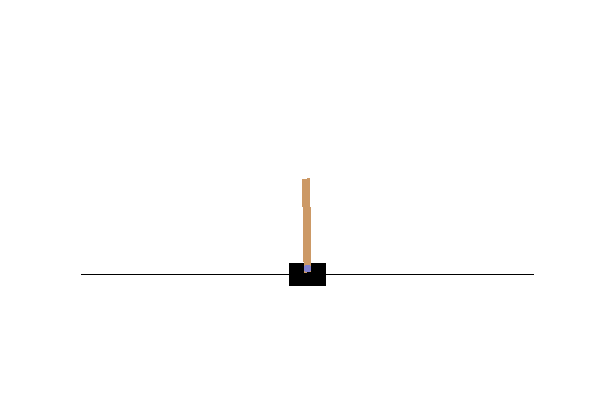
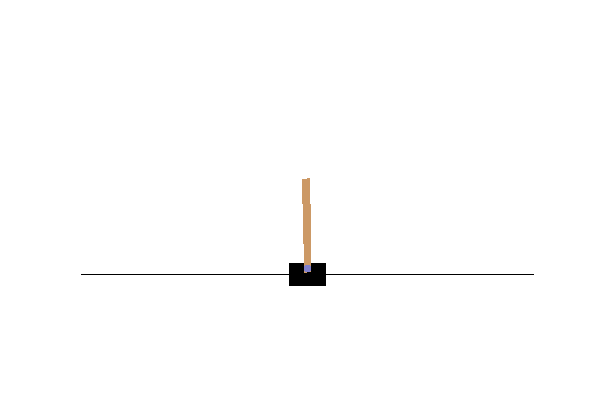
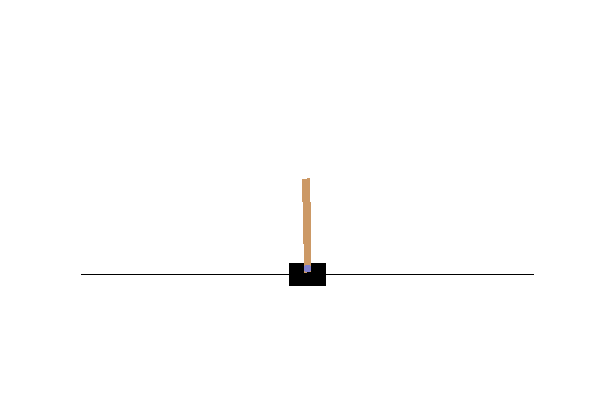
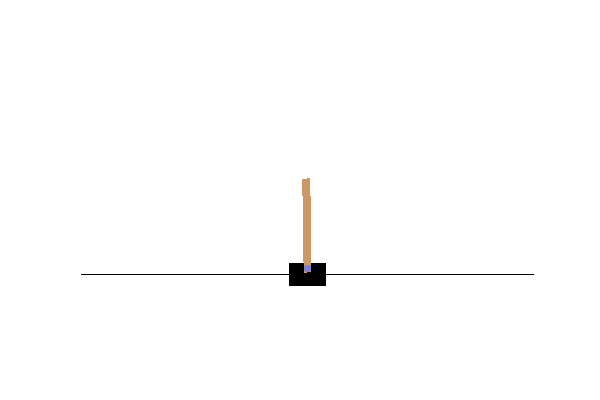
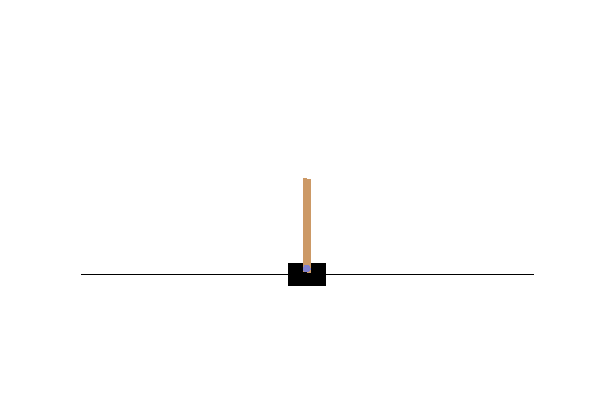
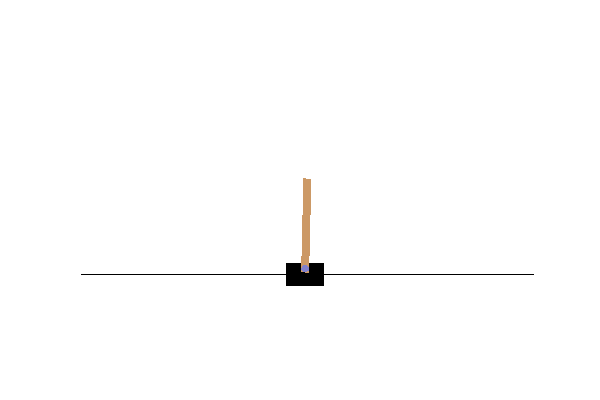
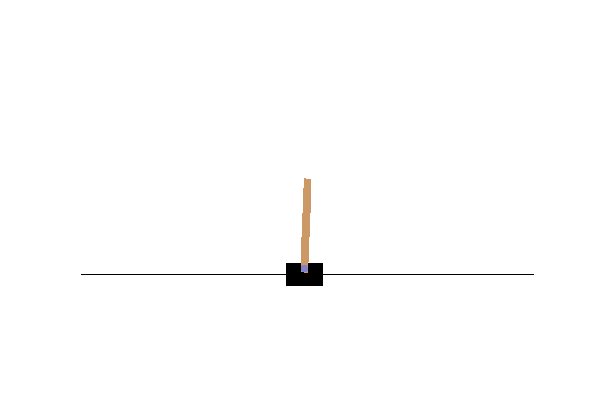
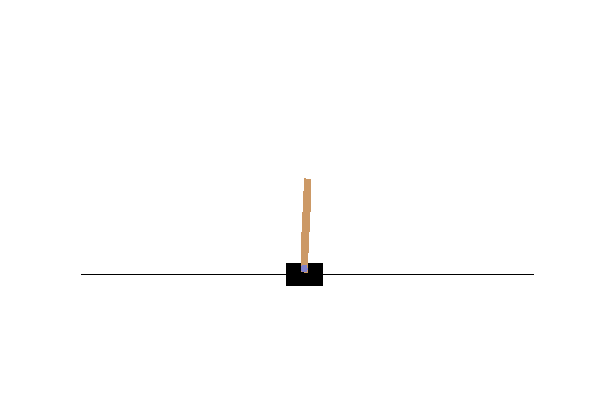
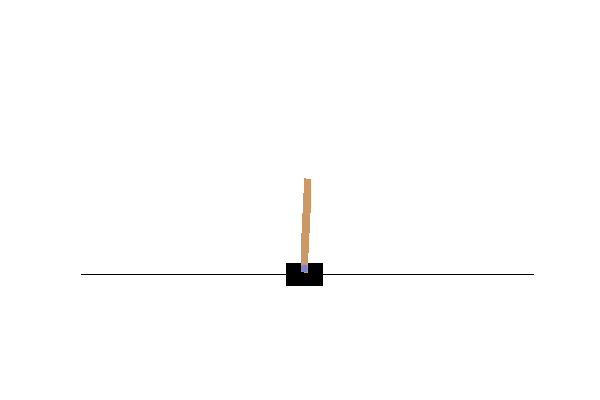
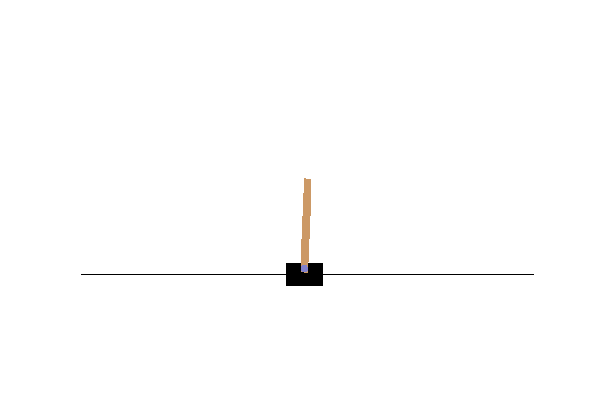
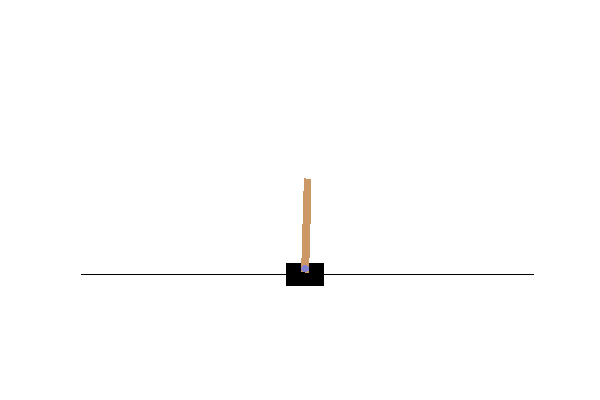
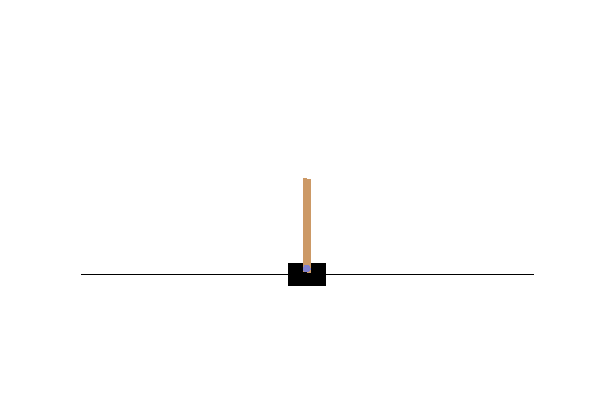
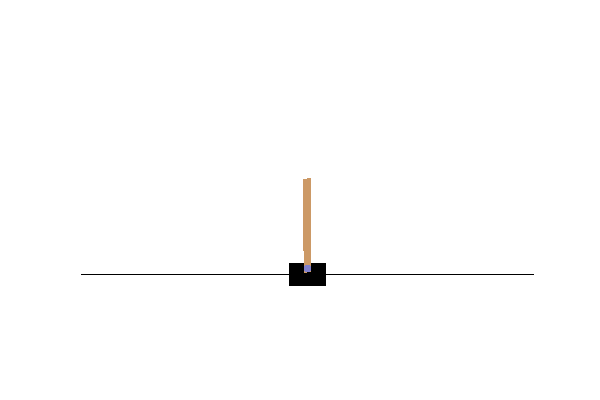
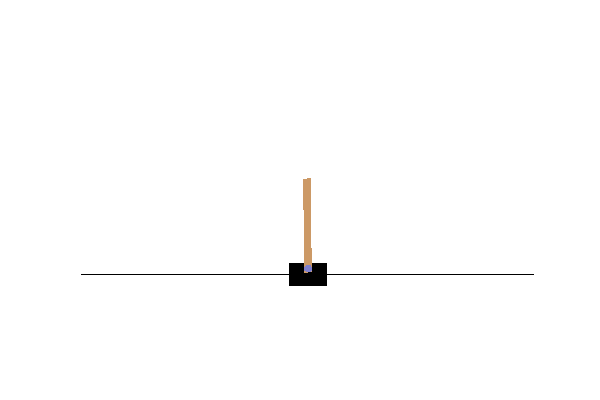
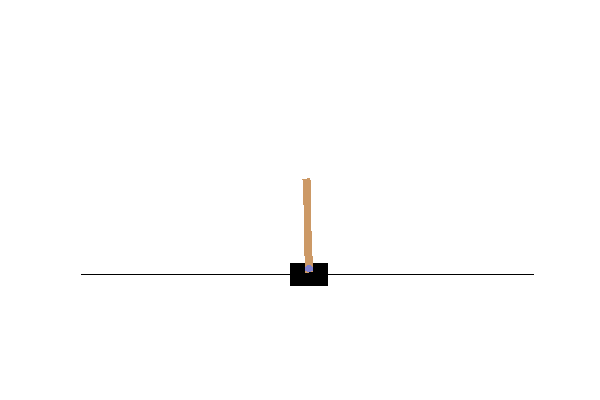
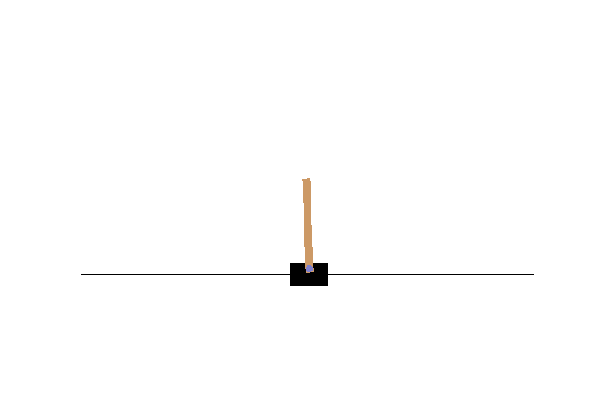
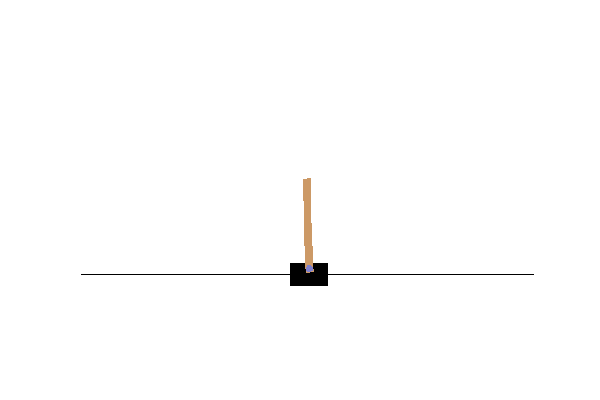
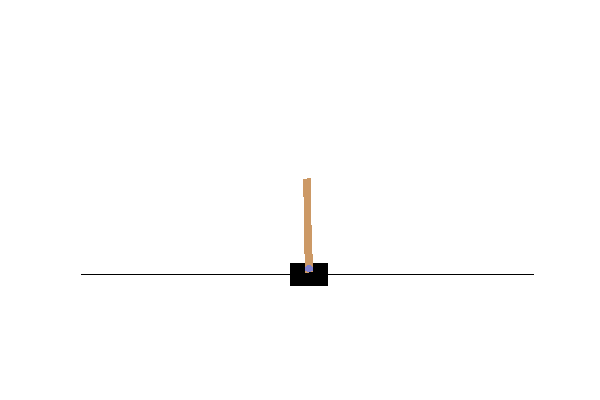
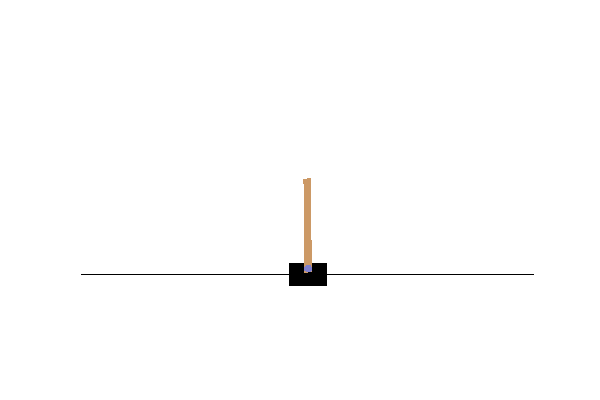
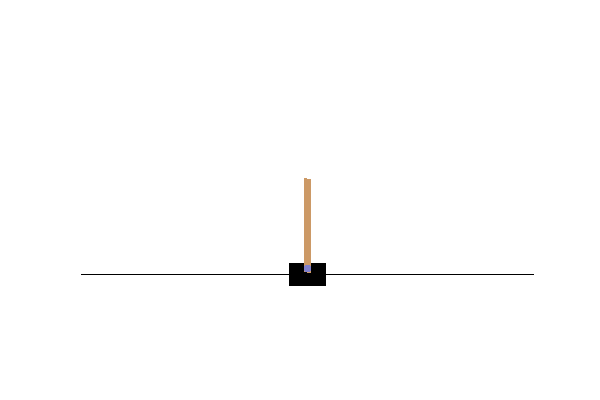
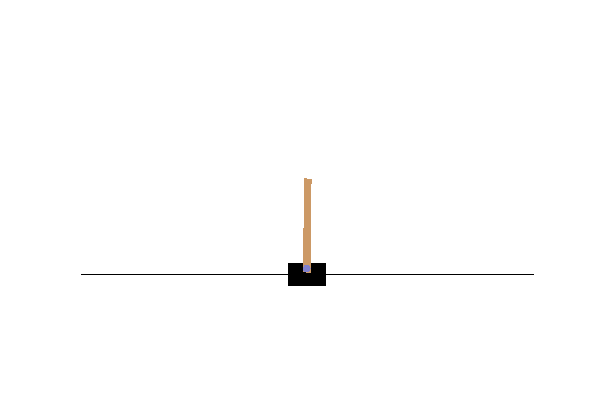
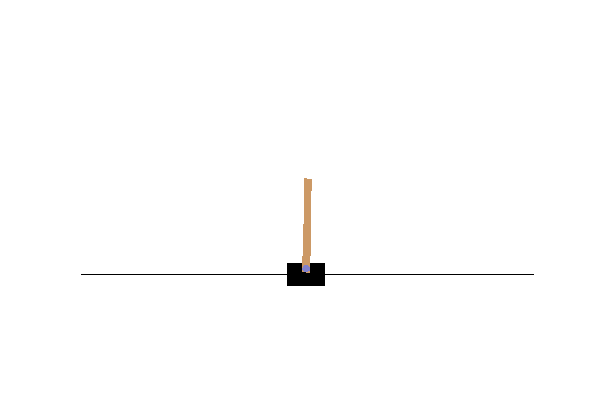
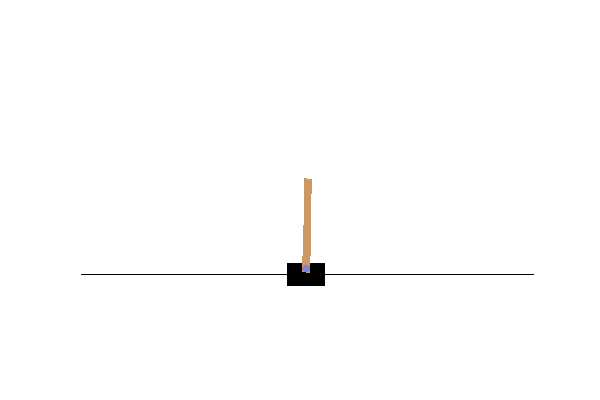
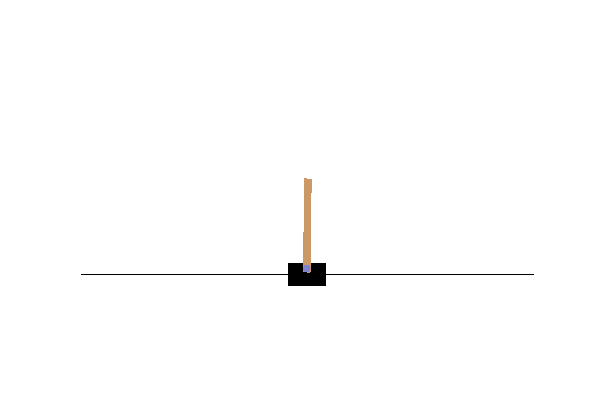
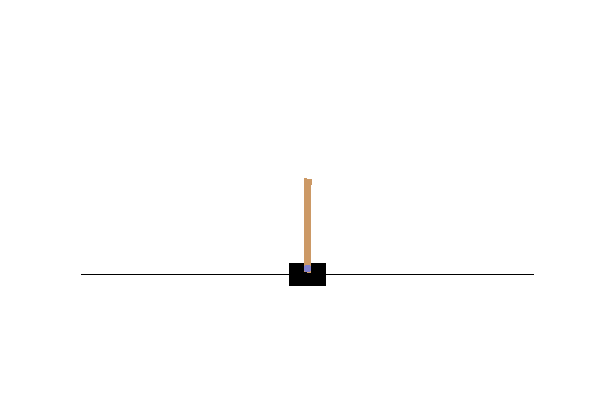
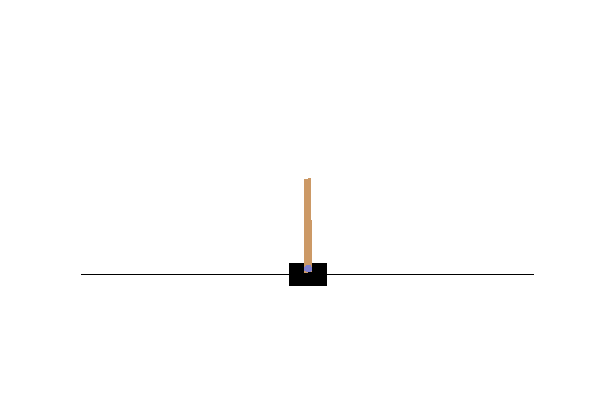
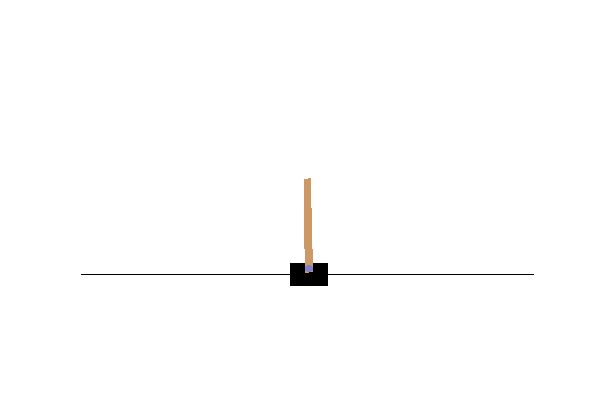
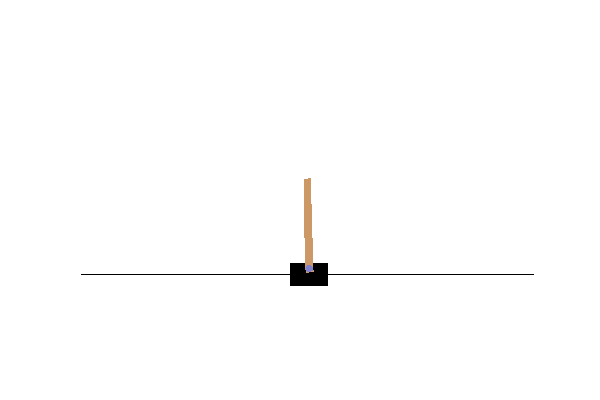
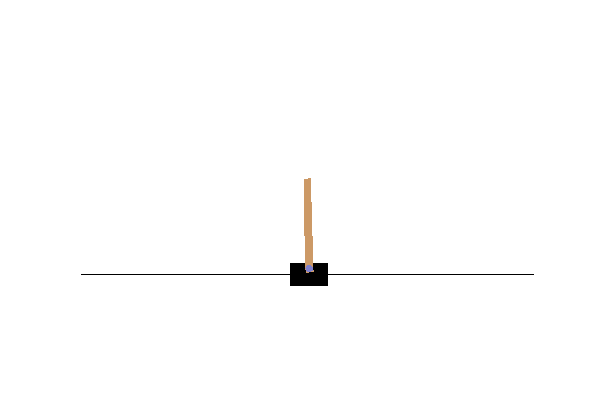
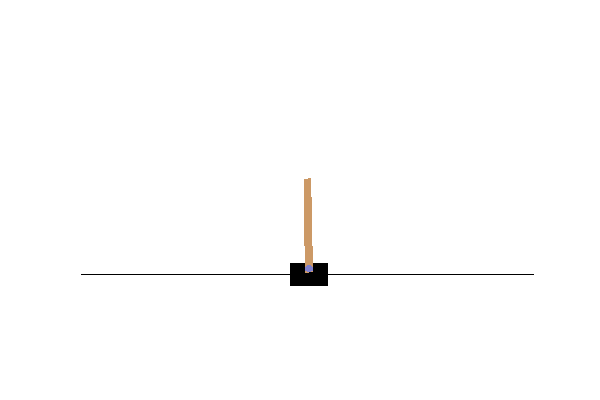
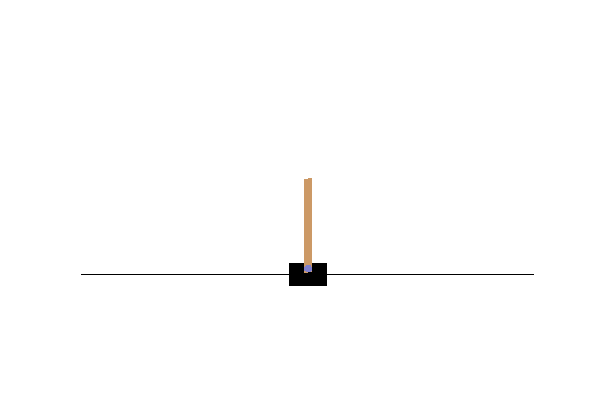
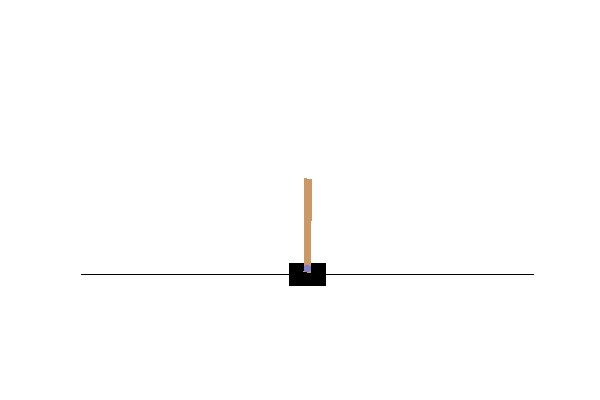
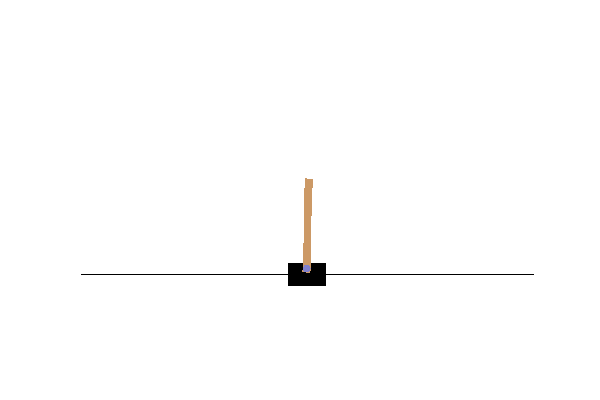
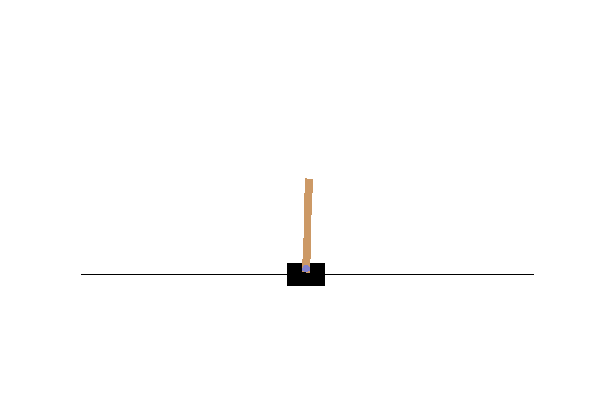
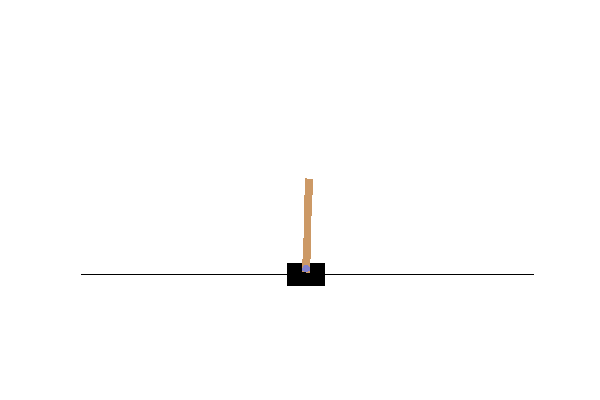
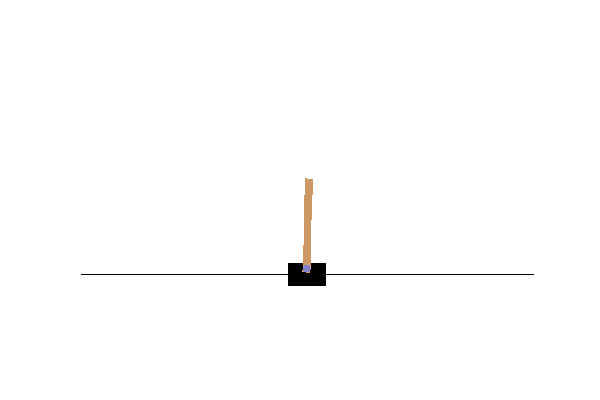
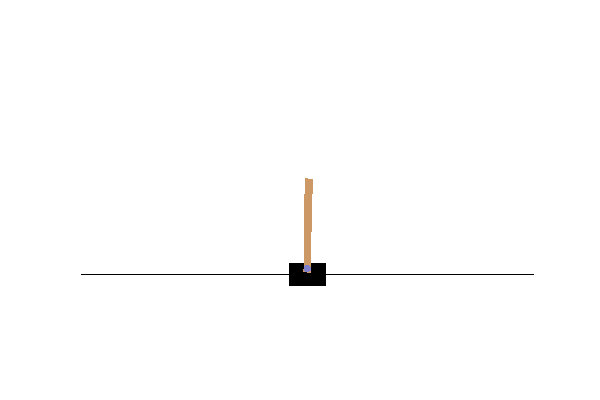
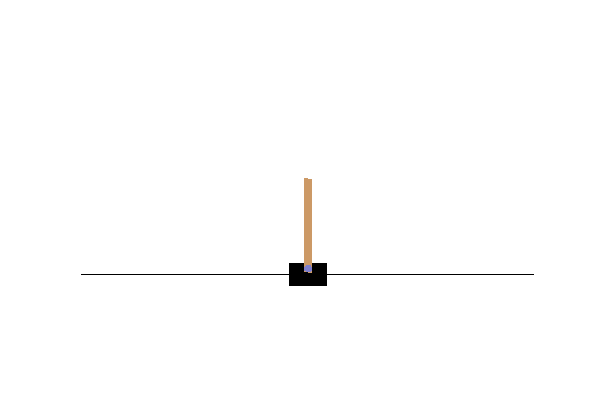
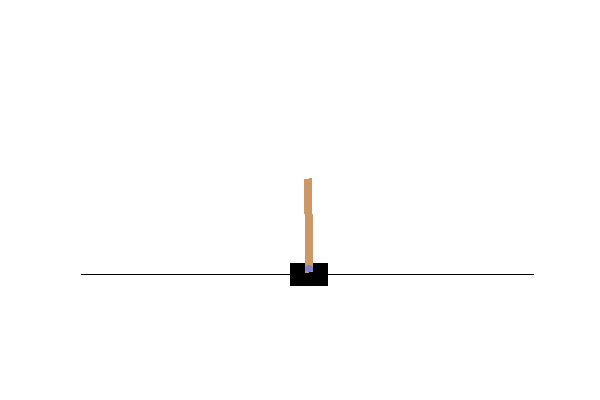
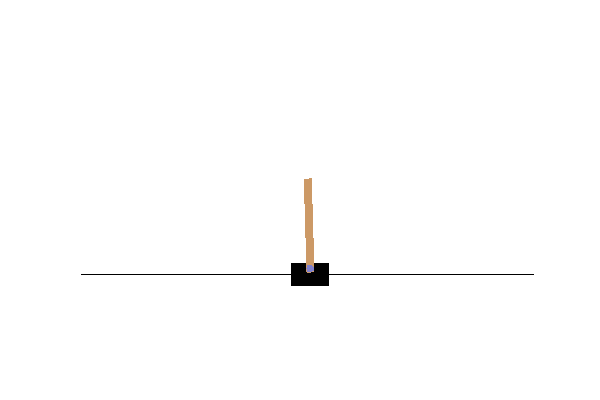
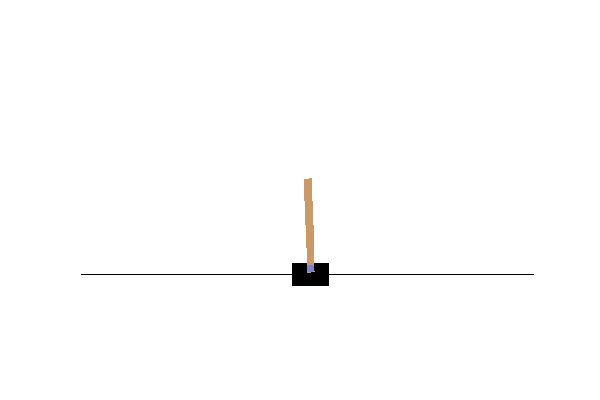
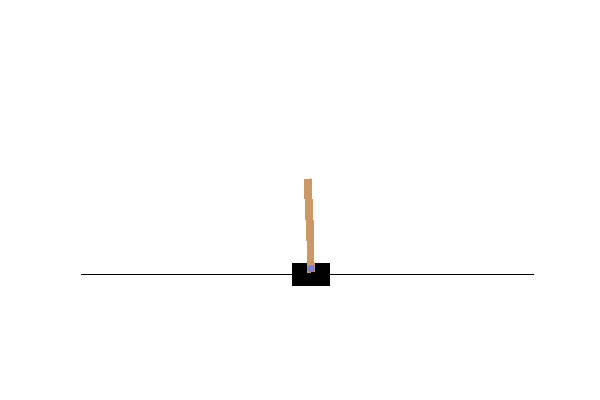
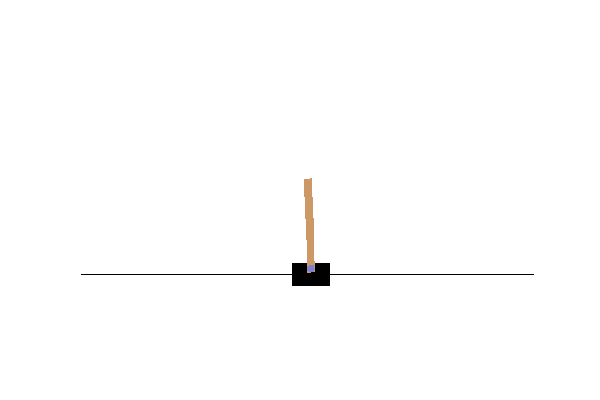
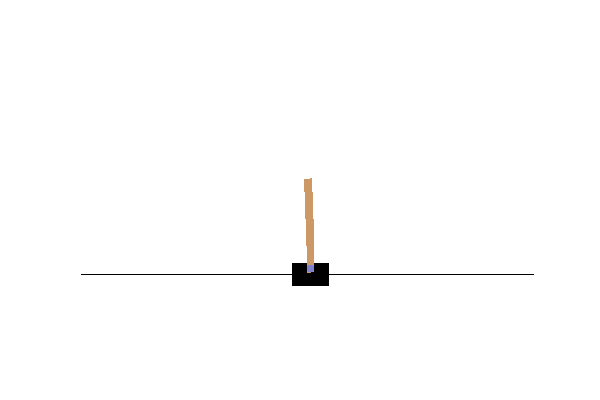
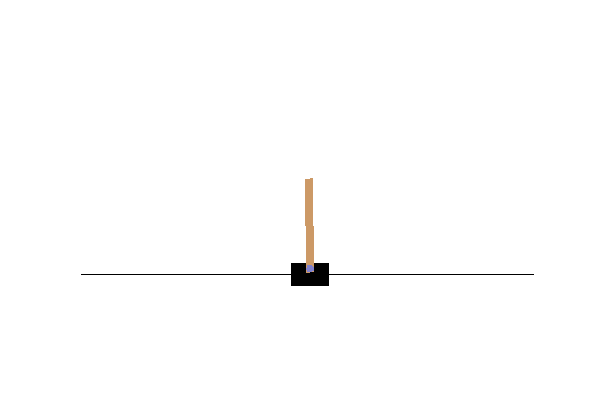
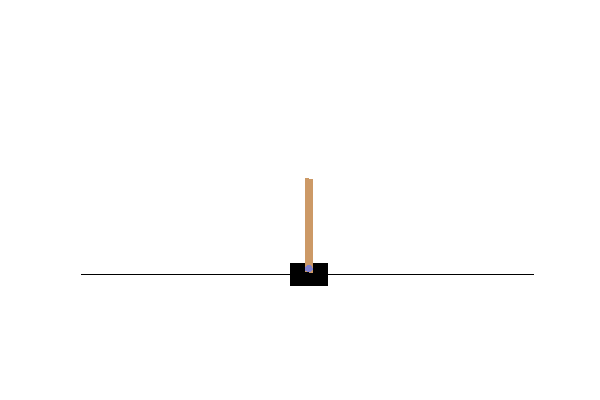
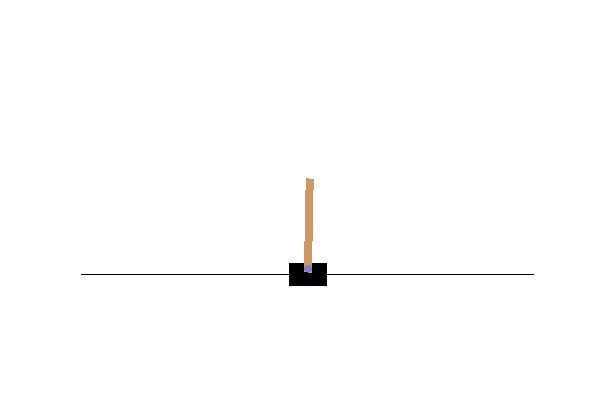
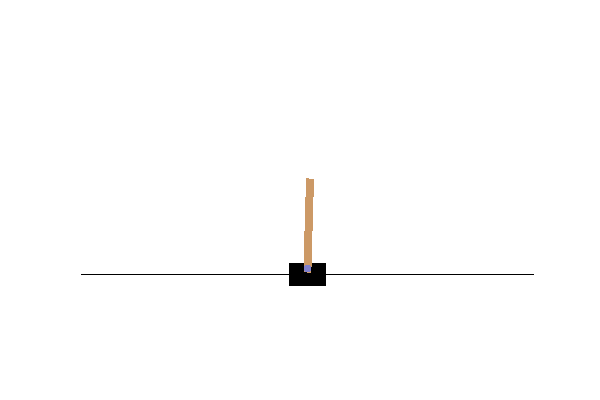
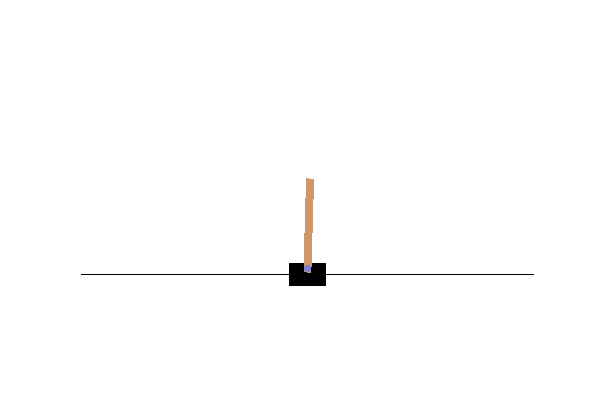
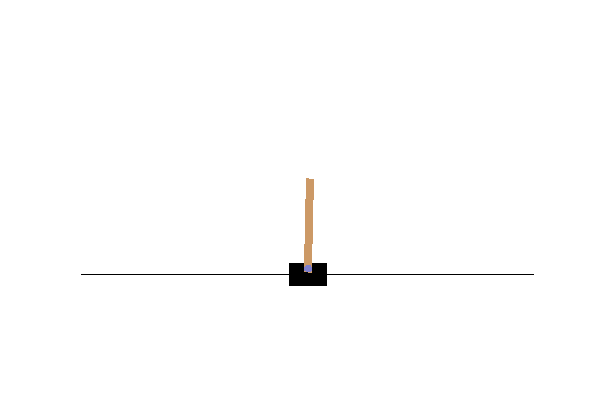
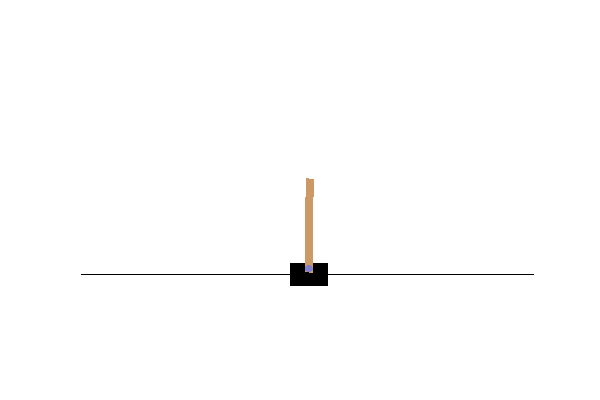
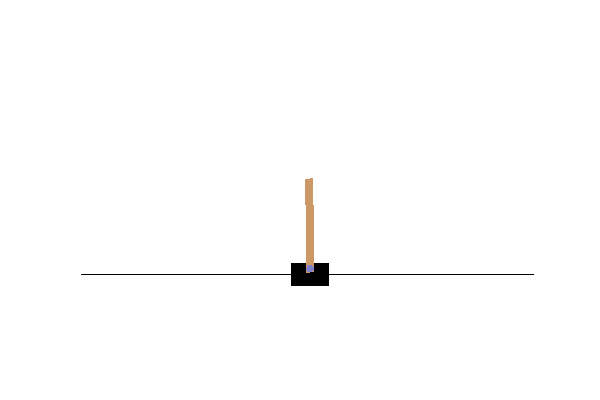
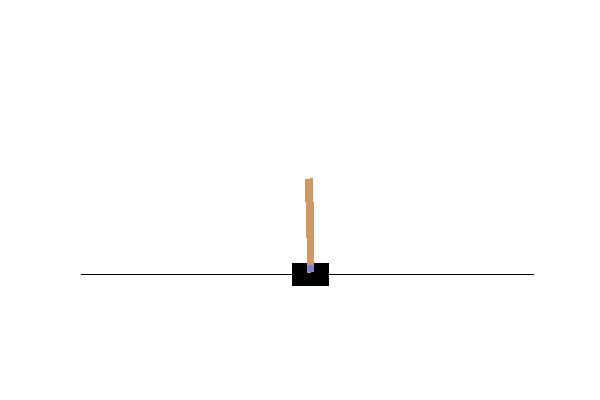
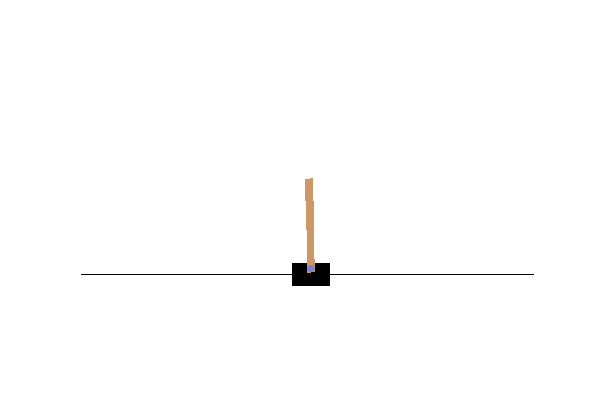
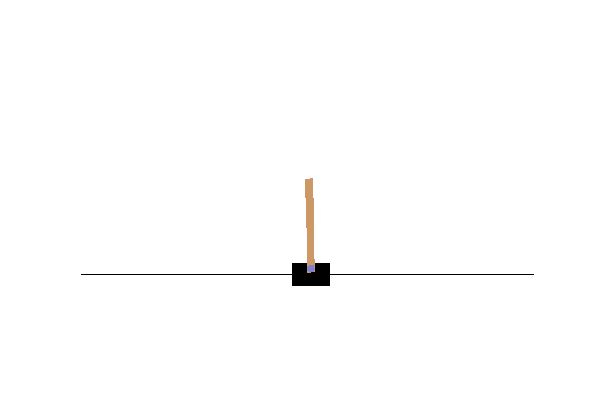
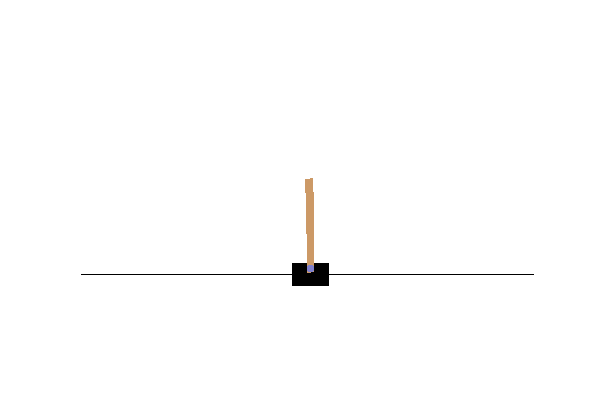
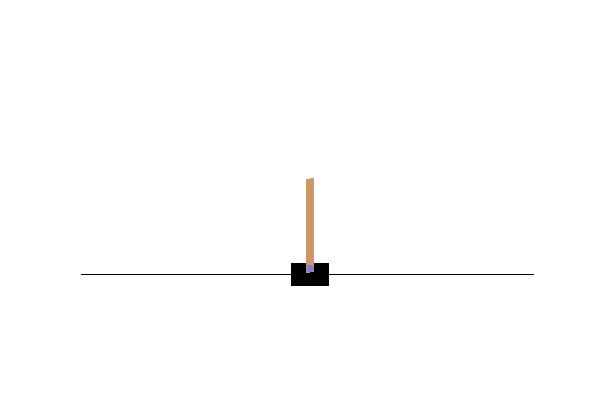
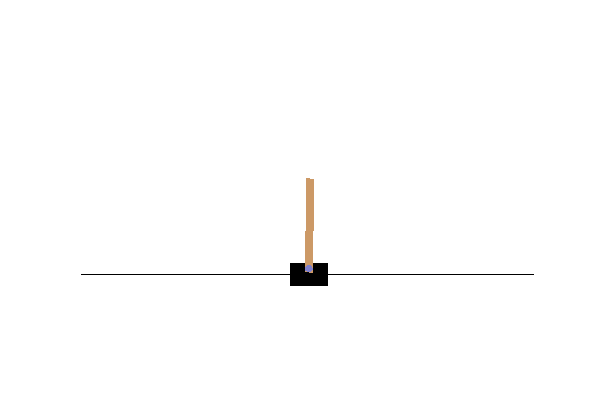
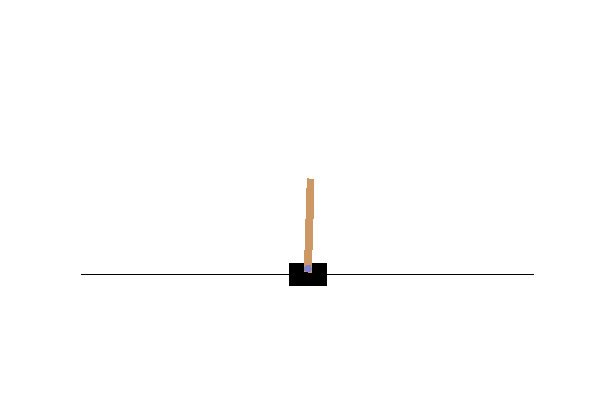
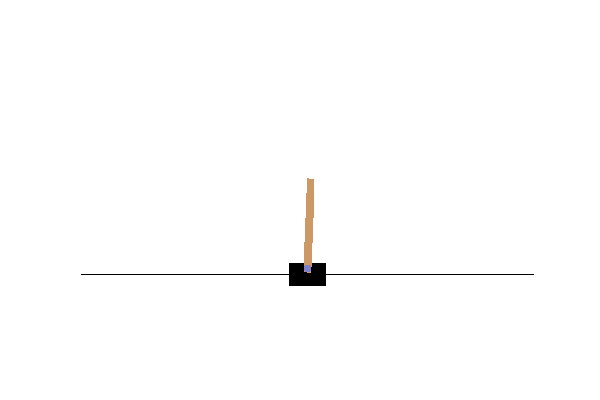
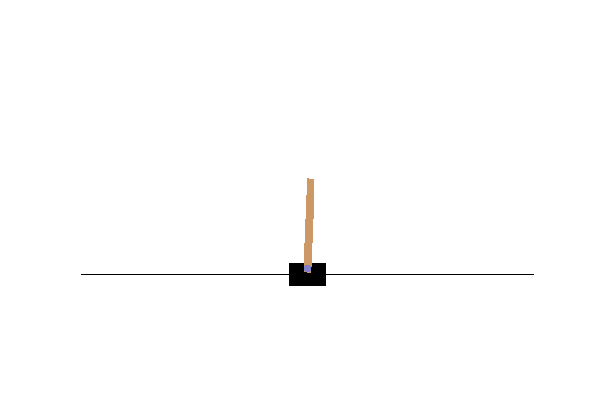
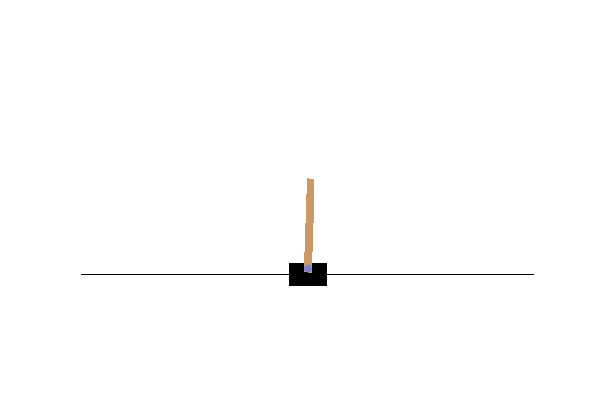
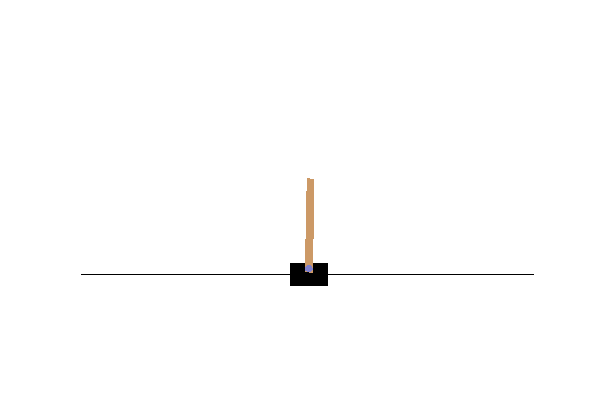
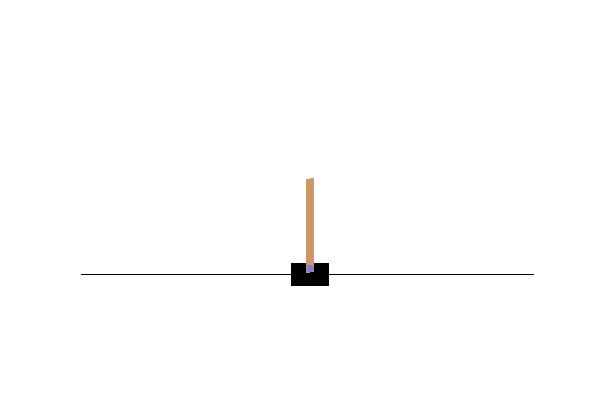
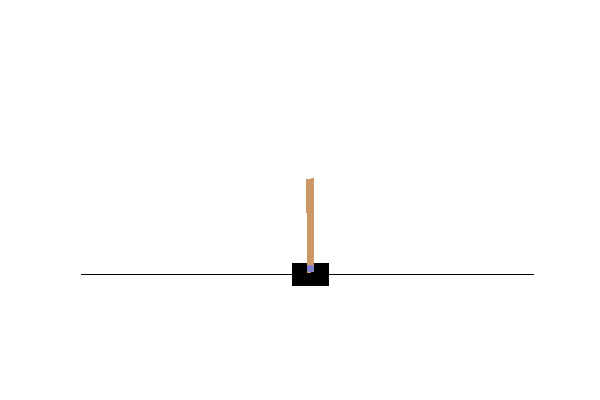
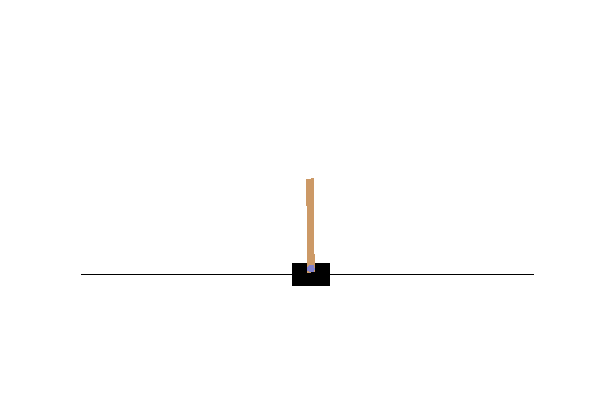
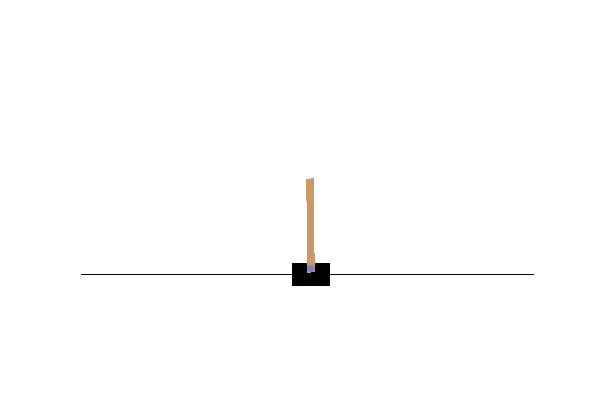
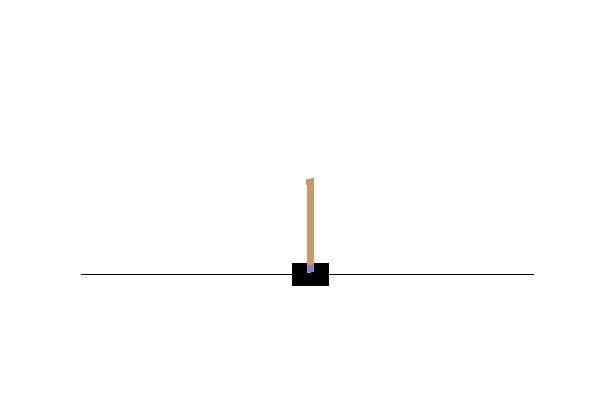
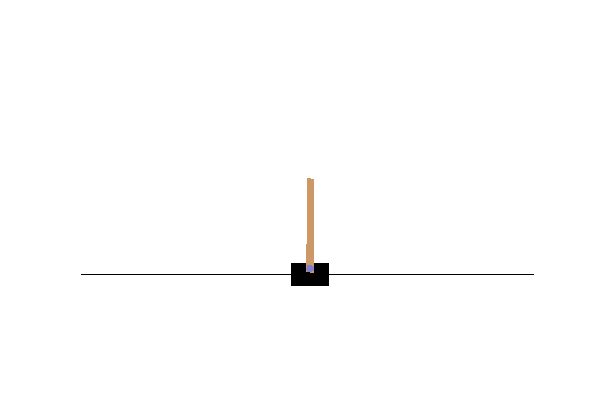
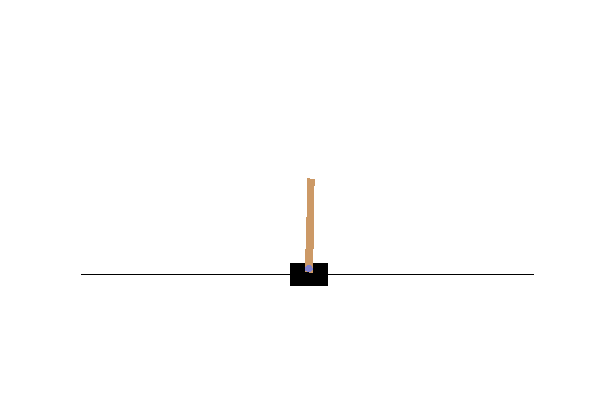
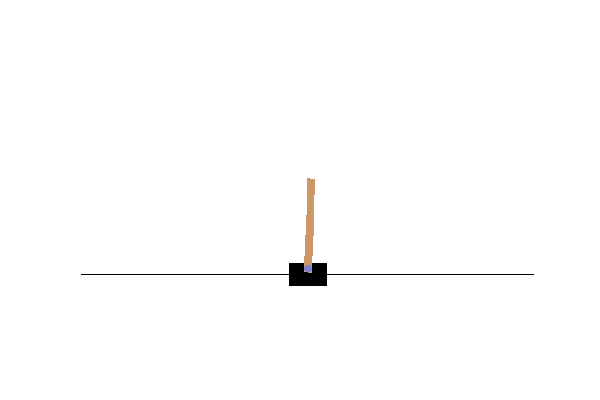
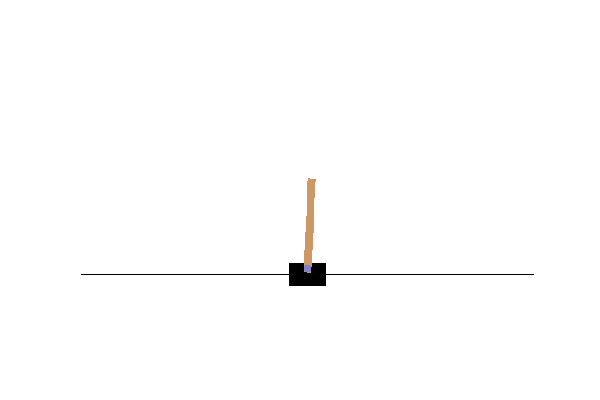
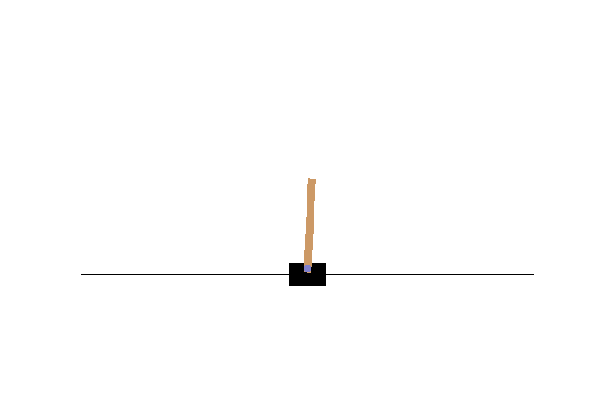
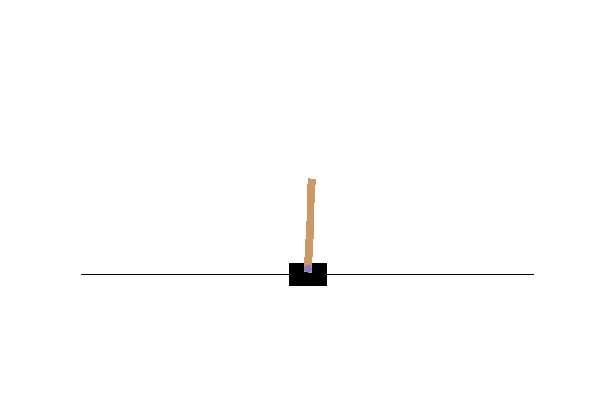
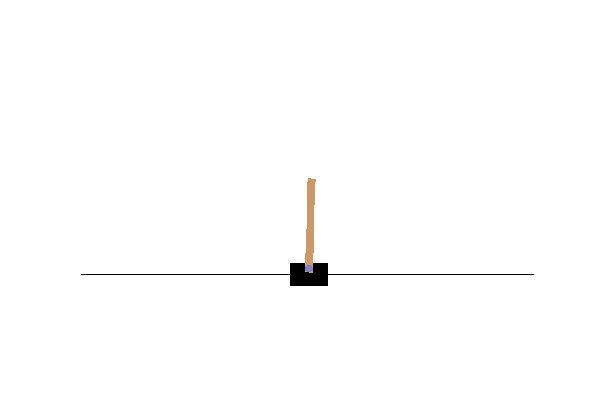
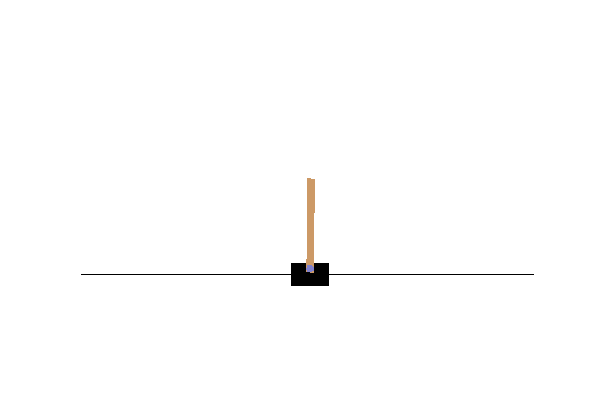
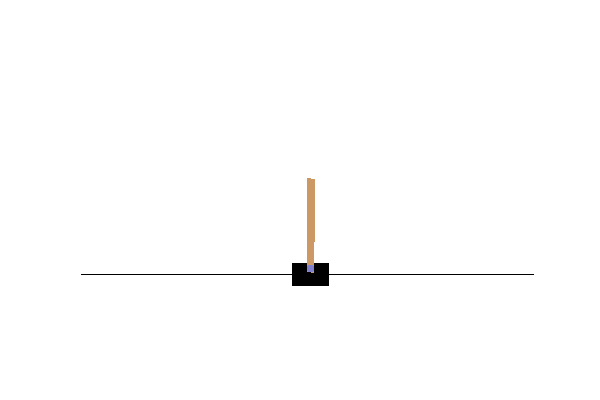
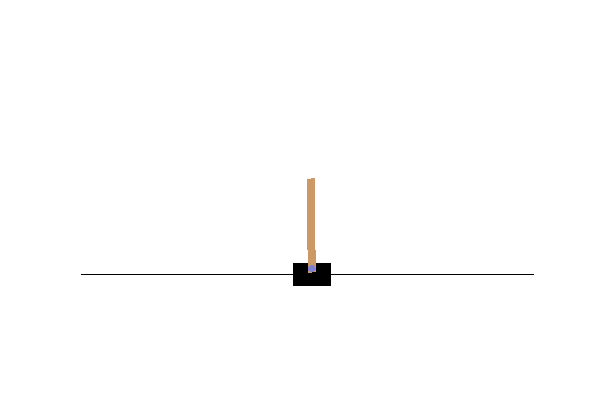
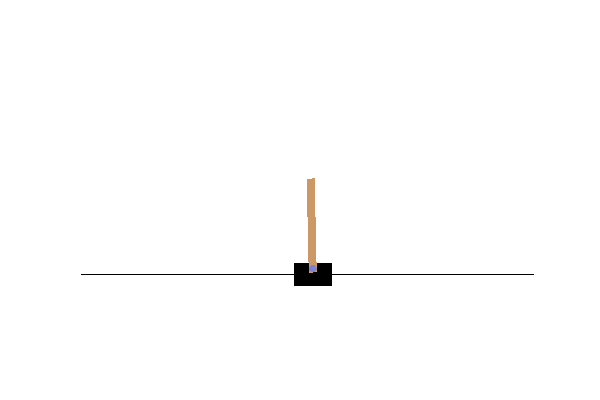
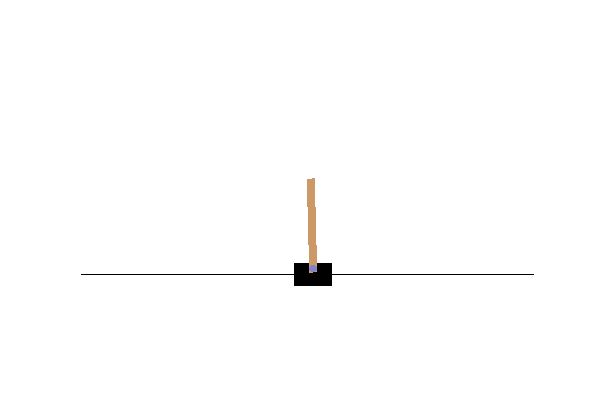
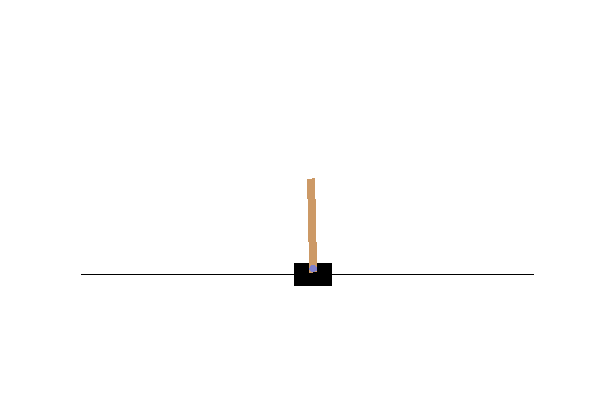
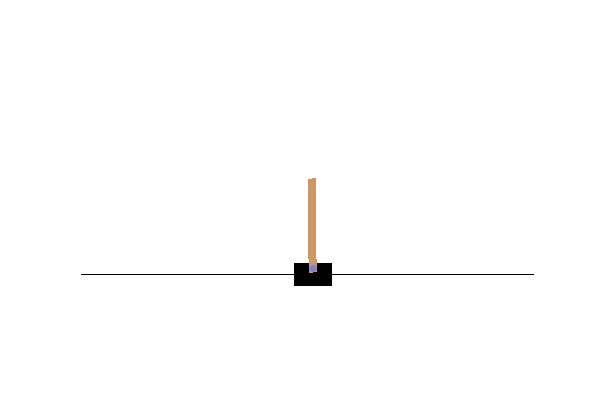
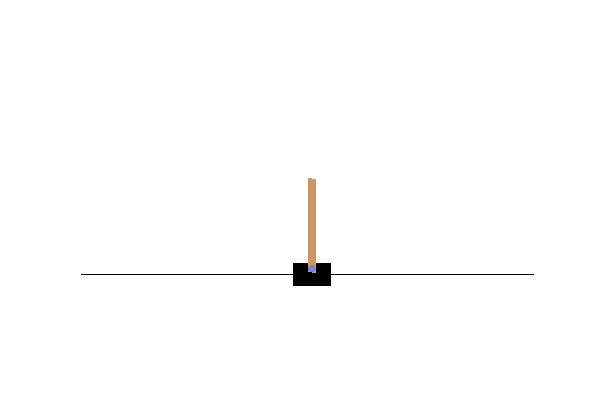
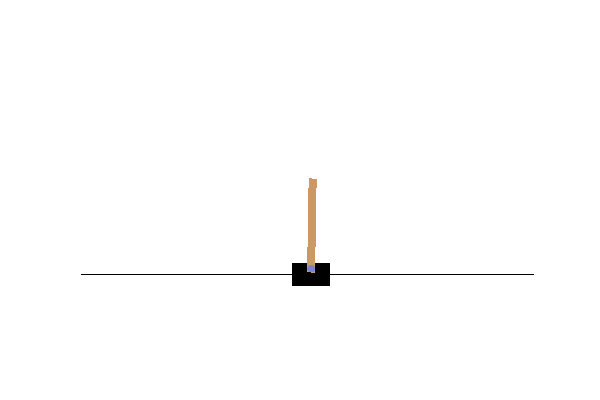
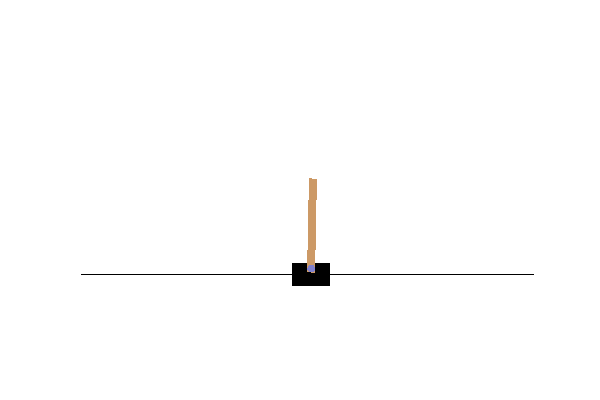
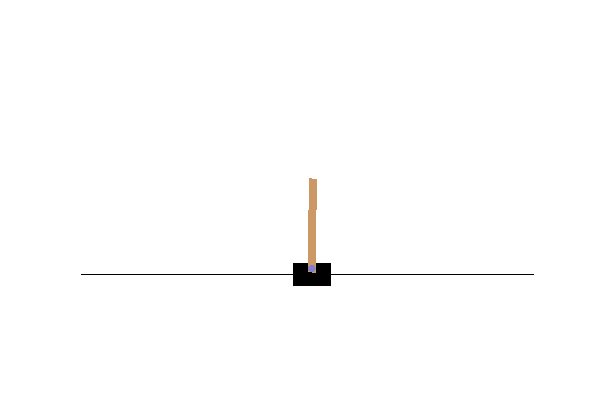
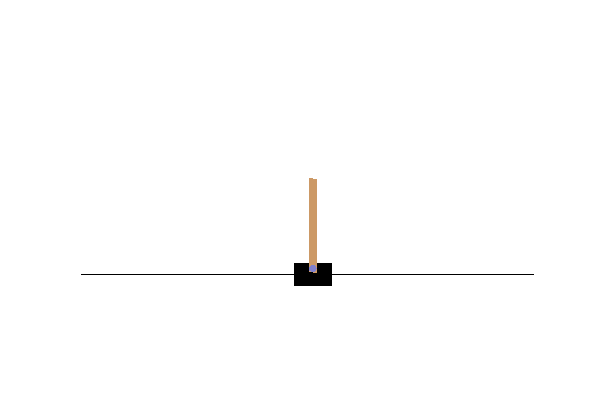
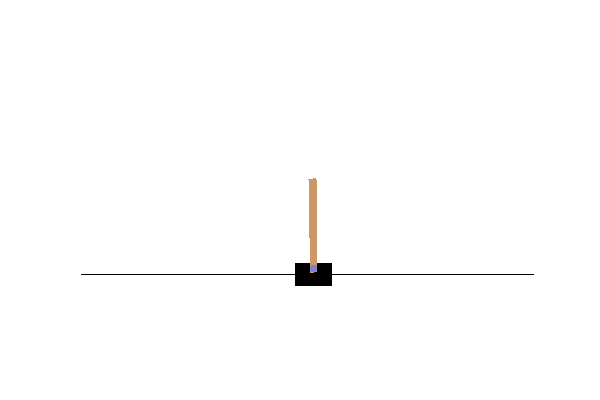
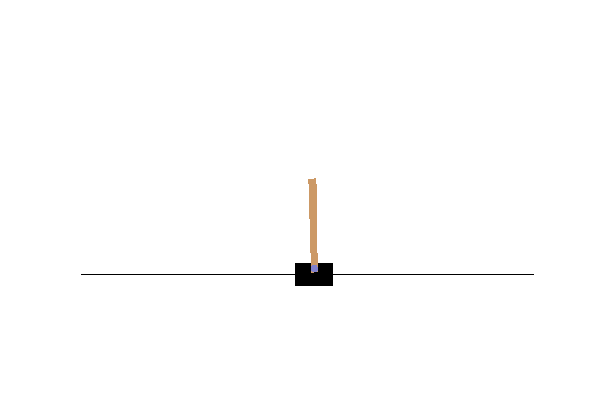
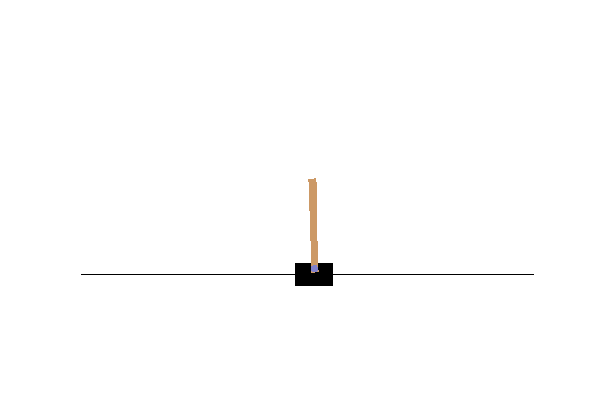
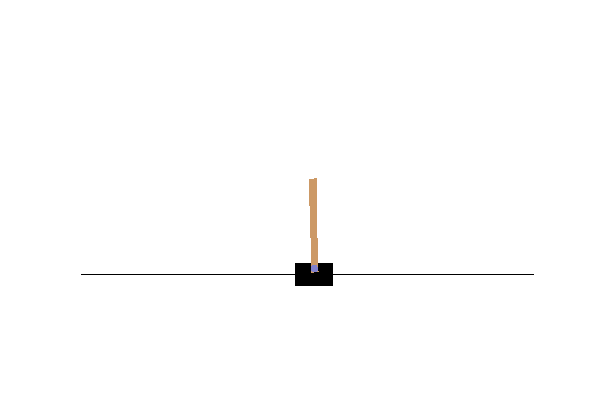
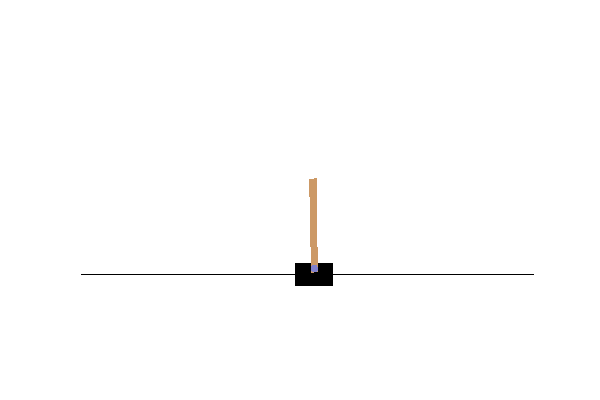
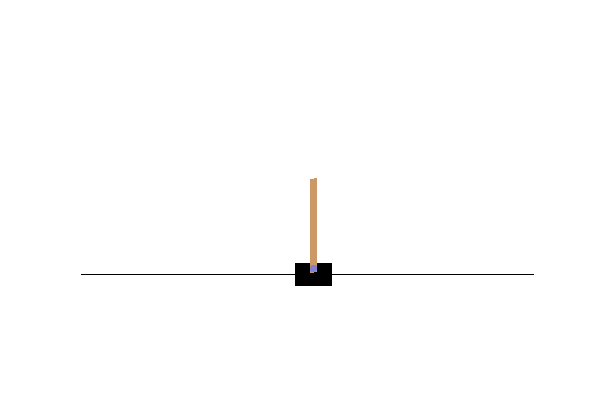
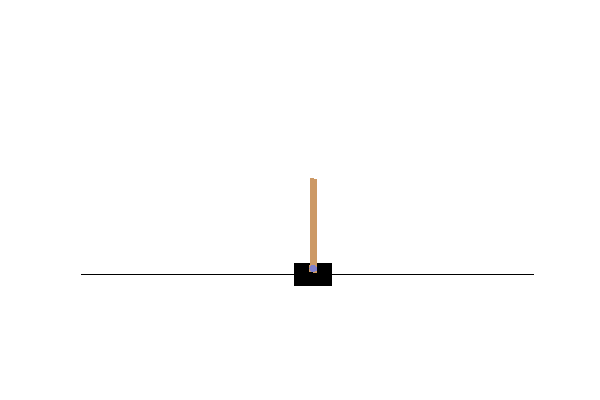
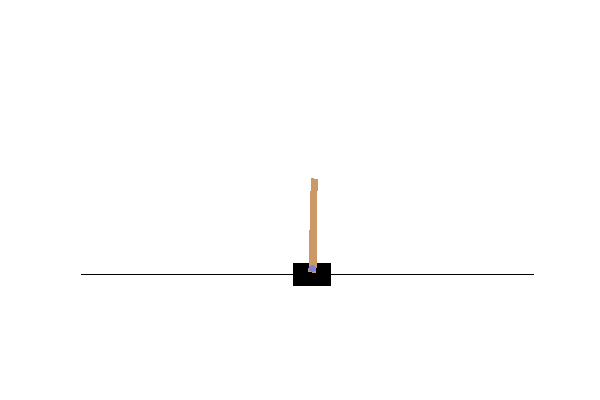
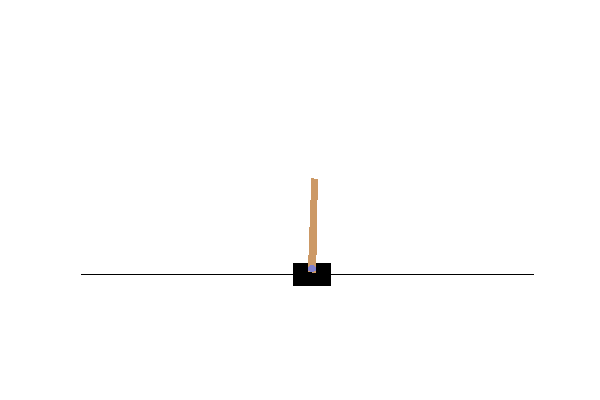
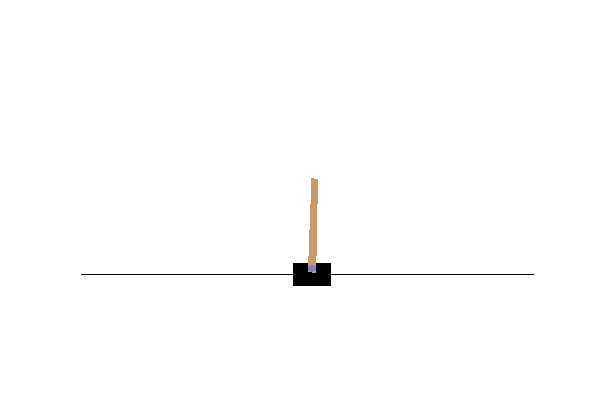
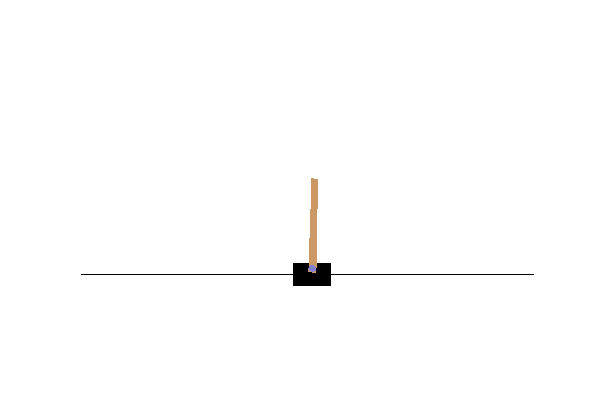
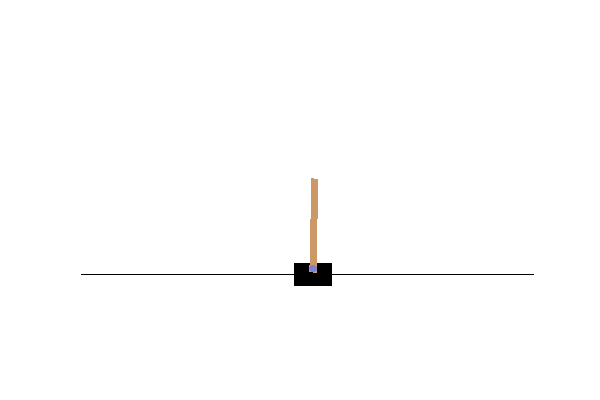
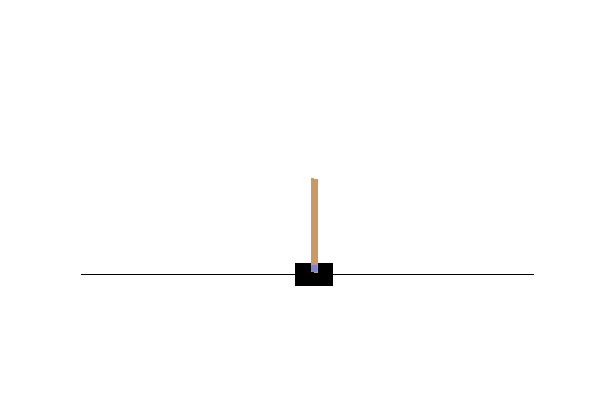
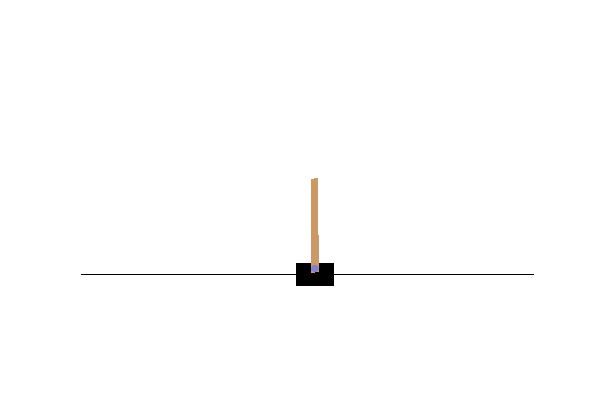
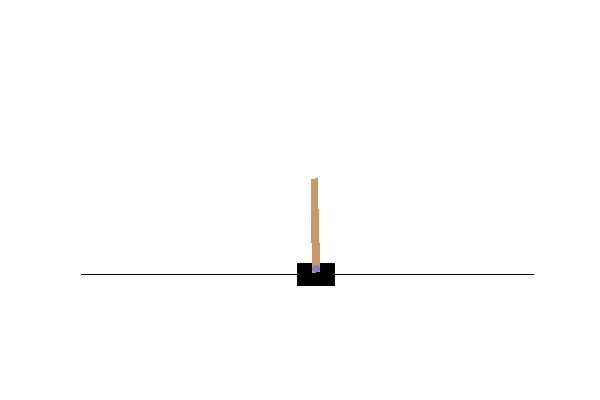
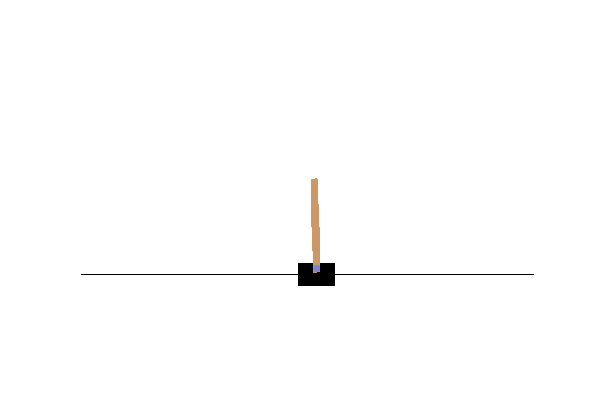
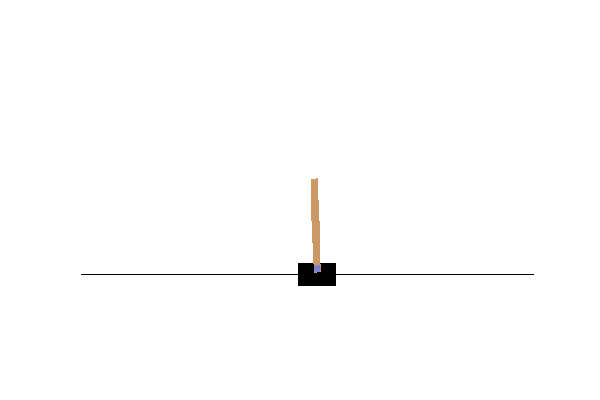
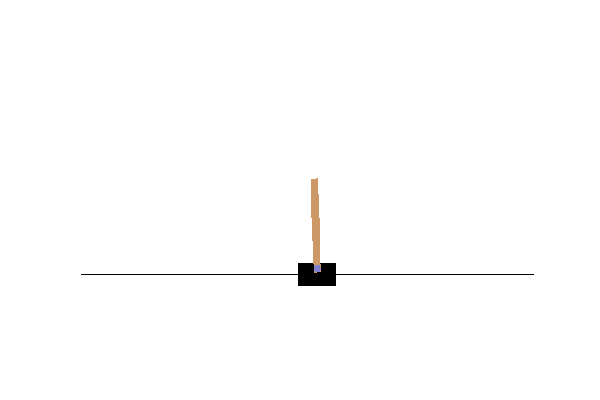
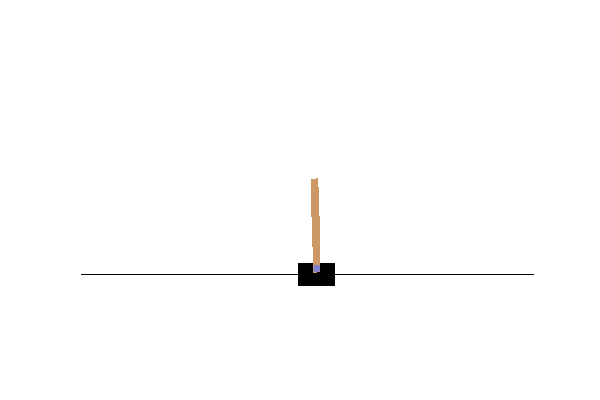
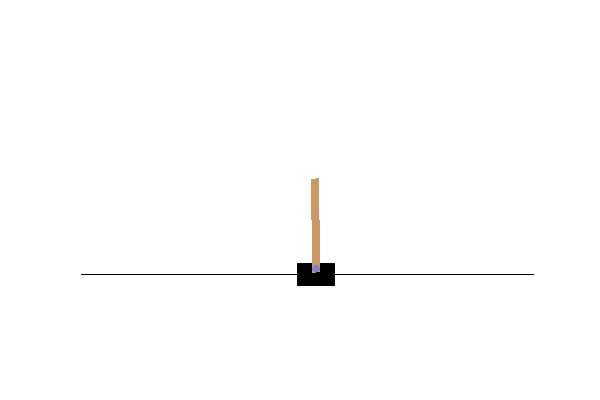
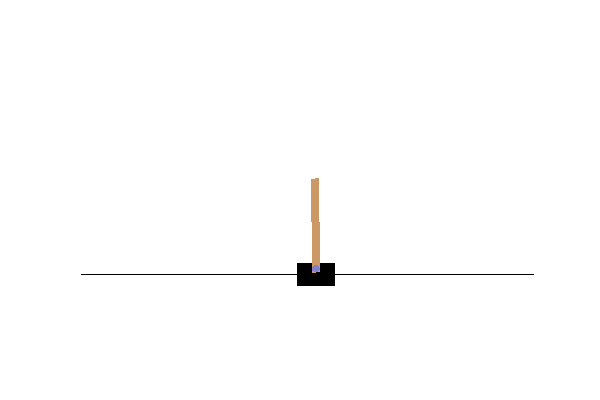
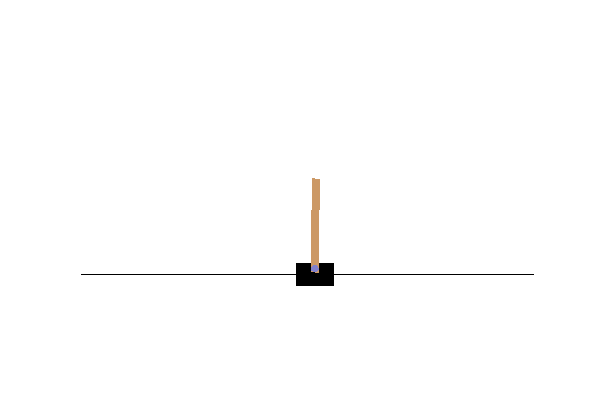
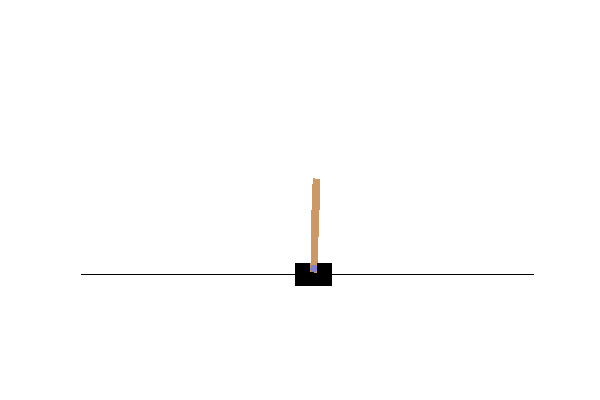
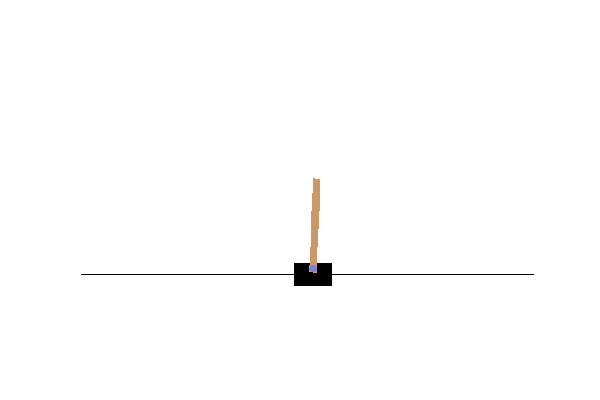
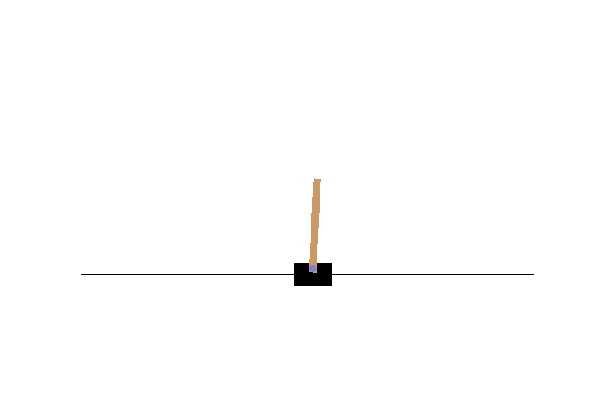
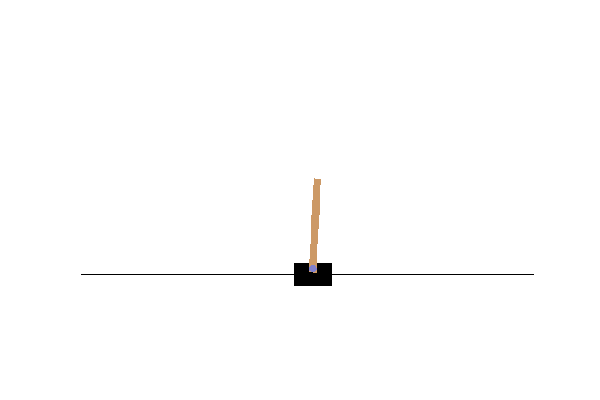
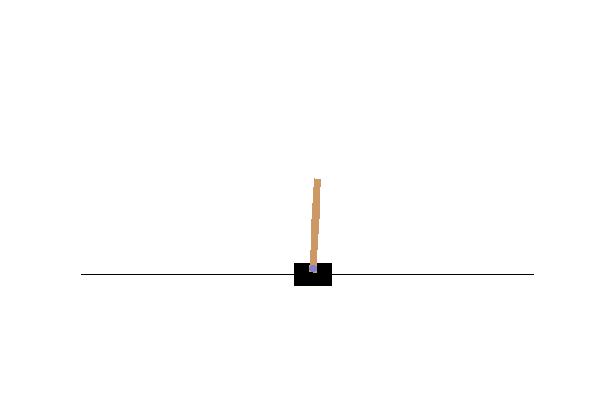
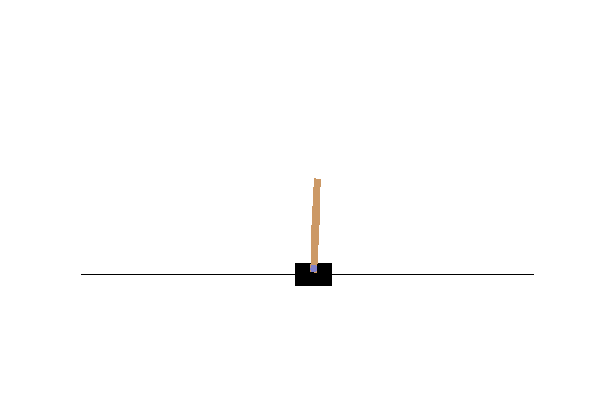
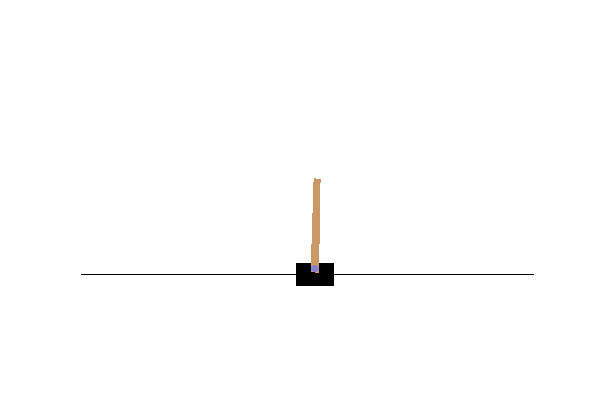
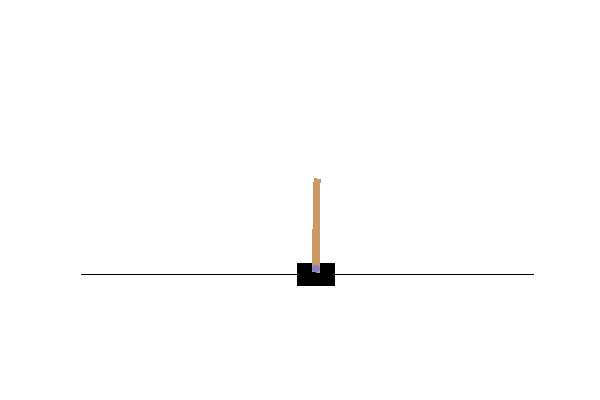
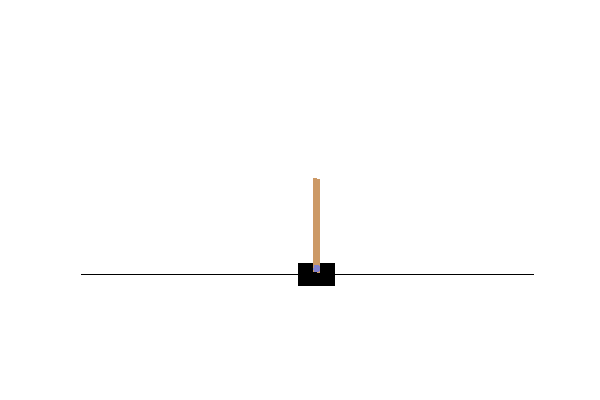
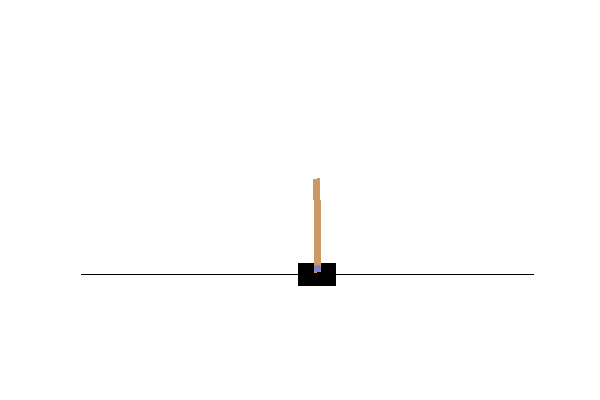
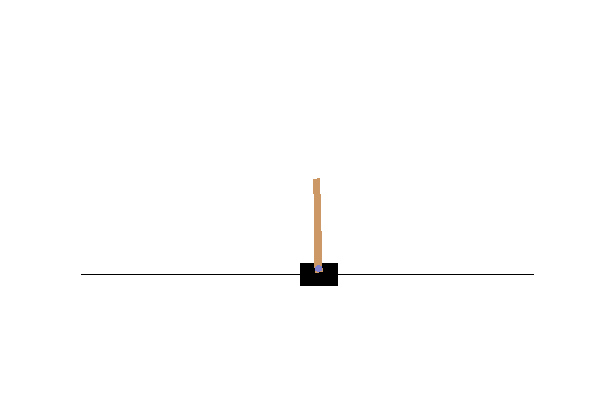
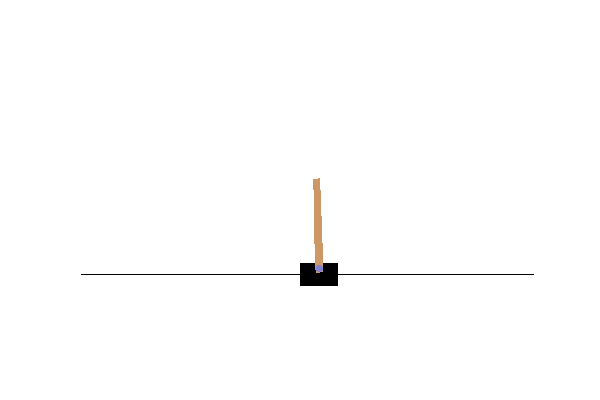
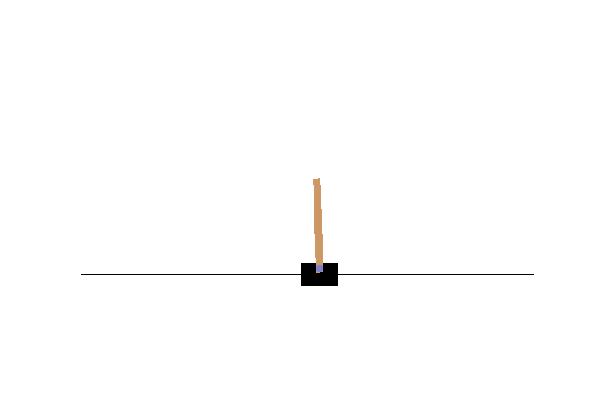
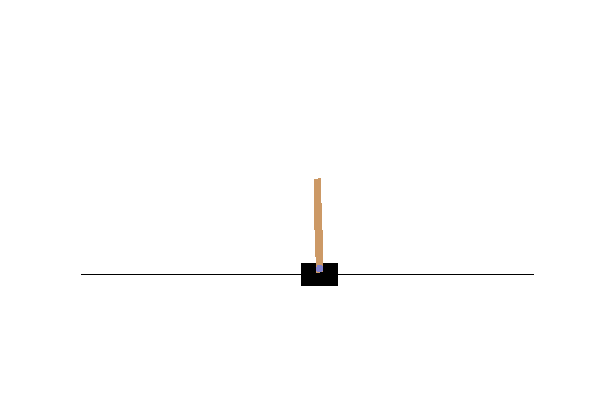
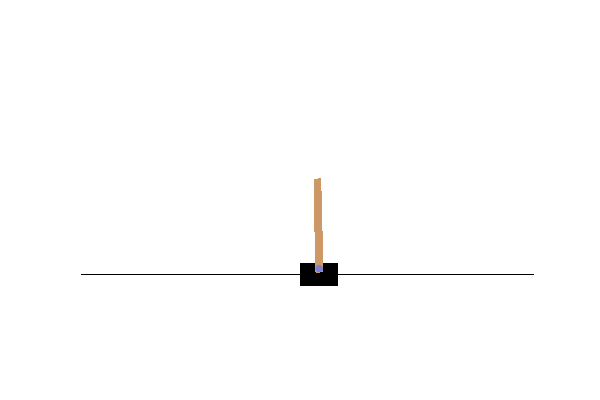
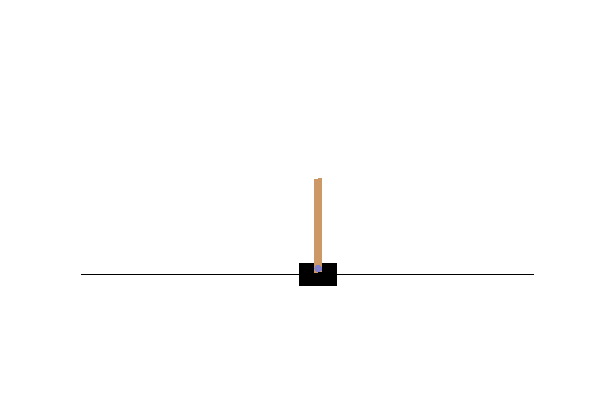
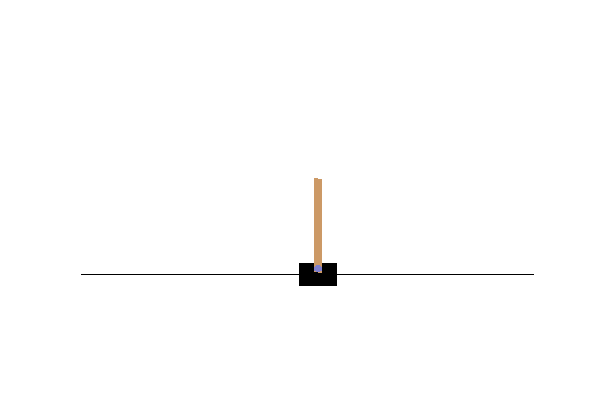
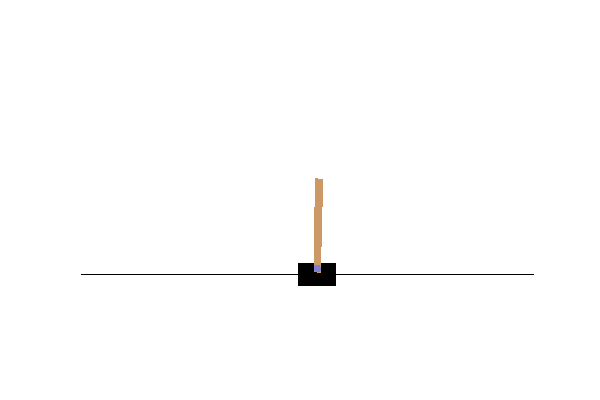
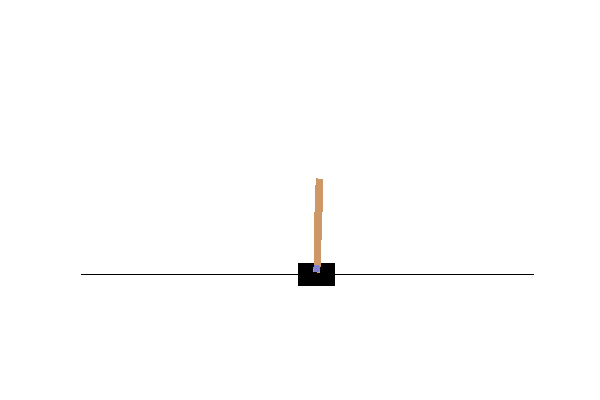
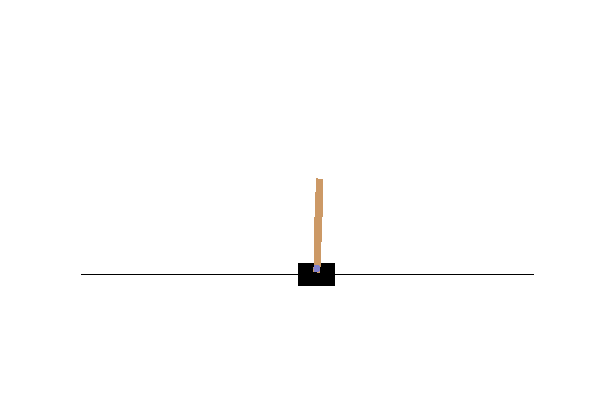
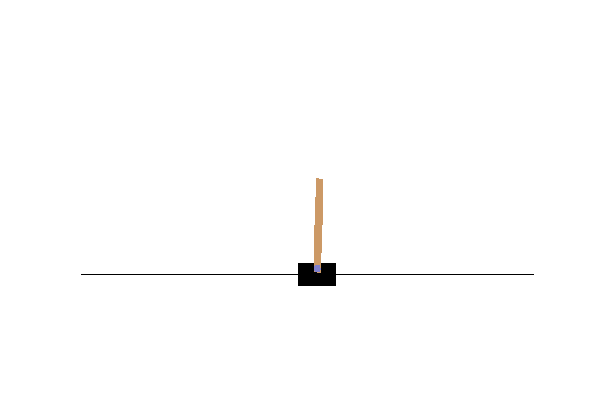
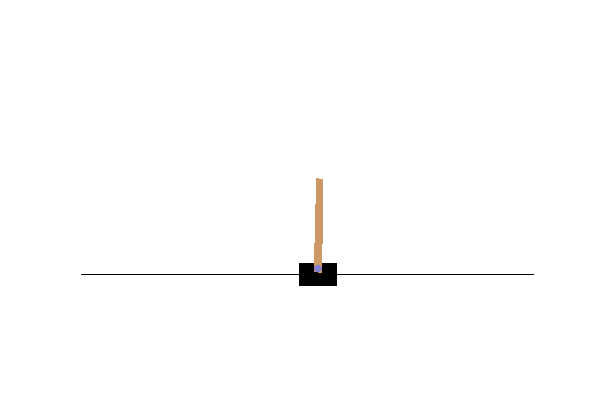
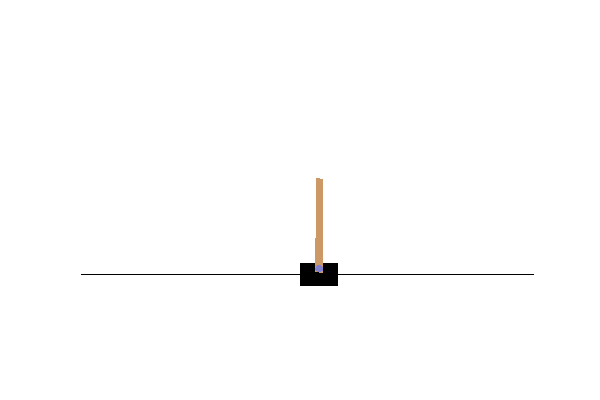
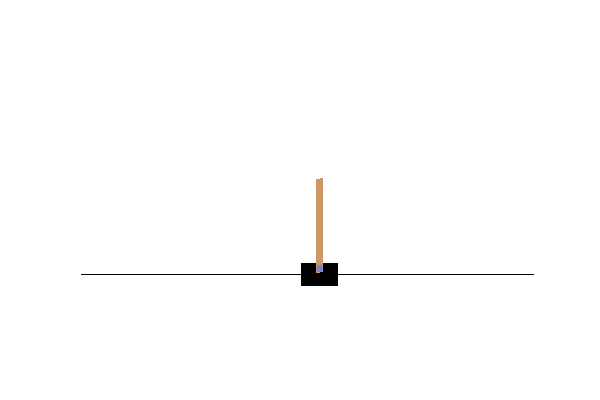
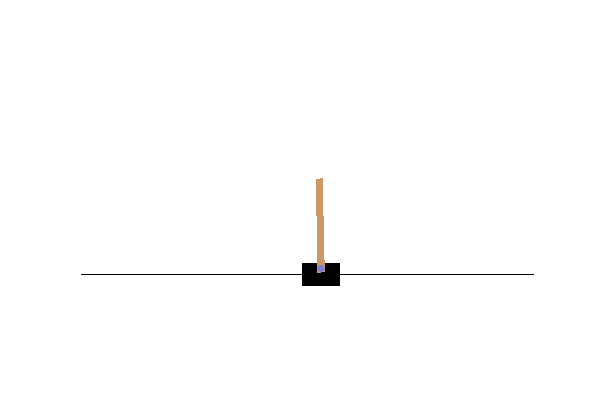
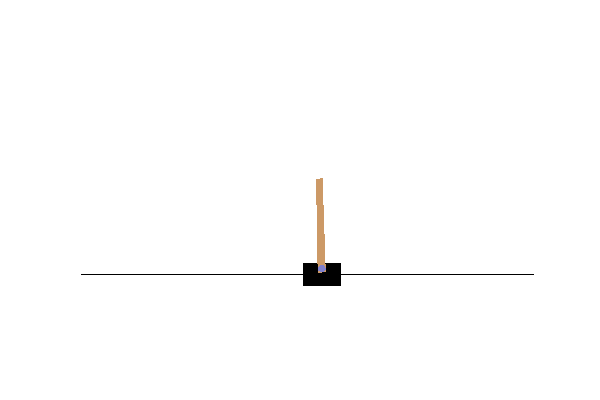
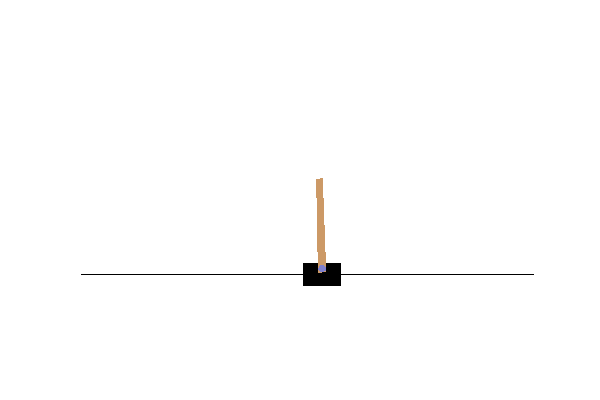
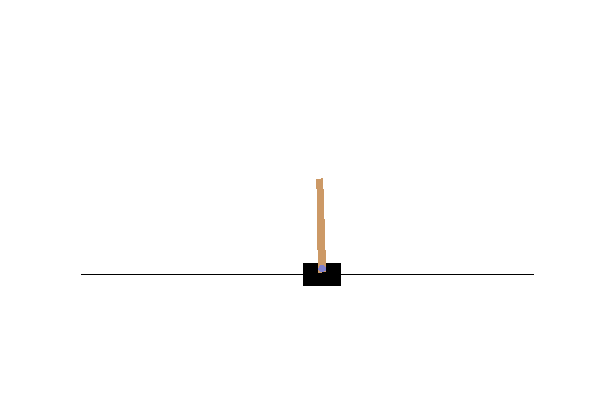
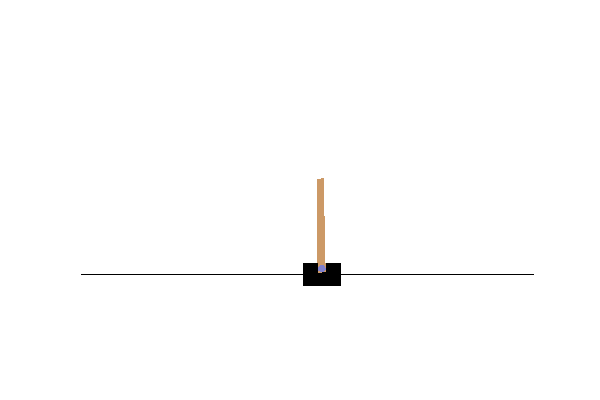
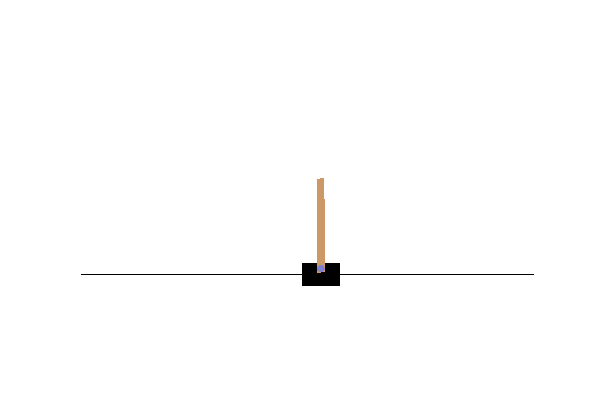
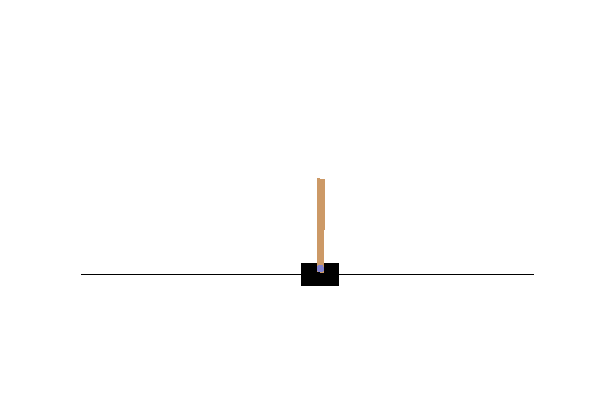
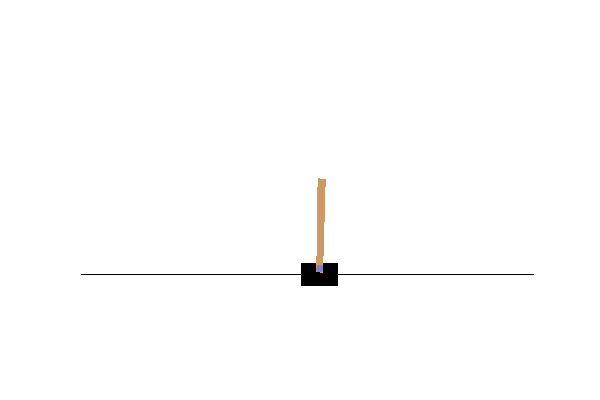
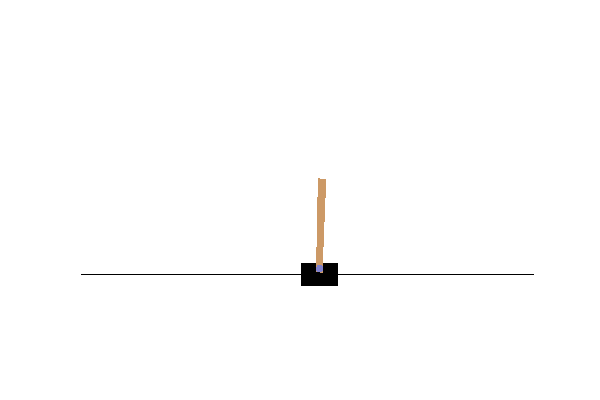
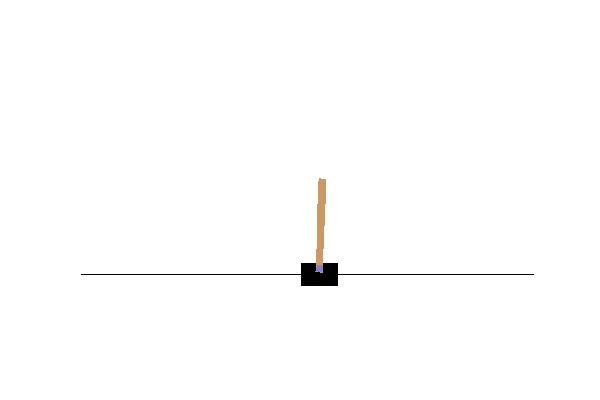
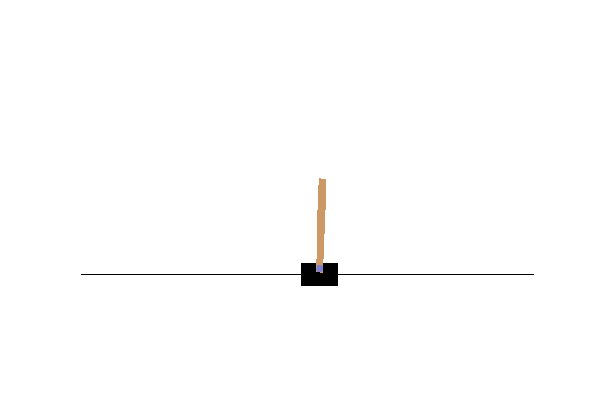
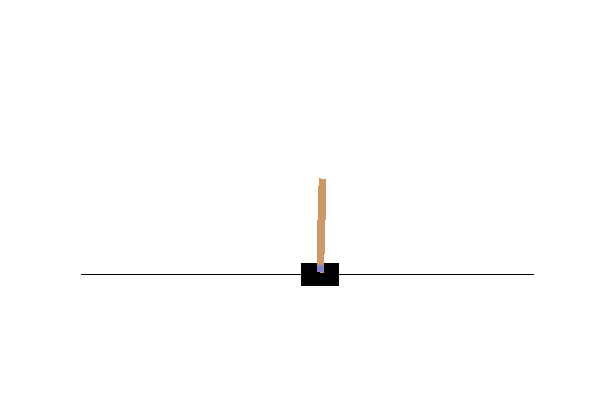
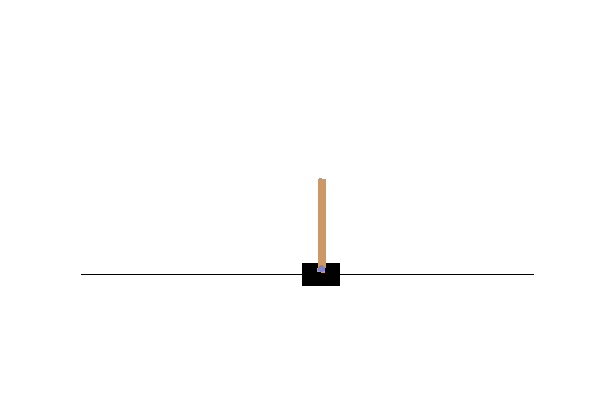
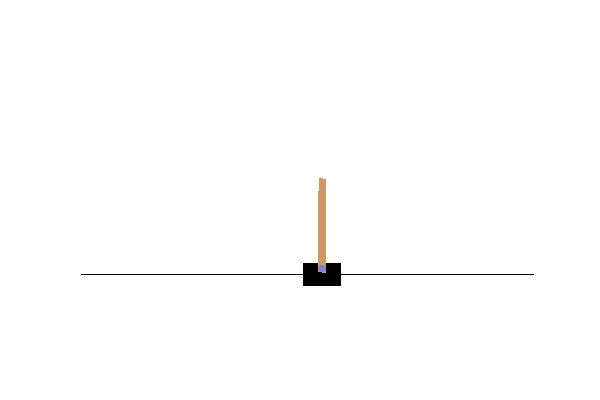

In [23]:
# main
cartpole_env = Environment()
cartpole_env.run()